# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [5]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [6]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [7]:
off_play_types

['Pass Completion',
 'Rush',
 'Pass Incompletion',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [8]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
1,1,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
2,2,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
3,3,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
4,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,11,47,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP,play_explosive,play_successful
0,0,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253,False,False
1,1,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460,True,True
2,2,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449,False,True
3,3,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000,False,False
4,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408,False,True


In [12]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["Return"] = punt_distance.apply(lambda x: punt_plays.yards_gained[x.Index],axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [13]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.050452,5.386628,4.46,5.017309,5.070568,0.141137
1,Virginia Tech,4.857978,4.949548,4.613372,5.54,4.982691,4.929432,-0.141137


In [14]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

[Local] Box Scores are not available, generating them from scratch...
[1/6644] Getting game information for ESPN game_id: 322432006...
[1/6644] Started processing game information for ESPN game_id: 322432006...
[1/6644] Completed processing game information for ESPN game_id: 322432006.
[1/6644] Aggreggated game_id 322432006 to master data copy.
[2/6644] Getting game information for ESPN game_id: 322430238...
[2/6644] Started processing game information for ESPN game_id: 322430238...
[2/6644] Completed processing game information for ESPN game_id: 322430238.
[2/6644] Aggreggated game_id 322430238 to master data copy.
[3/6644] Getting game information for ESPN game_id: 322432050...
[3/6644] Started processing game information for ESPN game_id: 322432050...
[3/6644] Completed processing game information for ESPN game_id: 322432050.
[3/6644] Aggreggated game_id 322432050 to master data copy.
[4/6644] Getting game information for ESPN game_id: 322432117...
[4/6644] Started processing game i

[35/6644] Completed processing game information for ESPN game_id: 322450025.
[35/6644] Aggreggated game_id 322450025 to master data copy.
[36/6644] Getting game information for ESPN game_id: 322450057...
[36/6644] Started processing game information for ESPN game_id: 322450057...
[36/6644] Completed processing game information for ESPN game_id: 322450057.
[36/6644] Aggreggated game_id 322450057 to master data copy.
[37/6644] Getting game information for ESPN game_id: 322450275...
[37/6644] Started processing game information for ESPN game_id: 322450275...
[37/6644] Skipping checking game_id 322450275 bc one of the teams isn't FBS.
[38/6644] Getting game information for ESPN game_id: 322450158...
[38/6644] Started processing game information for ESPN game_id: 322450158...
[38/6644] Completed processing game information for ESPN game_id: 322450158.
[38/6644] Aggreggated game_id 322450158 to master data copy.
[39/6644] Getting game information for ESPN game_id: 322450103...
[39/6644] Star

[68/6644] Completed processing game information for ESPN game_id: 322450333.
[68/6644] Aggreggated game_id 322450333 to master data copy.
[69/6644] Getting game information for ESPN game_id: 322450278...
[69/6644] Started processing game information for ESPN game_id: 322450278...
[69/6644] Skipping checking game_id 322450278 bc one of the teams isn't FBS.
[70/6644] Getting game information for ESPN game_id: 322452638...
[70/6644] Started processing game information for ESPN game_id: 322452638...
[70/6644] Completed processing game information for ESPN game_id: 322452638.
[70/6644] Aggreggated game_id 322452638 to master data copy.
[71/6644] Getting game information for ESPN game_id: 322452483...
[71/6644] Started processing game information for ESPN game_id: 322452483...
[71/6644] Completed processing game information for ESPN game_id: 322452483.
[71/6644] Aggreggated game_id 322452483 to master data copy.
[72/6644] Getting game information for ESPN game_id: 322450264...
[72/6644] Star

[101/6644] Completed processing game information for ESPN game_id: 322520245.
[101/6644] Aggreggated game_id 322520245 to master data copy.
[102/6644] Getting game information for ESPN game_id: 322520333...
[102/6644] Started processing game information for ESPN game_id: 322520333...
[102/6644] Completed processing game information for ESPN game_id: 322520333.
[102/6644] Aggreggated game_id 322520333 to master data copy.
[103/6644] Getting game information for ESPN game_id: 322522305...
[103/6644] Started processing game information for ESPN game_id: 322522305...
[103/6644] Completed processing game information for ESPN game_id: 322522305.
[103/6644] Aggreggated game_id 322522305 to master data copy.
[104/6644] Getting game information for ESPN game_id: 322522117...
[104/6644] Started processing game information for ESPN game_id: 322522117...
[104/6644] Completed processing game information for ESPN game_id: 322522117.
[104/6644] Aggreggated game_id 322522117 to master data copy.
[105/

[132/6644] Completed processing game information for ESPN game_id: 322522032.
[132/6644] Aggreggated game_id 322522032 to master data copy.
[133/6644] Getting game information for ESPN game_id: 322520276...
[133/6644] Started processing game information for ESPN game_id: 322520276...
[133/6644] Skipping checking game_id 322520276 bc one of the teams isn't FBS.
[134/6644] Getting game information for ESPN game_id: 322522628...
[134/6644] Started processing game information for ESPN game_id: 322522628...
[134/6644] Skipping checking game_id 322522628 bc one of the teams isn't FBS.
[135/6644] Getting game information for ESPN game_id: 322520059...
[135/6644] Started processing game information for ESPN game_id: 322520059...
[135/6644] Skipping checking game_id 322520059 bc one of the teams isn't FBS.
[136/6644] Getting game information for ESPN game_id: 322520096...
[136/6644] Started processing game information for ESPN game_id: 322520096...
[136/6644] Completed processing game informati

[164/6644] Completed processing game information for ESPN game_id: 322590120.
[164/6644] Aggreggated game_id 322590120 to master data copy.
[165/6644] Getting game information for ESPN game_id: 322590228...
[165/6644] Started processing game information for ESPN game_id: 322590228...
[165/6644] Skipping checking game_id 322590228 bc one of the teams isn't FBS.
[166/6644] Getting game information for ESPN game_id: 322592483...
[166/6644] Started processing game information for ESPN game_id: 322592483...
[166/6644] Skipping checking game_id 322592483 bc one of the teams isn't FBS.
[167/6644] Getting game information for ESPN game_id: 322590130...
[167/6644] Started processing game information for ESPN game_id: 322590130...
[167/6644] Completed processing game information for ESPN game_id: 322590130.
[167/6644] Aggreggated game_id 322590130 to master data copy.
[168/6644] Getting game information for ESPN game_id: 322590008...
[168/6644] Started processing game information for ESPN game_i

[196/6644] Completed processing game information for ESPN game_id: 322590235.
[196/6644] Aggreggated game_id 322590235 to master data copy.
[197/6644] Getting game information for ESPN game_id: 322592306...
[197/6644] Started processing game information for ESPN game_id: 322592306...
[197/6644] Completed processing game information for ESPN game_id: 322592306.
[197/6644] Aggreggated game_id 322592306 to master data copy.
[198/6644] Getting game information for ESPN game_id: 322592579...
[198/6644] Started processing game information for ESPN game_id: 322592579...
[198/6644] Completed processing game information for ESPN game_id: 322592579.
[198/6644] Aggreggated game_id 322592579 to master data copy.
[199/6644] Getting game information for ESPN game_id: 322590239...
[199/6644] Started processing game information for ESPN game_id: 322590239...
[199/6644] Skipping checking game_id 322590239 bc one of the teams isn't FBS.
[200/6644] Getting game information for ESPN game_id: 322592440...


Could not find drive data for game_id 322662655 on CFB Data API, bailing out
[226/6644] Got 'None' for game_id 322662655's box score, skipping processing.
[227/6644] Getting game information for ESPN game_id: 322660057...
[227/6644] Started processing game information for ESPN game_id: 322660057...
[227/6644] Completed processing game information for ESPN game_id: 322660057.
[227/6644] Aggreggated game_id 322660057 to master data copy.
[228/6644] Getting game information for ESPN game_id: 322662628...
[228/6644] Started processing game information for ESPN game_id: 322662628...
[228/6644] Completed processing game information for ESPN game_id: 322662628.
[228/6644] Aggreggated game_id 322662628 to master data copy.
[229/6644] Getting game information for ESPN game_id: 322660154...
[229/6644] Started processing game information for ESPN game_id: 322660154...
[229/6644] Completed processing game information for ESPN game_id: 322660154.
[229/6644] Aggreggated game_id 322660154 to master d

[257/6644] Completed processing game information for ESPN game_id: 322660249.
[257/6644] Aggreggated game_id 322660249 to master data copy.
[258/6644] Getting game information for ESPN game_id: 322660036...
[258/6644] Started processing game information for ESPN game_id: 322660036...
[258/6644] Completed processing game information for ESPN game_id: 322660036.
[258/6644] Aggreggated game_id 322660036 to master data copy.
[259/6644] Getting game information for ESPN game_id: 322660008...
[259/6644] Started processing game information for ESPN game_id: 322660008...
[259/6644] Completed processing game information for ESPN game_id: 322660008.
[259/6644] Aggreggated game_id 322660008 to master data copy.
[260/6644] Getting game information for ESPN game_id: 322660326...
[260/6644] Started processing game information for ESPN game_id: 322660326...
[260/6644] Skipping checking game_id 322660326 bc one of the teams isn't FBS.
[261/6644] Getting game information for ESPN game_id: 322662032...


[287/6644] Completed processing game information for ESPN game_id: 322730041.
[287/6644] Aggreggated game_id 322730041 to master data copy.
[288/6644] Getting game information for ESPN game_id: 322730059...
[288/6644] Started processing game information for ESPN game_id: 322730059...
[288/6644] Completed processing game information for ESPN game_id: 322730059.
[288/6644] Aggreggated game_id 322730059 to master data copy.
[289/6644] Getting game information for ESPN game_id: 322730245...
[289/6644] Started processing game information for ESPN game_id: 322730245...
[289/6644] Completed processing game information for ESPN game_id: 322730245.
[289/6644] Aggreggated game_id 322730245 to master data copy.
[290/6644] Getting game information for ESPN game_id: 322730154...
[290/6644] Started processing game information for ESPN game_id: 322730154...
[290/6644] Completed processing game information for ESPN game_id: 322730154.
[290/6644] Aggreggated game_id 322730154 to master data copy.
[291/

[316/6644] Completed processing game information for ESPN game_id: 322730151.
[316/6644] Aggreggated game_id 322730151 to master data copy.
[317/6644] Getting game information for ESPN game_id: 322730309...
[317/6644] Started processing game information for ESPN game_id: 322730309...
[317/6644] Completed processing game information for ESPN game_id: 322730309.
[317/6644] Aggreggated game_id 322730309 to master data copy.
[318/6644] Getting game information for ESPN game_id: 322732032...
[318/6644] Started processing game information for ESPN game_id: 322732032...
[318/6644] Completed processing game information for ESPN game_id: 322732032.
[318/6644] Aggreggated game_id 322732032 to master data copy.
[319/6644] Getting game information for ESPN game_id: 322730096...
[319/6644] Started processing game information for ESPN game_id: 322730096...
[319/6644] Completed processing game information for ESPN game_id: 322730096.
[319/6644] Aggreggated game_id 322730096 to master data copy.
[320/

[345/6644] Completed processing game information for ESPN game_id: 322800002.
[345/6644] Aggreggated game_id 322800002 to master data copy.
[346/6644] Getting game information for ESPN game_id: 322800096...
[346/6644] Started processing game information for ESPN game_id: 322800096...
[346/6644] Completed processing game information for ESPN game_id: 322800096.
[346/6644] Aggreggated game_id 322800096 to master data copy.
[347/6644] Getting game information for ESPN game_id: 322800153...
[347/6644] Started processing game information for ESPN game_id: 322800153...
[347/6644] Completed processing game information for ESPN game_id: 322800153.
[347/6644] Aggreggated game_id 322800153 to master data copy.
[348/6644] Getting game information for ESPN game_id: 322802199...
[348/6644] Started processing game information for ESPN game_id: 322802199...
[348/6644] Completed processing game information for ESPN game_id: 322802199.
[348/6644] Aggreggated game_id 322802199 to master data copy.
[349/

[375/6644] Completed processing game information for ESPN game_id: 322800145.
[375/6644] Aggreggated game_id 322800145 to master data copy.
[376/6644] Getting game information for ESPN game_id: 322802348...
[376/6644] Started processing game information for ESPN game_id: 322802348...
[376/6644] Completed processing game information for ESPN game_id: 322802348.
[376/6644] Aggreggated game_id 322802348 to master data copy.
[377/6644] Getting game information for ESPN game_id: 322802440...
[377/6644] Started processing game information for ESPN game_id: 322802440...
[377/6644] Completed processing game information for ESPN game_id: 322802440.
[377/6644] Aggreggated game_id 322802440 to master data copy.
[378/6644] Getting game information for ESPN game_id: 322802579...
[378/6644] Started processing game information for ESPN game_id: 322802579...
[378/6644] Completed processing game information for ESPN game_id: 322802579.
[378/6644] Aggreggated game_id 322802579 to master data copy.
[379/

Could not find drive data for game_id 322870195 on CFB Data API, bailing out
[404/6644] Got 'None' for game_id 322870195's box score, skipping processing.
[405/6644] Getting game information for ESPN game_id: 322872390...
[405/6644] Started processing game information for ESPN game_id: 322872390...
[405/6644] Completed processing game information for ESPN game_id: 322872390.
[405/6644] Aggreggated game_id 322872390 to master data copy.
[406/6644] Getting game information for ESPN game_id: 322870026...
[406/6644] Started processing game information for ESPN game_id: 322870026...
[406/6644] Completed processing game information for ESPN game_id: 322870026.
[406/6644] Aggreggated game_id 322870026 to master data copy.
[407/6644] Getting game information for ESPN game_id: 322870258...
[407/6644] Started processing game information for ESPN game_id: 322870258...
[407/6644] Completed processing game information for ESPN game_id: 322870258.
[407/6644] Aggreggated game_id 322870258 to master d

[434/6644] Completed processing game information for ESPN game_id: 322872433.
[434/6644] Aggreggated game_id 322872433 to master data copy.
[435/6644] Getting game information for ESPN game_id: 322870099...
[435/6644] Started processing game information for ESPN game_id: 322870099...
[435/6644] Completed processing game information for ESPN game_id: 322870099.
[435/6644] Aggreggated game_id 322870099 to master data copy.
[436/6644] Getting game information for ESPN game_id: 322870084...
[436/6644] Started processing game information for ESPN game_id: 322870084...
[436/6644] Completed processing game information for ESPN game_id: 322870084.
[436/6644] Aggreggated game_id 322870084 to master data copy.
[437/6644] Getting game information for ESPN game_id: 322872348...
[437/6644] Started processing game information for ESPN game_id: 322872348...
[437/6644] Completed processing game information for ESPN game_id: 322872348.
[437/6644] Aggreggated game_id 322872348 to master data copy.
[438/

[463/6644] Completed processing game information for ESPN game_id: 322940087.
[463/6644] Aggreggated game_id 322940087 to master data copy.
[464/6644] Getting game information for ESPN game_id: 322940130...
[464/6644] Started processing game information for ESPN game_id: 322940130...
[464/6644] Completed processing game information for ESPN game_id: 322940130.
[464/6644] Aggreggated game_id 322940130 to master data copy.
[465/6644] Getting game information for ESPN game_id: 322942426...
[465/6644] Started processing game information for ESPN game_id: 322942426...
[465/6644] Completed processing game information for ESPN game_id: 322942426.
[465/6644] Aggreggated game_id 322942426 to master data copy.
[466/6644] Getting game information for ESPN game_id: 322942309...
[466/6644] Started processing game information for ESPN game_id: 322942309...
[466/6644] Completed processing game information for ESPN game_id: 322942309.
[466/6644] Aggreggated game_id 322942309 to master data copy.
[467/

[492/6644] Completed processing game information for ESPN game_id: 322942390.
[492/6644] Aggreggated game_id 322942390 to master data copy.
[493/6644] Getting game information for ESPN game_id: 322940012...
[493/6644] Started processing game information for ESPN game_id: 322940012...
[493/6644] Completed processing game information for ESPN game_id: 322940012.
[493/6644] Aggreggated game_id 322940012 to master data copy.
[494/6644] Getting game information for ESPN game_id: 322940278...
[494/6644] Started processing game information for ESPN game_id: 322940278...
[494/6644] Completed processing game information for ESPN game_id: 322940278.
[494/6644] Aggreggated game_id 322940278 to master data copy.
[495/6644] Getting game information for ESPN game_id: 322940204...
[495/6644] Started processing game information for ESPN game_id: 322940204...
[495/6644] Completed processing game information for ESPN game_id: 322940204.
[495/6644] Aggreggated game_id 322940204 to master data copy.
[496/

[521/6644] Completed processing game information for ESPN game_id: 323010052.
[521/6644] Aggreggated game_id 323010052 to master data copy.
[522/6644] Getting game information for ESPN game_id: 323010164...
[522/6644] Started processing game information for ESPN game_id: 323010164...
[522/6644] Completed processing game information for ESPN game_id: 323010164.
[522/6644] Aggreggated game_id 323010164 to master data copy.
[523/6644] Getting game information for ESPN game_id: 323012751...
[523/6644] Started processing game information for ESPN game_id: 323012751...
[523/6644] Completed processing game information for ESPN game_id: 323012751.
[523/6644] Aggreggated game_id 323012751 to master data copy.
[524/6644] Getting game information for ESPN game_id: 323010193...
[524/6644] Started processing game information for ESPN game_id: 323010193...
[524/6644] Completed processing game information for ESPN game_id: 323010193.
[524/6644] Aggreggated game_id 323010193 to master data copy.
[525/

[550/6644] Completed processing game information for ESPN game_id: 323010201.
[550/6644] Aggreggated game_id 323010201 to master data copy.
[551/6644] Getting game information for ESPN game_id: 323010158...
[551/6644] Started processing game information for ESPN game_id: 323010158...
[551/6644] Completed processing game information for ESPN game_id: 323010158.
[551/6644] Aggreggated game_id 323010158 to master data copy.
[552/6644] Getting game information for ESPN game_id: 323010333...
[552/6644] Started processing game information for ESPN game_id: 323010333...
[552/6644] Completed processing game information for ESPN game_id: 323010333.
[552/6644] Aggreggated game_id 323010333 to master data copy.
[553/6644] Getting game information for ESPN game_id: 323010254...
[553/6644] Started processing game information for ESPN game_id: 323010254...
[553/6644] Completed processing game information for ESPN game_id: 323010254.
[553/6644] Aggreggated game_id 323010254 to master data copy.
[554/

[579/6644] Completed processing game information for ESPN game_id: 323080328.
[579/6644] Aggreggated game_id 323080328 to master data copy.
[580/6644] Getting game information for ESPN game_id: 323080254...
[580/6644] Started processing game information for ESPN game_id: 323080254...
[580/6644] Completed processing game information for ESPN game_id: 323080254.
[580/6644] Aggreggated game_id 323080254 to master data copy.
[581/6644] Getting game information for ESPN game_id: 323082459...
[581/6644] Started processing game information for ESPN game_id: 323082459...
[581/6644] Completed processing game information for ESPN game_id: 323082459.
[581/6644] Aggreggated game_id 323082459 to master data copy.
[582/6644] Getting game information for ESPN game_id: 323080061...
[582/6644] Started processing game information for ESPN game_id: 323080061...
[582/6644] Completed processing game information for ESPN game_id: 323080061.
[582/6644] Aggreggated game_id 323080061 to master data copy.
[583/

[608/6644] Completed processing game information for ESPN game_id: 323080068.
[608/6644] Aggreggated game_id 323080068 to master data copy.
[609/6644] Getting game information for ESPN game_id: 323080026...
[609/6644] Started processing game information for ESPN game_id: 323080026...
[609/6644] Completed processing game information for ESPN game_id: 323080026.
[609/6644] Aggreggated game_id 323080026 to master data copy.
[610/6644] Getting game information for ESPN game_id: 323080204...
[610/6644] Started processing game information for ESPN game_id: 323080204...
[610/6644] Completed processing game information for ESPN game_id: 323080204.
[610/6644] Aggreggated game_id 323080204 to master data copy.
[611/6644] Getting game information for ESPN game_id: 323112649...
[611/6644] Started processing game information for ESPN game_id: 323112649...
[611/6644] Completed processing game information for ESPN game_id: 323112649.
[611/6644] Aggreggated game_id 323112649 to master data copy.
[612/

[637/6644] Completed processing game information for ESPN game_id: 323150228.
[637/6644] Aggreggated game_id 323150228 to master data copy.
[638/6644] Getting game information for ESPN game_id: 323150333...
[638/6644] Started processing game information for ESPN game_id: 323150333...
[638/6644] Completed processing game information for ESPN game_id: 323150333.
[638/6644] Aggreggated game_id 323150333 to master data copy.
[639/6644] Getting game information for ESPN game_id: 323150201...
[639/6644] Started processing game information for ESPN game_id: 323150201...
[639/6644] Completed processing game information for ESPN game_id: 323150201.
[639/6644] Aggreggated game_id 323150201 to master data copy.
[640/6644] Getting game information for ESPN game_id: 323150158...
[640/6644] Started processing game information for ESPN game_id: 323150158...
[640/6644] Completed processing game information for ESPN game_id: 323150158.
[640/6644] Aggreggated game_id 323150158 to master data copy.
[641/

[667/6644] Completed processing game information for ESPN game_id: 323152440.
[667/6644] Aggreggated game_id 323152440 to master data copy.
[668/6644] Getting game information for ESPN game_id: 323192050...
[668/6644] Started processing game information for ESPN game_id: 323192050...
[668/6644] Completed processing game information for ESPN game_id: 323192050.
[668/6644] Aggreggated game_id 323192050 to master data copy.
[669/6644] Getting game information for ESPN game_id: 323192459...
[669/6644] Started processing game information for ESPN game_id: 323192459...
[669/6644] Completed processing game information for ESPN game_id: 323192459.
[669/6644] Aggreggated game_id 323192459 to master data copy.
[670/6644] Getting game information for ESPN game_id: 323200258...
[670/6644] Started processing game information for ESPN game_id: 323200258...
[670/6644] Completed processing game information for ESPN game_id: 323200258.
[670/6644] Aggreggated game_id 323200258 to master data copy.
[671/

Could not find drive data for game_id 323220113 on CFB Data API, bailing out
[696/6644] Got 'None' for game_id 323220113's box score, skipping processing.
[697/6644] Getting game information for ESPN game_id: 323220026...
[697/6644] Started processing game information for ESPN game_id: 323220026...
[697/6644] Completed processing game information for ESPN game_id: 323220026.
[697/6644] Aggreggated game_id 323220026 to master data copy.
[698/6644] Getting game information for ESPN game_id: 323220197...
[698/6644] Started processing game information for ESPN game_id: 323220197...
[698/6644] Completed processing game information for ESPN game_id: 323220197.
[698/6644] Aggreggated game_id 323220197 to master data copy.
[699/6644] Getting game information for ESPN game_id: 323220087...
[699/6644] Started processing game information for ESPN game_id: 323220087...
[699/6644] Completed processing game information for ESPN game_id: 323220087.
[699/6644] Aggreggated game_id 323220087 to master d

[726/6644] Completed processing game information for ESPN game_id: 323220239.
[726/6644] Aggreggated game_id 323220239 to master data copy.
[727/6644] Getting game information for ESPN game_id: 323220254...
[727/6644] Started processing game information for ESPN game_id: 323220254...
[727/6644] Completed processing game information for ESPN game_id: 323220254.
[727/6644] Aggreggated game_id 323220254 to master data copy.
[728/6644] Getting game information for ESPN game_id: 323220023...
[728/6644] Started processing game information for ESPN game_id: 323220023...
[728/6644] Completed processing game information for ESPN game_id: 323220023.
[728/6644] Aggreggated game_id 323220023 to master data copy.
[729/6644] Getting game information for ESPN game_id: 323220204...
[729/6644] Started processing game information for ESPN game_id: 323220204...
[729/6644] Completed processing game information for ESPN game_id: 323220204.
[729/6644] Aggreggated game_id 323220204 to master data copy.
[730/

[755/6644] Completed processing game information for ESPN game_id: 323292633.
[755/6644] Aggreggated game_id 323292633 to master data copy.
[756/6644] Getting game information for ESPN game_id: 323290150...
[756/6644] Started processing game information for ESPN game_id: 323290150...
[756/6644] Completed processing game information for ESPN game_id: 323290150.
[756/6644] Aggreggated game_id 323290150 to master data copy.
[757/6644] Getting game information for ESPN game_id: 323290098...
[757/6644] Started processing game information for ESPN game_id: 323290098...
[757/6644] Completed processing game information for ESPN game_id: 323290098.
[757/6644] Aggreggated game_id 323290098 to master data copy.
[758/6644] Getting game information for ESPN game_id: 323292636...
[758/6644] Started processing game information for ESPN game_id: 323292636...
[758/6644] Completed processing game information for ESPN game_id: 323292636.
[758/6644] Aggreggated game_id 323292636 to master data copy.
[759/

[784/6644] Completed processing game information for ESPN game_id: 323290030.
[784/6644] Aggreggated game_id 323290030 to master data copy.
[785/6644] Getting game information for ESPN game_id: 323290023...
[785/6644] Started processing game information for ESPN game_id: 323290023...
[785/6644] Completed processing game information for ESPN game_id: 323290023.
[785/6644] Aggreggated game_id 323290023 to master data copy.
[786/6644] Getting game information for ESPN game_id: 323290062...
[786/6644] Started processing game information for ESPN game_id: 323290062...
[786/6644] Completed processing game information for ESPN game_id: 323290062.
[786/6644] Aggreggated game_id 323290062 to master data copy.
[787/6644] Getting game information for ESPN game_id: 323340164...
[787/6644] Started processing game information for ESPN game_id: 323340164...
[787/6644] Completed processing game information for ESPN game_id: 323340164.
[787/6644] Aggreggated game_id 323340164 to master data copy.
[788/

[819/6644] Completed processing game information for ESPN game_id: 332410254.
[819/6644] Aggreggated game_id 332410254 to master data copy.
[820/6644] Getting game information for ESPN game_id: 332410238...
[820/6644] Started processing game information for ESPN game_id: 332410238...
[820/6644] Completed processing game information for ESPN game_id: 332410238.
[820/6644] Aggreggated game_id 332410238 to master data copy.
[821/6644] Getting game information for ESPN game_id: 332410023...
[821/6644] Started processing game information for ESPN game_id: 332410023...
[821/6644] Skipping checking game_id 332410023 bc one of the teams isn't FBS.
[822/6644] Getting game information for ESPN game_id: 332410278...
[822/6644] Started processing game information for ESPN game_id: 332410278...
[822/6644] Completed processing game information for ESPN game_id: 332410278.
[822/6644] Aggreggated game_id 332410278 to master data copy.
[823/6644] Getting game information for ESPN game_id: 332410062...


[852/6644] Completed processing game information for ESPN game_id: 332430008.
[852/6644] Aggreggated game_id 332430008 to master data copy.
[853/6644] Getting game information for ESPN game_id: 332430259...
[853/6644] Started processing game information for ESPN game_id: 332430259...
[853/6644] Completed processing game information for ESPN game_id: 332430259.
[853/6644] Aggreggated game_id 332430259 to master data copy.
[854/6644] Getting game information for ESPN game_id: 332432199...
[854/6644] Started processing game information for ESPN game_id: 332432199...
[854/6644] Skipping checking game_id 332432199 bc one of the teams isn't FBS.
[855/6644] Getting game information for ESPN game_id: 332430204...
[855/6644] Started processing game information for ESPN game_id: 332430204...
[855/6644] Skipping checking game_id 332430204 bc one of the teams isn't FBS.
[856/6644] Getting game information for ESPN game_id: 332432633...
[856/6644] Started processing game information for ESPN game_i

[884/6644] Completed processing game information for ESPN game_id: 332490103.
[884/6644] Aggreggated game_id 332490103 to master data copy.
[885/6644] Getting game information for ESPN game_id: 332492229...
[885/6644] Started processing game information for ESPN game_id: 332492229...
[885/6644] Completed processing game information for ESPN game_id: 332492229.
[885/6644] Aggreggated game_id 332492229 to master data copy.
[886/6644] Getting game information for ESPN game_id: 332502294...
[886/6644] Started processing game information for ESPN game_id: 332502294...
[886/6644] Skipping checking game_id 332502294 bc one of the teams isn't FBS.
[887/6644] Getting game information for ESPN game_id: 332500097...
[887/6644] Started processing game information for ESPN game_id: 332500097...
[887/6644] Skipping checking game_id 332500097 bc one of the teams isn't FBS.
[888/6644] Getting game information for ESPN game_id: 332502390...
[888/6644] Started processing game information for ESPN game_i

[916/6644] Completed processing game information for ESPN game_id: 332500258.
[916/6644] Aggreggated game_id 332500258 to master data copy.
[917/6644] Getting game information for ESPN game_id: 332502751...
[917/6644] Started processing game information for ESPN game_id: 332502751...
[917/6644] Skipping checking game_id 332502751 bc one of the teams isn't FBS.
[918/6644] Getting game information for ESPN game_id: 332500120...
[918/6644] Started processing game information for ESPN game_id: 332500120...
[918/6644] Completed processing game information for ESPN game_id: 332500120.
[918/6644] Aggreggated game_id 332500120 to master data copy.
[919/6644] Getting game information for ESPN game_id: 332500235...
[919/6644] Started processing game information for ESPN game_id: 332500235...
[919/6644] Completed processing game information for ESPN game_id: 332500235.
[919/6644] Aggreggated game_id 332500235 to master data copy.
[920/6644] Getting game information for ESPN game_id: 332500061...


[949/6644] Completed processing game information for ESPN game_id: 332500130.
[949/6644] Aggreggated game_id 332500130 to master data copy.
[950/6644] Getting game information for ESPN game_id: 332500038...
[950/6644] Started processing game information for ESPN game_id: 332500038...
[950/6644] Skipping checking game_id 332500038 bc one of the teams isn't FBS.
[951/6644] Getting game information for ESPN game_id: 332500204...
[951/6644] Started processing game information for ESPN game_id: 332500204...
[951/6644] Completed processing game information for ESPN game_id: 332500204.
[951/6644] Aggreggated game_id 332500204 to master data copy.
[952/6644] Getting game information for ESPN game_id: 332502440...
[952/6644] Started processing game information for ESPN game_id: 332502440...
[952/6644] Skipping checking game_id 332502440 bc one of the teams isn't FBS.
[953/6644] Getting game information for ESPN game_id: 332500278...
[953/6644] Started processing game information for ESPN game_i

[980/6644] Completed processing game information for ESPN game_id: 332572483.
[980/6644] Aggreggated game_id 332572483 to master data copy.
[981/6644] Getting game information for ESPN game_id: 332570150...
[981/6644] Started processing game information for ESPN game_id: 332570150...
[981/6644] Completed processing game information for ESPN game_id: 332570150.
[981/6644] Aggreggated game_id 332570150 to master data copy.
[982/6644] Getting game information for ESPN game_id: 332570052...
[982/6644] Started processing game information for ESPN game_id: 332570052...
[982/6644] Completed processing game information for ESPN game_id: 332570052.
[982/6644] Aggreggated game_id 332570052 to master data copy.
[983/6644] Getting game information for ESPN game_id: 332572426...
[983/6644] Started processing game information for ESPN game_id: 332572426...
[983/6644] Skipping checking game_id 332572426 bc one of the teams isn't FBS.
[984/6644] Getting game information for ESPN game_id: 332570183...


[1012/6644] Completed processing game information for ESPN game_id: 332572509.
[1012/6644] Aggreggated game_id 332572509 to master data copy.
[1013/6644] Getting game information for ESPN game_id: 332570077...
[1013/6644] Started processing game information for ESPN game_id: 332570077...
[1013/6644] Completed processing game information for ESPN game_id: 332570077.
[1013/6644] Aggreggated game_id 332570077 to master data copy.
[1014/6644] Getting game information for ESPN game_id: 332572439...
[1014/6644] Started processing game information for ESPN game_id: 332572439...
[1014/6644] Completed processing game information for ESPN game_id: 332572439.
[1014/6644] Aggreggated game_id 332572439 to master data copy.
[1015/6644] Getting game information for ESPN game_id: 332570254...
[1015/6644] Started processing game information for ESPN game_id: 332570254...
[1015/6644] Completed processing game information for ESPN game_id: 332570254.
[1015/6644] Aggreggated game_id 332570254 to master da

[1042/6644] Completed processing game information for ESPN game_id: 332640120.
[1042/6644] Aggreggated game_id 332640120 to master data copy.
[1043/6644] Getting game information for ESPN game_id: 332640189...
[1043/6644] Started processing game information for ESPN game_id: 332640189...
[1043/6644] Skipping checking game_id 332640189 bc one of the teams isn't FBS.
[1044/6644] Getting game information for ESPN game_id: 332640164...
[1044/6644] Started processing game information for ESPN game_id: 332640164...
[1044/6644] Completed processing game information for ESPN game_id: 332640164.
[1044/6644] Aggreggated game_id 332640164 to master data copy.
[1045/6644] Getting game information for ESPN game_id: 332640158...
[1045/6644] Started processing game information for ESPN game_id: 332640158...
[1045/6644] Skipping checking game_id 332640158 bc one of the teams isn't FBS.
[1046/6644] Getting game information for ESPN game_id: 332640030...
[1046/6644] Started processing game information f

[1073/6644] Completed processing game information for ESPN game_id: 332642005.
[1073/6644] Aggreggated game_id 332642005 to master data copy.
[1074/6644] Getting game information for ESPN game_id: 332640252...
[1074/6644] Started processing game information for ESPN game_id: 332640252...
[1074/6644] Completed processing game information for ESPN game_id: 332640252.
[1074/6644] Aggreggated game_id 332640252 to master data copy.
[1075/6644] Getting game information for ESPN game_id: 332640026...
[1075/6644] Started processing game information for ESPN game_id: 332640026...
[1075/6644] Completed processing game information for ESPN game_id: 332640026.
[1075/6644] Aggreggated game_id 332640026 to master data copy.
[1076/6644] Getting game information for ESPN game_id: 332640265...
[1076/6644] Started processing game information for ESPN game_id: 332640265...
[1076/6644] Skipping checking game_id 332640265 bc one of the teams isn't FBS.
[1077/6644] Getting game information for ESPN game_id:

[1102/6644] Completed processing game information for ESPN game_id: 332710087.
[1102/6644] Aggreggated game_id 332710087 to master data copy.
[1103/6644] Getting game information for ESPN game_id: 332712636...
[1103/6644] Started processing game information for ESPN game_id: 332712636...
[1103/6644] Completed processing game information for ESPN game_id: 332712636.
[1103/6644] Aggreggated game_id 332712636 to master data copy.
[1104/6644] Getting game information for ESPN game_id: 332712348...
[1104/6644] Started processing game information for ESPN game_id: 332712348...
[1104/6644] Completed processing game information for ESPN game_id: 332712348.
[1104/6644] Aggreggated game_id 332712348 to master data copy.
[1105/6644] Getting game information for ESPN game_id: 332710070...
[1105/6644] Started processing game information for ESPN game_id: 332710070...
[1105/6644] Skipping checking game_id 332710070 bc one of the teams isn't FBS.
[1106/6644] Getting game information for ESPN game_id:

[1131/6644] Completed processing game information for ESPN game_id: 332782426.
[1131/6644] Aggreggated game_id 332782426 to master data copy.
[1132/6644] Getting game information for ESPN game_id: 332782567...
[1132/6644] Started processing game information for ESPN game_id: 332782567...
[1132/6644] Completed processing game information for ESPN game_id: 332782567.
[1132/6644] Aggreggated game_id 332782567 to master data copy.
[1133/6644] Getting game information for ESPN game_id: 332780218...
[1133/6644] Started processing game information for ESPN game_id: 332780218...
[1133/6644] Completed processing game information for ESPN game_id: 332780218.
[1133/6644] Aggreggated game_id 332780218 to master data copy.
[1134/6644] Getting game information for ESPN game_id: 332780052...
[1134/6644] Started processing game information for ESPN game_id: 332780052...
[1134/6644] Completed processing game information for ESPN game_id: 332780052.
[1134/6644] Aggreggated game_id 332780052 to master da

[1160/6644] Completed processing game information for ESPN game_id: 332782393.
[1160/6644] Aggreggated game_id 332782393 to master data copy.
[1161/6644] Getting game information for ESPN game_id: 332782572...
[1161/6644] Started processing game information for ESPN game_id: 332782572...
[1161/6644] Completed processing game information for ESPN game_id: 332782572.
[1161/6644] Aggreggated game_id 332782572 to master data copy.
[1162/6644] Getting game information for ESPN game_id: 332780025...
[1162/6644] Started processing game information for ESPN game_id: 332780025...
[1162/6644] Completed processing game information for ESPN game_id: 332780025.
[1162/6644] Aggreggated game_id 332780025 to master data copy.
[1163/6644] Getting game information for ESPN game_id: 332780235...
[1163/6644] Started processing game information for ESPN game_id: 332780235...
[1163/6644] Completed processing game information for ESPN game_id: 332780235.
[1163/6644] Aggreggated game_id 332780235 to master da

[1189/6644] Completed processing game information for ESPN game_id: 332852641.
[1189/6644] Aggreggated game_id 332852641 to master data copy.
[1190/6644] Getting game information for ESPN game_id: 332852628...
[1190/6644] Started processing game information for ESPN game_id: 332852628...
[1190/6644] Completed processing game information for ESPN game_id: 332852628.
[1190/6644] Aggreggated game_id 332852628 to master data copy.
[1191/6644] Getting game information for ESPN game_id: 332850251...
[1191/6644] Started processing game information for ESPN game_id: 332850251...
[1191/6644] Completed processing game information for ESPN game_id: 332850251.
[1191/6644] Aggreggated game_id 332850251 to master data copy.
[1192/6644] Getting game information for ESPN game_id: 332852509...
[1192/6644] Started processing game information for ESPN game_id: 332852509...
[1192/6644] Completed processing game information for ESPN game_id: 332852509.
[1192/6644] Aggreggated game_id 332852509 to master da

[1218/6644] Completed processing game information for ESPN game_id: 332850254.
[1218/6644] Aggreggated game_id 332850254 to master data copy.
[1219/6644] Getting game information for ESPN game_id: 332850096...
[1219/6644] Started processing game information for ESPN game_id: 332850096...
[1219/6644] Completed processing game information for ESPN game_id: 332850096.
[1219/6644] Aggreggated game_id 332850096 to master data copy.
[1220/6644] Getting game information for ESPN game_id: 332850252...
[1220/6644] Started processing game information for ESPN game_id: 332850252...
[1220/6644] Completed processing game information for ESPN game_id: 332850252.
[1220/6644] Aggreggated game_id 332850252 to master data copy.
[1221/6644] Getting game information for ESPN game_id: 332850249...
[1221/6644] Started processing game information for ESPN game_id: 332850249...
[1221/6644] Completed processing game information for ESPN game_id: 332850249.
[1221/6644] Aggreggated game_id 332850249 to master da

[1247/6644] Completed processing game information for ESPN game_id: 332920059.
[1247/6644] Aggreggated game_id 332920059 to master data copy.
[1248/6644] Getting game information for ESPN game_id: 332920218...
[1248/6644] Started processing game information for ESPN game_id: 332920218...
[1248/6644] Completed processing game information for ESPN game_id: 332920218.
[1248/6644] Aggreggated game_id 332920218 to master data copy.
[1249/6644] Getting game information for ESPN game_id: 332922199...
[1249/6644] Started processing game information for ESPN game_id: 332922199...
[1249/6644] Completed processing game information for ESPN game_id: 332922199.
[1249/6644] Aggreggated game_id 332922199 to master data copy.
[1250/6644] Getting game information for ESPN game_id: 332920193...
[1250/6644] Started processing game information for ESPN game_id: 332920193...
[1250/6644] Completed processing game information for ESPN game_id: 332920193.
[1250/6644] Aggreggated game_id 332920193 to master da

[1276/6644] Completed processing game information for ESPN game_id: 332920228.
[1276/6644] Aggreggated game_id 332920228 to master data copy.
[1277/6644] Getting game information for ESPN game_id: 332920167...
[1277/6644] Started processing game information for ESPN game_id: 332920167...
[1277/6644] Completed processing game information for ESPN game_id: 332920167.
[1277/6644] Aggreggated game_id 332920167 to master data copy.
[1278/6644] Getting game information for ESPN game_id: 332920012...
[1278/6644] Started processing game information for ESPN game_id: 332920012...
[1278/6644] Completed processing game information for ESPN game_id: 332920012.
[1278/6644] Aggreggated game_id 332920012 to master data copy.
[1279/6644] Getting game information for ESPN game_id: 332920278...
[1279/6644] Started processing game information for ESPN game_id: 332920278...
[1279/6644] Completed processing game information for ESPN game_id: 332920278.
[1279/6644] Aggreggated game_id 332920278 to master da

[1305/6644] Completed processing game information for ESPN game_id: 332990242.
[1305/6644] Aggreggated game_id 332990242 to master data copy.
[1306/6644] Getting game information for ESPN game_id: 332990356...
[1306/6644] Started processing game information for ESPN game_id: 332990356...
[1306/6644] Completed processing game information for ESPN game_id: 332990356.
[1306/6644] Aggreggated game_id 332990356 to master data copy.
[1307/6644] Getting game information for ESPN game_id: 332990333...
[1307/6644] Started processing game information for ESPN game_id: 332990333...
[1307/6644] Completed processing game information for ESPN game_id: 332990333.
[1307/6644] Aggreggated game_id 332990333 to master data copy.
[1308/6644] Getting game information for ESPN game_id: 332992655...
[1308/6644] Started processing game information for ESPN game_id: 332992655...
[1308/6644] Completed processing game information for ESPN game_id: 332992655.
[1308/6644] Aggreggated game_id 332992655 to master da

[1335/6644] Completed processing game information for ESPN game_id: 332990021.
[1335/6644] Aggreggated game_id 332990021 to master data copy.
[1336/6644] Getting game information for ESPN game_id: 332990264...
[1336/6644] Started processing game information for ESPN game_id: 332990264...
[1336/6644] Completed processing game information for ESPN game_id: 332990264.
[1336/6644] Aggreggated game_id 332990264 to master data copy.
[1337/6644] Getting game information for ESPN game_id: 332990062...
[1337/6644] Started processing game information for ESPN game_id: 332990062...
[1337/6644] Completed processing game information for ESPN game_id: 332990062.
[1337/6644] Aggreggated game_id 332990062 to master data copy.
[1338/6644] Getting game information for ESPN game_id: 333030235...
[1338/6644] Started processing game information for ESPN game_id: 333030235...
[1338/6644] Completed processing game information for ESPN game_id: 333030235.
[1338/6644] Aggreggated game_id 333030235 to master da

[1364/6644] Completed processing game information for ESPN game_id: 333060202.
[1364/6644] Aggreggated game_id 333060202 to master data copy.
[1365/6644] Getting game information for ESPN game_id: 333060251...
[1365/6644] Started processing game information for ESPN game_id: 333060251...
[1365/6644] Completed processing game information for ESPN game_id: 333060251.
[1365/6644] Aggreggated game_id 333060251 to master data copy.
[1366/6644] Getting game information for ESPN game_id: 333060127...
[1366/6644] Started processing game information for ESPN game_id: 333060127...
[1366/6644] Completed processing game information for ESPN game_id: 333060127.
[1366/6644] Aggreggated game_id 333060127 to master data copy.
[1367/6644] Getting game information for ESPN game_id: 333062006...
[1367/6644] Started processing game information for ESPN game_id: 333062006...
[1367/6644] Completed processing game information for ESPN game_id: 333062006.
[1367/6644] Aggreggated game_id 333062006 to master da

[1393/6644] Completed processing game information for ESPN game_id: 333110239.
[1393/6644] Aggreggated game_id 333110239 to master data copy.
[1394/6644] Getting game information for ESPN game_id: 333110024...
[1394/6644] Started processing game information for ESPN game_id: 333110024...
[1394/6644] Completed processing game information for ESPN game_id: 333110024.
[1394/6644] Aggreggated game_id 333110024 to master data copy.
[1395/6644] Getting game information for ESPN game_id: 333120041...
[1395/6644] Started processing game information for ESPN game_id: 333120041...
[1395/6644] Completed processing game information for ESPN game_id: 333120041.
[1395/6644] Aggreggated game_id 333120041 to master data copy.
[1396/6644] Getting game information for ESPN game_id: 333120167...
[1396/6644] Started processing game information for ESPN game_id: 333120167...
[1396/6644] Completed processing game information for ESPN game_id: 333120167.
[1396/6644] Aggreggated game_id 333120167 to master da

[1422/6644] Completed processing game information for ESPN game_id: 333132426.
[1422/6644] Aggreggated game_id 333132426 to master data copy.
[1423/6644] Getting game information for ESPN game_id: 333130151...
[1423/6644] Started processing game information for ESPN game_id: 333130151...
[1423/6644] Completed processing game information for ESPN game_id: 333130151.
[1423/6644] Aggreggated game_id 333130151 to master data copy.
[1424/6644] Getting game information for ESPN game_id: 333130254...
[1424/6644] Started processing game information for ESPN game_id: 333130254...
[1424/6644] Completed processing game information for ESPN game_id: 333130254.
[1424/6644] Aggreggated game_id 333130254 to master data copy.
[1425/6644] Getting game information for ESPN game_id: 333130197...
[1425/6644] Started processing game information for ESPN game_id: 333130197...
[1425/6644] Completed processing game information for ESPN game_id: 333130197.
[1425/6644] Aggreggated game_id 333130197 to master da

[1451/6644] Completed processing game information for ESPN game_id: 333200213.
[1451/6644] Aggreggated game_id 333200213 to master data copy.
[1452/6644] Getting game information for ESPN game_id: 333202305...
[1452/6644] Started processing game information for ESPN game_id: 333202305...
[1452/6644] Completed processing game information for ESPN game_id: 333202305.
[1452/6644] Aggreggated game_id 333202305 to master data copy.
[1453/6644] Getting game information for ESPN game_id: 333200356...
[1453/6644] Started processing game information for ESPN game_id: 333200356...
[1453/6644] Completed processing game information for ESPN game_id: 333200356.
[1453/6644] Aggreggated game_id 333200356 to master data copy.
[1454/6644] Getting game information for ESPN game_id: 333200218...
[1454/6644] Started processing game information for ESPN game_id: 333200218...
[1454/6644] Completed processing game information for ESPN game_id: 333200218.
[1454/6644] Aggreggated game_id 333200218 to master da

[1480/6644] Completed processing game information for ESPN game_id: 333200058.
[1480/6644] Aggreggated game_id 333200058 to master data copy.
[1481/6644] Getting game information for ESPN game_id: 333200242...
[1481/6644] Started processing game information for ESPN game_id: 333200242...
[1481/6644] Completed processing game information for ESPN game_id: 333200242.
[1481/6644] Aggreggated game_id 333200242 to master data copy.
[1482/6644] Getting game information for ESPN game_id: 333200167...
[1482/6644] Started processing game information for ESPN game_id: 333200167...
[1482/6644] Completed processing game information for ESPN game_id: 333200167.
[1482/6644] Aggreggated game_id 333200167 to master data copy.
[1483/6644] Getting game information for ESPN game_id: 333202579...
[1483/6644] Started processing game information for ESPN game_id: 333202579...
[1483/6644] Completed processing game information for ESPN game_id: 333202579.
[1483/6644] Aggreggated game_id 333202579 to master da

[1509/6644] Completed processing game information for ESPN game_id: 333272390.
[1509/6644] Aggreggated game_id 333272390 to master data copy.
[1510/6644] Getting game information for ESPN game_id: 333270228...
[1510/6644] Started processing game information for ESPN game_id: 333270228...
[1510/6644] Skipping checking game_id 333270228 bc one of the teams isn't FBS.
[1511/6644] Getting game information for ESPN game_id: 333270008...
[1511/6644] Started processing game information for ESPN game_id: 333270008...
[1511/6644] Completed processing game information for ESPN game_id: 333270008.
[1511/6644] Aggreggated game_id 333270008 to master data copy.
[1512/6644] Getting game information for ESPN game_id: 333270183...
[1512/6644] Started processing game information for ESPN game_id: 333270183...
[1512/6644] Completed processing game information for ESPN game_id: 333270183.
[1512/6644] Aggreggated game_id 333270183 to master data copy.
[1513/6644] Getting game information for ESPN game_id:

[1539/6644] Completed processing game information for ESPN game_id: 333270326.
[1539/6644] Aggreggated game_id 333270326 to master data copy.
[1540/6644] Getting game information for ESPN game_id: 333270218...
[1540/6644] Started processing game information for ESPN game_id: 333270218...
[1540/6644] Completed processing game information for ESPN game_id: 333270218.
[1540/6644] Aggreggated game_id 333270218 to master data copy.
[1541/6644] Getting game information for ESPN game_id: 333270006...
[1541/6644] Started processing game information for ESPN game_id: 333270006...
[1541/6644] Completed processing game information for ESPN game_id: 333270006.
[1541/6644] Aggreggated game_id 333270006 to master data copy.
[1542/6644] Getting game information for ESPN game_id: 333270061...
[1542/6644] Started processing game information for ESPN game_id: 333270061...
[1542/6644] Completed processing game information for ESPN game_id: 333270061.
[1542/6644] Aggreggated game_id 333270061 to master da

[1568/6644] Completed processing game information for ESPN game_id: 333330264.
[1568/6644] Aggreggated game_id 333330264 to master data copy.
[1569/6644] Getting game information for ESPN game_id: 333330023...
[1569/6644] Started processing game information for ESPN game_id: 333330023...
[1569/6644] Completed processing game information for ESPN game_id: 333330023.
[1569/6644] Aggreggated game_id 333330023 to master data copy.
[1570/6644] Getting game information for ESPN game_id: 333332483...
[1570/6644] Started processing game information for ESPN game_id: 333332483...
[1570/6644] Completed processing game information for ESPN game_id: 333332483.
[1570/6644] Aggreggated game_id 333332483 to master data copy.
[1571/6644] Getting game information for ESPN game_id: 333332116...
[1571/6644] Started processing game information for ESPN game_id: 333332116...
[1571/6644] Completed processing game information for ESPN game_id: 333332116.
[1571/6644] Aggreggated game_id 333332116 to master da

[1597/6644] Completed processing game information for ESPN game_id: 333340084.
[1597/6644] Aggreggated game_id 333340084 to master data copy.
[1598/6644] Getting game information for ESPN game_id: 333342636...
[1598/6644] Started processing game information for ESPN game_id: 333342636...
[1598/6644] Completed processing game information for ESPN game_id: 333342636.
[1598/6644] Aggreggated game_id 333342636 to master data copy.
[1599/6644] Getting game information for ESPN game_id: 333342393...
[1599/6644] Started processing game information for ESPN game_id: 333342393...
[1599/6644] Completed processing game information for ESPN game_id: 333342393.
[1599/6644] Aggreggated game_id 333342393 to master data copy.
[1600/6644] Getting game information for ESPN game_id: 333340277...
[1600/6644] Started processing game information for ESPN game_id: 333340277...
[1600/6644] Completed processing game information for ESPN game_id: 333340277.
[1600/6644] Aggreggated game_id 333340277 to master da

[1626/6644] Completed processing game information for ESPN game_id: 333482426.
[1626/6644] Aggreggated game_id 333482426 to master data copy.
[1627/6644] Getting game information for ESPN game_id: 400548403...
[1627/6644] Started processing game information for ESPN game_id: 400548403...
[1627/6644] Skipping checking game_id 400548403 bc one of the teams isn't FBS.
[1628/6644] Getting game information for ESPN game_id: 400548402...
[1628/6644] Started processing game information for ESPN game_id: 400548402...
[1628/6644] Completed processing game information for ESPN game_id: 400548402.
[1628/6644] Aggreggated game_id 400548402 to master data copy.
[1629/6644] Getting game information for ESPN game_id: 400547960...
[1629/6644] Started processing game information for ESPN game_id: 400547960...
[1629/6644] Skipping checking game_id 400547960 bc one of the teams isn't FBS.
[1630/6644] Getting game information for ESPN game_id: 400548090...
[1630/6644] Started processing game information f

[1659/6644] Completed processing game information for ESPN game_id: 400547820.
[1659/6644] Aggreggated game_id 400547820 to master data copy.
[1660/6644] Getting game information for ESPN game_id: 400548010...
[1660/6644] Started processing game information for ESPN game_id: 400548010...
[1660/6644] Completed processing game information for ESPN game_id: 400548010.
[1660/6644] Aggreggated game_id 400548010 to master data copy.
[1661/6644] Getting game information for ESPN game_id: 400547772...
[1661/6644] Started processing game information for ESPN game_id: 400547772...
[1661/6644] Skipping checking game_id 400547772 bc one of the teams isn't FBS.
[1662/6644] Getting game information for ESPN game_id: 400547802...
[1662/6644] Started processing game information for ESPN game_id: 400547802...
[1662/6644] Completed processing game information for ESPN game_id: 400547802.
[1662/6644] Aggreggated game_id 400547802 to master data copy.
[1663/6644] Getting game information for ESPN game_id:

[1699/6644] Completed processing game information for ESPN game_id: 400548009.
[1699/6644] Aggreggated game_id 400548009 to master data copy.
[1700/6644] Getting game information for ESPN game_id: 400548172...
[1700/6644] Started processing game information for ESPN game_id: 400548172...
[1700/6644] Completed processing game information for ESPN game_id: 400548172.
[1700/6644] Aggreggated game_id 400548172 to master data copy.
[1701/6644] Getting game information for ESPN game_id: 400547836...
[1701/6644] Started processing game information for ESPN game_id: 400547836...
[1701/6644] Completed processing game information for ESPN game_id: 400547836.
[1701/6644] Aggreggated game_id 400547836 to master data copy.
[1702/6644] Getting game information for ESPN game_id: 400547762...
[1702/6644] Started processing game information for ESPN game_id: 400547762...
[1702/6644] Completed processing game information for ESPN game_id: 400547762.
[1702/6644] Aggreggated game_id 400547762 to master da

[1729/6644] Completed processing game information for ESPN game_id: 400547655.
[1729/6644] Aggreggated game_id 400547655 to master data copy.
[1730/6644] Getting game information for ESPN game_id: 400548409...
[1730/6644] Started processing game information for ESPN game_id: 400548409...
Could not find drive data for game_id 400548409 locally, checking CFB Data API
Could not find drive data for game_id 400548409 bc of issues with 2016 and 2014 data source, bailing out
[1730/6644] Got 'None' for game_id 400548409's box score, skipping processing.
[1731/6644] Getting game information for ESPN game_id: 400548104...
[1731/6644] Started processing game information for ESPN game_id: 400548104...
[1731/6644] Completed processing game information for ESPN game_id: 400548104.
[1731/6644] Aggreggated game_id 400548104 to master data copy.
[1732/6644] Getting game information for ESPN game_id: 400548017...
[1732/6644] Started processing game information for ESPN game_id: 400548017...
[1732/6644] 

[1761/6644] Completed processing game information for ESPN game_id: 400547752.
[1761/6644] Aggreggated game_id 400547752 to master data copy.
[1762/6644] Getting game information for ESPN game_id: 400547787...
[1762/6644] Started processing game information for ESPN game_id: 400547787...
[1762/6644] Skipping checking game_id 400547787 bc one of the teams isn't FBS.
[1763/6644] Getting game information for ESPN game_id: 400547847...
[1763/6644] Started processing game information for ESPN game_id: 400547847...
[1763/6644] Skipping checking game_id 400547847 bc one of the teams isn't FBS.
[1764/6644] Getting game information for ESPN game_id: 400548014...
[1764/6644] Started processing game information for ESPN game_id: 400548014...
[1764/6644] Completed processing game information for ESPN game_id: 400548014.
[1764/6644] Aggreggated game_id 400548014 to master data copy.
[1765/6644] Getting game information for ESPN game_id: 400548411...
[1765/6644] Started processing game information f

[1792/6644] Completed processing game information for ESPN game_id: 400547983.
[1792/6644] Aggreggated game_id 400547983 to master data copy.
[1793/6644] Getting game information for ESPN game_id: 400547917...
[1793/6644] Started processing game information for ESPN game_id: 400547917...
[1793/6644] Completed processing game information for ESPN game_id: 400547917.
[1793/6644] Aggreggated game_id 400547917 to master data copy.
[1794/6644] Getting game information for ESPN game_id: 400548019...
[1794/6644] Started processing game information for ESPN game_id: 400548019...
[1794/6644] Completed processing game information for ESPN game_id: 400548019.
[1794/6644] Aggreggated game_id 400548019 to master data copy.
[1795/6644] Getting game information for ESPN game_id: 400547661...
[1795/6644] Started processing game information for ESPN game_id: 400547661...
[1795/6644] Completed processing game information for ESPN game_id: 400547661.
[1795/6644] Aggreggated game_id 400547661 to master da

[1822/6644] Completed processing game information for ESPN game_id: 400547831.
[1822/6644] Aggreggated game_id 400547831 to master data copy.
[1823/6644] Getting game information for ESPN game_id: 400548389...
[1823/6644] Started processing game information for ESPN game_id: 400548389...
[1823/6644] Completed processing game information for ESPN game_id: 400548389.
[1823/6644] Aggreggated game_id 400548389 to master data copy.
[1824/6644] Getting game information for ESPN game_id: 400548413...
[1824/6644] Started processing game information for ESPN game_id: 400548413...
[1824/6644] Skipping checking game_id 400548413 bc one of the teams isn't FBS.
[1825/6644] Getting game information for ESPN game_id: 400548108...
[1825/6644] Started processing game information for ESPN game_id: 400548108...
[1825/6644] Completed processing game information for ESPN game_id: 400548108.
[1825/6644] Aggreggated game_id 400548108 to master data copy.
[1826/6644] Getting game information for ESPN game_id:

[1852/6644] Completed processing game information for ESPN game_id: 400547774.
[1852/6644] Aggreggated game_id 400547774 to master data copy.
[1853/6644] Getting game information for ESPN game_id: 400547673...
[1853/6644] Started processing game information for ESPN game_id: 400547673...
[1853/6644] Completed processing game information for ESPN game_id: 400547673.
[1853/6644] Aggreggated game_id 400547673 to master data copy.
[1854/6644] Getting game information for ESPN game_id: 400547817...
[1854/6644] Started processing game information for ESPN game_id: 400547817...
[1854/6644] Completed processing game information for ESPN game_id: 400547817.
[1854/6644] Aggreggated game_id 400547817 to master data copy.
[1855/6644] Getting game information for ESPN game_id: 400547731...
[1855/6644] Started processing game information for ESPN game_id: 400547731...
[1855/6644] Skipping checking game_id 400547731 bc one of the teams isn't FBS.
[1856/6644] Getting game information for ESPN game_id:

[1882/6644] Completed processing game information for ESPN game_id: 400547670.
[1882/6644] Aggreggated game_id 400547670 to master data copy.
[1883/6644] Getting game information for ESPN game_id: 400548028...
[1883/6644] Started processing game information for ESPN game_id: 400548028...
[1883/6644] Skipping checking game_id 400548028 bc one of the teams isn't FBS.
[1884/6644] Getting game information for ESPN game_id: 400548032...
[1884/6644] Started processing game information for ESPN game_id: 400548032...
[1884/6644] Completed processing game information for ESPN game_id: 400548032.
[1884/6644] Aggreggated game_id 400548032 to master data copy.
[1885/6644] Getting game information for ESPN game_id: 400548111...
[1885/6644] Started processing game information for ESPN game_id: 400548111...
[1885/6644] Completed processing game information for ESPN game_id: 400548111.
[1885/6644] Aggreggated game_id 400548111 to master data copy.
[1886/6644] Getting game information for ESPN game_id:

[1911/6644] Completed processing game information for ESPN game_id: 400547978.
[1911/6644] Aggreggated game_id 400547978 to master data copy.
[1912/6644] Getting game information for ESPN game_id: 400547679...
[1912/6644] Started processing game information for ESPN game_id: 400547679...
[1912/6644] Completed processing game information for ESPN game_id: 400547679.
[1912/6644] Aggreggated game_id 400547679 to master data copy.
[1913/6644] Getting game information for ESPN game_id: 400548383...
[1913/6644] Started processing game information for ESPN game_id: 400548383...
[1913/6644] Completed processing game information for ESPN game_id: 400548383.
[1913/6644] Aggreggated game_id 400548383 to master data copy.
[1914/6644] Getting game information for ESPN game_id: 400547827...
[1914/6644] Started processing game information for ESPN game_id: 400547827...
[1914/6644] Completed processing game information for ESPN game_id: 400547827.
[1914/6644] Aggreggated game_id 400547827 to master da

[1940/6644] Completed processing game information for ESPN game_id: 400548037.
[1940/6644] Aggreggated game_id 400548037 to master data copy.
[1941/6644] Getting game information for ESPN game_id: 400548417...
[1941/6644] Started processing game information for ESPN game_id: 400548417...
[1941/6644] Completed processing game information for ESPN game_id: 400548417.
[1941/6644] Aggreggated game_id 400548417 to master data copy.
[1942/6644] Getting game information for ESPN game_id: 400548199...
[1942/6644] Started processing game information for ESPN game_id: 400548199...
[1942/6644] Completed processing game information for ESPN game_id: 400548199.
[1942/6644] Aggreggated game_id 400548199 to master data copy.
[1943/6644] Getting game information for ESPN game_id: 400547754...
[1943/6644] Started processing game information for ESPN game_id: 400547754...
[1943/6644] Completed processing game information for ESPN game_id: 400547754.
[1943/6644] Aggreggated game_id 400547754 to master da

[1969/6644] Completed processing game information for ESPN game_id: 400547797.
[1969/6644] Aggreggated game_id 400547797 to master data copy.
[1970/6644] Getting game information for ESPN game_id: 400548122...
[1970/6644] Started processing game information for ESPN game_id: 400548122...
[1970/6644] Completed processing game information for ESPN game_id: 400548122.
[1970/6644] Aggreggated game_id 400548122 to master data copy.
[1971/6644] Getting game information for ESPN game_id: 400547920...
[1971/6644] Started processing game information for ESPN game_id: 400547920...
[1971/6644] Completed processing game information for ESPN game_id: 400547920.
[1971/6644] Aggreggated game_id 400547920 to master data copy.
[1972/6644] Getting game information for ESPN game_id: 400548126...
[1972/6644] Started processing game information for ESPN game_id: 400548126...
[1972/6644] Completed processing game information for ESPN game_id: 400548126.
[1972/6644] Aggreggated game_id 400548126 to master da

[1998/6644] Completed processing game information for ESPN game_id: 400548043.
[1998/6644] Aggreggated game_id 400548043 to master data copy.
[1999/6644] Getting game information for ESPN game_id: 400548040...
[1999/6644] Started processing game information for ESPN game_id: 400548040...
[1999/6644] Completed processing game information for ESPN game_id: 400548040.
[1999/6644] Aggreggated game_id 400548040 to master data copy.
[2000/6644] Getting game information for ESPN game_id: 400547997...
[2000/6644] Started processing game information for ESPN game_id: 400547997...
[2000/6644] Completed processing game information for ESPN game_id: 400547997.
[2000/6644] Aggreggated game_id 400547997 to master data copy.
[2001/6644] Getting game information for ESPN game_id: 400548275...
[2001/6644] Started processing game information for ESPN game_id: 400548275...
[2001/6644] Completed processing game information for ESPN game_id: 400548275.
[2001/6644] Aggreggated game_id 400548275 to master da

[2027/6644] Completed processing game information for ESPN game_id: 400547755.
[2027/6644] Aggreggated game_id 400547755 to master data copy.
[2028/6644] Getting game information for ESPN game_id: 400548128...
[2028/6644] Started processing game information for ESPN game_id: 400548128...
[2028/6644] Completed processing game information for ESPN game_id: 400548128.
[2028/6644] Aggreggated game_id 400548128 to master data copy.
[2029/6644] Getting game information for ESPN game_id: 400548130...
[2029/6644] Started processing game information for ESPN game_id: 400548130...
[2029/6644] Completed processing game information for ESPN game_id: 400548130.
[2029/6644] Aggreggated game_id 400548130 to master data copy.
[2030/6644] Getting game information for ESPN game_id: 400548127...
[2030/6644] Started processing game information for ESPN game_id: 400548127...
[2030/6644] Completed processing game information for ESPN game_id: 400548127.
[2030/6644] Aggreggated game_id 400548127 to master da

[2058/6644] Completed processing game information for ESPN game_id: 400548048.
[2058/6644] Aggreggated game_id 400548048 to master data copy.
[2059/6644] Getting game information for ESPN game_id: 400547688...
[2059/6644] Started processing game information for ESPN game_id: 400547688...
[2059/6644] Completed processing game information for ESPN game_id: 400547688.
[2059/6644] Aggreggated game_id 400547688 to master data copy.
[2060/6644] Getting game information for ESPN game_id: 400548368...
[2060/6644] Started processing game information for ESPN game_id: 400548368...
[2060/6644] Completed processing game information for ESPN game_id: 400548368.
[2060/6644] Aggreggated game_id 400548368 to master data copy.
[2061/6644] Getting game information for ESPN game_id: 400548210...
[2061/6644] Started processing game information for ESPN game_id: 400548210...
[2061/6644] Completed processing game information for ESPN game_id: 400548210.
[2061/6644] Aggreggated game_id 400548210 to master da

[2087/6644] Completed processing game information for ESPN game_id: 400547922.
[2087/6644] Aggreggated game_id 400547922 to master data copy.
[2088/6644] Getting game information for ESPN game_id: 400547984...
[2088/6644] Started processing game information for ESPN game_id: 400547984...
[2088/6644] Completed processing game information for ESPN game_id: 400547984.
[2088/6644] Aggreggated game_id 400547984 to master data copy.
[2089/6644] Getting game information for ESPN game_id: 400547734...
[2089/6644] Started processing game information for ESPN game_id: 400547734...
[2089/6644] Completed processing game information for ESPN game_id: 400547734.
[2089/6644] Aggreggated game_id 400547734 to master data copy.
[2090/6644] Getting game information for ESPN game_id: 400548287...
[2090/6644] Started processing game information for ESPN game_id: 400548287...
[2090/6644] Completed processing game information for ESPN game_id: 400548287.
[2090/6644] Aggreggated game_id 400548287 to master da

[2116/6644] Completed processing game information for ESPN game_id: 400548285.
[2116/6644] Aggreggated game_id 400548285 to master data copy.
[2117/6644] Getting game information for ESPN game_id: 400548218...
[2117/6644] Started processing game information for ESPN game_id: 400548218...
[2117/6644] Completed processing game information for ESPN game_id: 400548218.
[2117/6644] Aggreggated game_id 400548218 to master data copy.
[2118/6644] Getting game information for ESPN game_id: 400548431...
[2118/6644] Started processing game information for ESPN game_id: 400548431...
[2118/6644] Completed processing game information for ESPN game_id: 400548431.
[2118/6644] Aggreggated game_id 400548431 to master data copy.
[2119/6644] Getting game information for ESPN game_id: 400547696...
[2119/6644] Started processing game information for ESPN game_id: 400547696...
[2119/6644] Completed processing game information for ESPN game_id: 400547696.
[2119/6644] Aggreggated game_id 400547696 to master da

[2145/6644] Completed processing game information for ESPN game_id: 400547880.
[2145/6644] Aggreggated game_id 400547880 to master data copy.
[2146/6644] Getting game information for ESPN game_id: 400547949...
[2146/6644] Started processing game information for ESPN game_id: 400547949...
[2146/6644] Completed processing game information for ESPN game_id: 400547949.
[2146/6644] Aggreggated game_id 400547949 to master data copy.
[2147/6644] Getting game information for ESPN game_id: 400548056...
[2147/6644] Started processing game information for ESPN game_id: 400548056...
[2147/6644] Completed processing game information for ESPN game_id: 400548056.
[2147/6644] Aggreggated game_id 400548056 to master data copy.
[2148/6644] Getting game information for ESPN game_id: 400547776...
[2148/6644] Started processing game information for ESPN game_id: 400547776...
[2148/6644] Completed processing game information for ESPN game_id: 400547776.
[2148/6644] Aggreggated game_id 400547776 to master da

[2173/6644] Completed processing game information for ESPN game_id: 400547939.
[2173/6644] Aggreggated game_id 400547939 to master data copy.
[2174/6644] Getting game information for ESPN game_id: 400547883...
[2174/6644] Started processing game information for ESPN game_id: 400547883...
[2174/6644] Completed processing game information for ESPN game_id: 400547883.
[2174/6644] Aggreggated game_id 400547883 to master data copy.
[2175/6644] Getting game information for ESPN game_id: 400547703...
[2175/6644] Started processing game information for ESPN game_id: 400547703...
[2175/6644] Completed processing game information for ESPN game_id: 400547703.
[2175/6644] Aggreggated game_id 400547703 to master data copy.
[2176/6644] Getting game information for ESPN game_id: 400547757...
[2176/6644] Started processing game information for ESPN game_id: 400547757...
[2176/6644] Completed processing game information for ESPN game_id: 400547757.
[2176/6644] Aggreggated game_id 400547757 to master da

[2202/6644] Completed processing game information for ESPN game_id: 400548231.
[2202/6644] Aggreggated game_id 400548231 to master data copy.
[2203/6644] Getting game information for ESPN game_id: 400548227...
[2203/6644] Started processing game information for ESPN game_id: 400548227...
Could not find drive data for game_id 400548227 locally, checking CFB Data API
Could not find drive data for game_id 400548227 bc of issues with 2016 and 2014 data source, bailing out
[2203/6644] Got 'None' for game_id 400548227's box score, skipping processing.
[2204/6644] Getting game information for ESPN game_id: 400548062...
[2204/6644] Started processing game information for ESPN game_id: 400548062...
Could not find drive data for game_id 400548062 locally, checking CFB Data API
Could not find drive data for game_id 400548062 bc of issues with 2016 and 2014 data source, bailing out
[2204/6644] Got 'None' for game_id 400548062's box score, skipping processing.
[2205/6644] Getting game information f

[2230/6644] Completed processing game information for ESPN game_id: 400548343.
[2230/6644] Aggreggated game_id 400548343 to master data copy.
[2231/6644] Getting game information for ESPN game_id: 400547992...
[2231/6644] Started processing game information for ESPN game_id: 400547992...
[2231/6644] Completed processing game information for ESPN game_id: 400547992.
[2231/6644] Aggreggated game_id 400547992 to master data copy.
[2232/6644] Getting game information for ESPN game_id: 400548069...
[2232/6644] Started processing game information for ESPN game_id: 400548069...
[2232/6644] Completed processing game information for ESPN game_id: 400548069.
[2232/6644] Aggreggated game_id 400548069 to master data copy.
[2233/6644] Getting game information for ESPN game_id: 400548071...
[2233/6644] Started processing game information for ESPN game_id: 400548071...
[2233/6644] Completed processing game information for ESPN game_id: 400548071.
[2233/6644] Aggreggated game_id 400548071 to master da

[2259/6644] Completed processing game information for ESPN game_id: 400548303.
[2259/6644] Aggreggated game_id 400548303 to master data copy.
[2260/6644] Getting game information for ESPN game_id: 400548070...
[2260/6644] Started processing game information for ESPN game_id: 400548070...
[2260/6644] Completed processing game information for ESPN game_id: 400548070.
[2260/6644] Aggreggated game_id 400548070 to master data copy.
[2261/6644] Getting game information for ESPN game_id: 400548234...
[2261/6644] Started processing game information for ESPN game_id: 400548234...
[2261/6644] Completed processing game information for ESPN game_id: 400548234.
[2261/6644] Aggreggated game_id 400548234 to master data copy.
[2262/6644] Getting game information for ESPN game_id: 400547737...
[2262/6644] Started processing game information for ESPN game_id: 400547737...
[2262/6644] Completed processing game information for ESPN game_id: 400547737.
[2262/6644] Aggreggated game_id 400547737 to master da

[2288/6644] Completed processing game information for ESPN game_id: 400548238.
[2288/6644] Aggreggated game_id 400548238 to master data copy.
[2289/6644] Getting game information for ESPN game_id: 400548155...
[2289/6644] Started processing game information for ESPN game_id: 400548155...
[2289/6644] Completed processing game information for ESPN game_id: 400548155.
[2289/6644] Aggreggated game_id 400548155 to master data copy.
[2290/6644] Getting game information for ESPN game_id: 400548074...
[2290/6644] Started processing game information for ESPN game_id: 400548074...
[2290/6644] Completed processing game information for ESPN game_id: 400548074.
[2290/6644] Aggreggated game_id 400548074 to master data copy.
[2291/6644] Getting game information for ESPN game_id: 400547892...
[2291/6644] Started processing game information for ESPN game_id: 400547892...
[2291/6644] Completed processing game information for ESPN game_id: 400547892.
[2291/6644] Aggreggated game_id 400547892 to master da

[2317/6644] Completed processing game information for ESPN game_id: 400547770.
[2317/6644] Aggreggated game_id 400547770 to master data copy.
[2318/6644] Getting game information for ESPN game_id: 400548075...
[2318/6644] Started processing game information for ESPN game_id: 400548075...
[2318/6644] Completed processing game information for ESPN game_id: 400548075.
[2318/6644] Aggreggated game_id 400548075 to master data copy.
[2319/6644] Getting game information for ESPN game_id: 400548239...
[2319/6644] Started processing game information for ESPN game_id: 400548239...
[2319/6644] Completed processing game information for ESPN game_id: 400548239.
[2319/6644] Aggreggated game_id 400548239 to master data copy.
[2320/6644] Getting game information for ESPN game_id: 400548308...
[2320/6644] Started processing game information for ESPN game_id: 400548308...
[2320/6644] Completed processing game information for ESPN game_id: 400548308.
[2320/6644] Aggreggated game_id 400548308 to master da

[2346/6644] Completed processing game information for ESPN game_id: 400548162.
[2346/6644] Aggreggated game_id 400548162 to master data copy.
[2347/6644] Getting game information for ESPN game_id: 400548245...
[2347/6644] Started processing game information for ESPN game_id: 400548245...
[2347/6644] Completed processing game information for ESPN game_id: 400548245.
[2347/6644] Aggreggated game_id 400548245 to master data copy.
[2348/6644] Getting game information for ESPN game_id: 400547894...
[2348/6644] Started processing game information for ESPN game_id: 400547894...
[2348/6644] Completed processing game information for ESPN game_id: 400547894.
[2348/6644] Aggreggated game_id 400547894 to master data copy.
[2349/6644] Getting game information for ESPN game_id: 400548161...
[2349/6644] Started processing game information for ESPN game_id: 400548161...
[2349/6644] Completed processing game information for ESPN game_id: 400548161.
[2349/6644] Aggreggated game_id 400548161 to master da

[2376/6644] Completed processing game information for ESPN game_id: 400548244.
[2376/6644] Aggreggated game_id 400548244 to master data copy.
[2377/6644] Getting game information for ESPN game_id: 400548314...
[2377/6644] Started processing game information for ESPN game_id: 400548314...
[2377/6644] Completed processing game information for ESPN game_id: 400548314.
[2377/6644] Aggreggated game_id 400548314 to master data copy.
[2378/6644] Getting game information for ESPN game_id: 400548246...
[2378/6644] Started processing game information for ESPN game_id: 400548246...
[2378/6644] Completed processing game information for ESPN game_id: 400548246.
[2378/6644] Aggreggated game_id 400548246 to master data copy.
[2379/6644] Getting game information for ESPN game_id: 400548247...
[2379/6644] Started processing game information for ESPN game_id: 400548247...
[2379/6644] Completed processing game information for ESPN game_id: 400548247.
[2379/6644] Aggreggated game_id 400548247 to master da

[2405/6644] Completed processing game information for ESPN game_id: 400547750.
[2405/6644] Aggreggated game_id 400547750 to master data copy.
[2406/6644] Getting game information for ESPN game_id: 400547785...
[2406/6644] Started processing game information for ESPN game_id: 400547785...
[2406/6644] Completed processing game information for ESPN game_id: 400547785.
[2406/6644] Aggreggated game_id 400547785 to master data copy.
[2407/6644] Getting game information for ESPN game_id: 400548086...
[2407/6644] Started processing game information for ESPN game_id: 400548086...
[2407/6644] Completed processing game information for ESPN game_id: 400548086.
[2407/6644] Aggreggated game_id 400548086 to master data copy.
[2408/6644] Getting game information for ESPN game_id: 400547722...
[2408/6644] Started processing game information for ESPN game_id: 400547722...
[2408/6644] Completed processing game information for ESPN game_id: 400547722.
[2408/6644] Aggreggated game_id 400547722 to master da

[2434/6644] Completed processing game information for ESPN game_id: 400547794.
[2434/6644] Aggreggated game_id 400547794 to master data copy.
[2435/6644] Getting game information for ESPN game_id: 400548251...
[2435/6644] Started processing game information for ESPN game_id: 400548251...
[2435/6644] Completed processing game information for ESPN game_id: 400548251.
[2435/6644] Aggreggated game_id 400548251 to master data copy.
[2436/6644] Getting game information for ESPN game_id: 400548323...
[2436/6644] Started processing game information for ESPN game_id: 400548323...
[2436/6644] Completed processing game information for ESPN game_id: 400548323.
[2436/6644] Aggreggated game_id 400548323 to master data copy.
[2437/6644] Getting game information for ESPN game_id: 400548320...
[2437/6644] Started processing game information for ESPN game_id: 400548320...
[2437/6644] Completed processing game information for ESPN game_id: 400548320.
[2437/6644] Aggreggated game_id 400548320 to master da

[2464/6644] Completed processing game information for ESPN game_id: 400756883.
[2464/6644] Aggreggated game_id 400756883 to master data copy.
[2465/6644] Getting game information for ESPN game_id: 400787110...
[2465/6644] Started processing game information for ESPN game_id: 400787110...
[2465/6644] Skipping checking game_id 400787110 bc one of the teams isn't FBS.
[2466/6644] Getting game information for ESPN game_id: 400763398...
[2466/6644] Started processing game information for ESPN game_id: 400763398...
[2466/6644] Completed processing game information for ESPN game_id: 400763398.
[2466/6644] Aggreggated game_id 400763398 to master data copy.
[2467/6644] Getting game information for ESPN game_id: 400787302...
[2467/6644] Started processing game information for ESPN game_id: 400787302...
[2467/6644] Skipping checking game_id 400787302 bc one of the teams isn't FBS.
[2468/6644] Getting game information for ESPN game_id: 400756894...
[2468/6644] Started processing game information f

[2496/6644] Completed processing game information for ESPN game_id: 400603829.
[2496/6644] Aggreggated game_id 400603829 to master data copy.
[2497/6644] Getting game information for ESPN game_id: 400787111...
[2497/6644] Started processing game information for ESPN game_id: 400787111...
[2497/6644] Skipping checking game_id 400787111 bc one of the teams isn't FBS.
[2498/6644] Getting game information for ESPN game_id: 400787303...
[2498/6644] Started processing game information for ESPN game_id: 400787303...
[2498/6644] Skipping checking game_id 400787303 bc one of the teams isn't FBS.
[2499/6644] Getting game information for ESPN game_id: 400787304...
[2499/6644] Started processing game information for ESPN game_id: 400787304...
[2499/6644] Skipping checking game_id 400787304 bc one of the teams isn't FBS.
[2500/6644] Getting game information for ESPN game_id: 400787412...
[2500/6644] Started processing game information for ESPN game_id: 400787412...
[2500/6644] Skipping checking gam

[2530/6644] Completed processing game information for ESPN game_id: 400603827.
[2530/6644] Aggreggated game_id 400603827 to master data copy.
[2531/6644] Getting game information for ESPN game_id: 400791346...
[2531/6644] Started processing game information for ESPN game_id: 400791346...
[2531/6644] Skipping checking game_id 400791346 bc one of the teams isn't FBS.
[2532/6644] Getting game information for ESPN game_id: 400763400...
[2532/6644] Started processing game information for ESPN game_id: 400763400...
[2532/6644] Skipping checking game_id 400763400 bc one of the teams isn't FBS.
[2533/6644] Getting game information for ESPN game_id: 400764858...
[2533/6644] Started processing game information for ESPN game_id: 400764858...
[2533/6644] Skipping checking game_id 400764858 bc one of the teams isn't FBS.
[2534/6644] Getting game information for ESPN game_id: 400787114...
[2534/6644] Started processing game information for ESPN game_id: 400787114...
[2534/6644] Skipping checking gam

[2562/6644] Completed processing game information for ESPN game_id: 400763415.
[2562/6644] Aggreggated game_id 400763415 to master data copy.
[2563/6644] Getting game information for ESPN game_id: 400763416...
[2563/6644] Started processing game information for ESPN game_id: 400763416...
[2563/6644] Completed processing game information for ESPN game_id: 400763416.
[2563/6644] Aggreggated game_id 400763416 to master data copy.
[2564/6644] Getting game information for ESPN game_id: 400763412...
[2564/6644] Started processing game information for ESPN game_id: 400763412...
[2564/6644] Skipping checking game_id 400763412 bc one of the teams isn't FBS.
[2565/6644] Getting game information for ESPN game_id: 400756918...
[2565/6644] Started processing game information for ESPN game_id: 400756918...
[2565/6644] Skipping checking game_id 400756918 bc one of the teams isn't FBS.
[2566/6644] Getting game information for ESPN game_id: 400757021...
[2566/6644] Started processing game information f

[2593/6644] Completed processing game information for ESPN game_id: 400763597.
[2593/6644] Aggreggated game_id 400763597 to master data copy.
[2594/6644] Getting game information for ESPN game_id: 400763595...
[2594/6644] Started processing game information for ESPN game_id: 400763595...
[2594/6644] Completed processing game information for ESPN game_id: 400763595.
[2594/6644] Aggreggated game_id 400763595 to master data copy.
[2595/6644] Getting game information for ESPN game_id: 400603864...
[2595/6644] Started processing game information for ESPN game_id: 400603864...
[2595/6644] Completed processing game information for ESPN game_id: 400603864.
[2595/6644] Aggreggated game_id 400603864 to master data copy.
[2596/6644] Getting game information for ESPN game_id: 400787416...
[2596/6644] Started processing game information for ESPN game_id: 400787416...
[2596/6644] Skipping checking game_id 400787416 bc one of the teams isn't FBS.
[2597/6644] Getting game information for ESPN game_id:

[2624/6644] Completed processing game information for ESPN game_id: 400763600.
[2624/6644] Aggreggated game_id 400763600 to master data copy.
[2625/6644] Getting game information for ESPN game_id: 400763418...
[2625/6644] Started processing game information for ESPN game_id: 400763418...
[2625/6644] Completed processing game information for ESPN game_id: 400763418.
[2625/6644] Aggreggated game_id 400763418 to master data copy.
[2626/6644] Getting game information for ESPN game_id: 400603858...
[2626/6644] Started processing game information for ESPN game_id: 400603858...
[2626/6644] Completed processing game information for ESPN game_id: 400603858.
[2626/6644] Aggreggated game_id 400603858 to master data copy.
[2627/6644] Getting game information for ESPN game_id: 400603856...
[2627/6644] Started processing game information for ESPN game_id: 400603856...
[2627/6644] Completed processing game information for ESPN game_id: 400603856.
[2627/6644] Aggreggated game_id 400603856 to master da

[2655/6644] Completed processing game information for ESPN game_id: 400757032.
[2655/6644] Aggreggated game_id 400757032 to master data copy.
[2656/6644] Getting game information for ESPN game_id: 400787442...
[2656/6644] Started processing game information for ESPN game_id: 400787442...
[2656/6644] Skipping checking game_id 400787442 bc one of the teams isn't FBS.
[2657/6644] Getting game information for ESPN game_id: 400787441...
[2657/6644] Started processing game information for ESPN game_id: 400787441...
[2657/6644] Skipping checking game_id 400787441 bc one of the teams isn't FBS.
[2658/6644] Getting game information for ESPN game_id: 400603852...
[2658/6644] Started processing game information for ESPN game_id: 400603852...
[2658/6644] Completed processing game information for ESPN game_id: 400603852.
[2658/6644] Aggreggated game_id 400603852 to master data copy.
[2659/6644] Getting game information for ESPN game_id: 400763601...
[2659/6644] Started processing game information f

[2686/6644] Completed processing game information for ESPN game_id: 400764870.
[2686/6644] Aggreggated game_id 400764870 to master data copy.
[2687/6644] Getting game information for ESPN game_id: 400756931...
[2687/6644] Started processing game information for ESPN game_id: 400756931...
[2687/6644] Completed processing game information for ESPN game_id: 400756931.
[2687/6644] Aggreggated game_id 400756931 to master data copy.
[2688/6644] Getting game information for ESPN game_id: 400757035...
[2688/6644] Started processing game information for ESPN game_id: 400757035...
[2688/6644] Completed processing game information for ESPN game_id: 400757035.
[2688/6644] Aggreggated game_id 400757035 to master data copy.
[2689/6644] Getting game information for ESPN game_id: 400603849...
[2689/6644] Started processing game information for ESPN game_id: 400603849...
[2689/6644] Completed processing game information for ESPN game_id: 400603849.
[2689/6644] Aggreggated game_id 400603849 to master da

[2716/6644] Completed processing game information for ESPN game_id: 400763608.
[2716/6644] Aggreggated game_id 400763608 to master data copy.
[2717/6644] Getting game information for ESPN game_id: 400763613...
[2717/6644] Started processing game information for ESPN game_id: 400763613...
[2717/6644] Completed processing game information for ESPN game_id: 400763613.
[2717/6644] Aggreggated game_id 400763613 to master data copy.
[2718/6644] Getting game information for ESPN game_id: 400787245...
[2718/6644] Started processing game information for ESPN game_id: 400787245...
[2718/6644] Completed processing game information for ESPN game_id: 400787245.
[2718/6644] Aggreggated game_id 400787245 to master data copy.
[2719/6644] Getting game information for ESPN game_id: 400603841...
[2719/6644] Started processing game information for ESPN game_id: 400603841...
[2719/6644] Completed processing game information for ESPN game_id: 400603841.
[2719/6644] Aggreggated game_id 400603841 to master da

[2746/6644] Completed processing game information for ESPN game_id: 400764875.
[2746/6644] Aggreggated game_id 400764875 to master data copy.
[2747/6644] Getting game information for ESPN game_id: 400763614...
[2747/6644] Started processing game information for ESPN game_id: 400763614...
[2747/6644] Completed processing game information for ESPN game_id: 400763614.
[2747/6644] Aggreggated game_id 400763614 to master data copy.
[2748/6644] Getting game information for ESPN game_id: 400764874...
[2748/6644] Started processing game information for ESPN game_id: 400764874...
[2748/6644] Completed processing game information for ESPN game_id: 400764874.
[2748/6644] Aggreggated game_id 400764874 to master data copy.
[2749/6644] Getting game information for ESPN game_id: 400764878...
[2749/6644] Started processing game information for ESPN game_id: 400764878...
[2749/6644] Completed processing game information for ESPN game_id: 400764878.
[2749/6644] Aggreggated game_id 400764878 to master da

[2775/6644] Completed processing game information for ESPN game_id: 400764876.
[2775/6644] Aggreggated game_id 400764876 to master data copy.
[2776/6644] Getting game information for ESPN game_id: 400787446...
[2776/6644] Started processing game information for ESPN game_id: 400787446...
[2776/6644] Completed processing game information for ESPN game_id: 400787446.
[2776/6644] Aggreggated game_id 400787446 to master data copy.
[2777/6644] Getting game information for ESPN game_id: 400603879...
[2777/6644] Started processing game information for ESPN game_id: 400603879...
[2777/6644] Completed processing game information for ESPN game_id: 400603879.
[2777/6644] Aggreggated game_id 400603879 to master data copy.
[2778/6644] Getting game information for ESPN game_id: 400763617...
[2778/6644] Started processing game information for ESPN game_id: 400763617...
[2778/6644] Completed processing game information for ESPN game_id: 400763617.
[2778/6644] Aggreggated game_id 400763617 to master da

[2804/6644] Completed processing game information for ESPN game_id: 400757043.
[2804/6644] Aggreggated game_id 400757043 to master data copy.
[2805/6644] Getting game information for ESPN game_id: 400764880...
[2805/6644] Started processing game information for ESPN game_id: 400764880...
[2805/6644] Completed processing game information for ESPN game_id: 400764880.
[2805/6644] Aggreggated game_id 400764880 to master data copy.
[2806/6644] Getting game information for ESPN game_id: 400757045...
[2806/6644] Started processing game information for ESPN game_id: 400757045...
[2806/6644] Completed processing game information for ESPN game_id: 400757045.
[2806/6644] Aggreggated game_id 400757045 to master data copy.
[2807/6644] Getting game information for ESPN game_id: 400763623...
[2807/6644] Started processing game information for ESPN game_id: 400763623...
[2807/6644] Completed processing game information for ESPN game_id: 400763623.
[2807/6644] Aggreggated game_id 400763623 to master da

[2833/6644] Completed processing game information for ESPN game_id: 400763435.
[2833/6644] Aggreggated game_id 400763435 to master data copy.
[2834/6644] Getting game information for ESPN game_id: 400603904...
[2834/6644] Started processing game information for ESPN game_id: 400603904...
[2834/6644] Completed processing game information for ESPN game_id: 400603904.
[2834/6644] Aggreggated game_id 400603904 to master data copy.
[2835/6644] Getting game information for ESPN game_id: 400787448...
[2835/6644] Started processing game information for ESPN game_id: 400787448...
[2835/6644] Completed processing game information for ESPN game_id: 400787448.
[2835/6644] Aggreggated game_id 400787448 to master data copy.
[2836/6644] Getting game information for ESPN game_id: 400787324...
[2836/6644] Started processing game information for ESPN game_id: 400787324...
[2836/6644] Completed processing game information for ESPN game_id: 400787324.
[2836/6644] Aggreggated game_id 400787324 to master da

[2862/6644] Completed processing game information for ESPN game_id: 400603898.
[2862/6644] Aggreggated game_id 400603898 to master data copy.
[2863/6644] Getting game information for ESPN game_id: 400763629...
[2863/6644] Started processing game information for ESPN game_id: 400763629...
[2863/6644] Completed processing game information for ESPN game_id: 400763629.
[2863/6644] Aggreggated game_id 400763629 to master data copy.
[2864/6644] Getting game information for ESPN game_id: 400757050...
[2864/6644] Started processing game information for ESPN game_id: 400757050...
[2864/6644] Completed processing game information for ESPN game_id: 400757050.
[2864/6644] Aggreggated game_id 400757050 to master data copy.
[2865/6644] Getting game information for ESPN game_id: 400764886...
[2865/6644] Started processing game information for ESPN game_id: 400764886...
[2865/6644] Completed processing game information for ESPN game_id: 400764886.
[2865/6644] Aggreggated game_id 400764886 to master da

[2891/6644] Completed processing game information for ESPN game_id: 400787326.
[2891/6644] Aggreggated game_id 400787326 to master data copy.
[2892/6644] Getting game information for ESPN game_id: 400787260...
[2892/6644] Started processing game information for ESPN game_id: 400787260...
[2892/6644] Completed processing game information for ESPN game_id: 400787260.
[2892/6644] Aggreggated game_id 400787260 to master data copy.
[2893/6644] Getting game information for ESPN game_id: 400756956...
[2893/6644] Started processing game information for ESPN game_id: 400756956...
[2893/6644] Completed processing game information for ESPN game_id: 400756956.
[2893/6644] Aggreggated game_id 400756956 to master data copy.
[2894/6644] Getting game information for ESPN game_id: 400756958...
[2894/6644] Started processing game information for ESPN game_id: 400756958...
[2894/6644] Completed processing game information for ESPN game_id: 400756958.
[2894/6644] Aggreggated game_id 400756958 to master da

[2920/6644] Completed processing game information for ESPN game_id: 400787455.
[2920/6644] Aggreggated game_id 400787455 to master data copy.
[2921/6644] Getting game information for ESPN game_id: 400757056...
[2921/6644] Started processing game information for ESPN game_id: 400757056...
[2921/6644] Completed processing game information for ESPN game_id: 400757056.
[2921/6644] Aggreggated game_id 400757056 to master data copy.
[2922/6644] Getting game information for ESPN game_id: 400764891...
[2922/6644] Started processing game information for ESPN game_id: 400764891...
[2922/6644] Completed processing game information for ESPN game_id: 400764891.
[2922/6644] Aggreggated game_id 400764891 to master data copy.
[2923/6644] Getting game information for ESPN game_id: 400790884...
[2923/6644] Started processing game information for ESPN game_id: 400790884...
[2923/6644] Completed processing game information for ESPN game_id: 400790884.
[2923/6644] Aggreggated game_id 400790884 to master da

[2949/6644] Completed processing game information for ESPN game_id: 400763635.
[2949/6644] Aggreggated game_id 400763635 to master data copy.
[2950/6644] Getting game information for ESPN game_id: 400763547...
[2950/6644] Started processing game information for ESPN game_id: 400763547...
[2950/6644] Completed processing game information for ESPN game_id: 400763547.
[2950/6644] Aggreggated game_id 400763547 to master data copy.
[2951/6644] Getting game information for ESPN game_id: 400763548...
[2951/6644] Started processing game information for ESPN game_id: 400763548...
[2951/6644] Completed processing game information for ESPN game_id: 400763548.
[2951/6644] Aggreggated game_id 400763548 to master data copy.
[2952/6644] Getting game information for ESPN game_id: 400763549...
[2952/6644] Started processing game information for ESPN game_id: 400763549...
[2952/6644] Completed processing game information for ESPN game_id: 400763549.
[2952/6644] Aggreggated game_id 400763549 to master da

[2978/6644] Completed processing game information for ESPN game_id: 400787459.
[2978/6644] Aggreggated game_id 400787459 to master data copy.
[2979/6644] Getting game information for ESPN game_id: 400757061...
[2979/6644] Started processing game information for ESPN game_id: 400757061...
[2979/6644] Completed processing game information for ESPN game_id: 400757061.
[2979/6644] Aggreggated game_id 400757061 to master data copy.
[2980/6644] Getting game information for ESPN game_id: 400764896...
[2980/6644] Started processing game information for ESPN game_id: 400764896...
[2980/6644] Completed processing game information for ESPN game_id: 400764896.
[2980/6644] Aggreggated game_id 400764896 to master data copy.
[2981/6644] Getting game information for ESPN game_id: 400756967...
[2981/6644] Started processing game information for ESPN game_id: 400756967...
[2981/6644] Completed processing game information for ESPN game_id: 400756967.
[2981/6644] Aggreggated game_id 400756967 to master da

[3007/6644] Completed processing game information for ESPN game_id: 400763638.
[3007/6644] Aggreggated game_id 400763638 to master data copy.
[3008/6644] Getting game information for ESPN game_id: 400787272...
[3008/6644] Started processing game information for ESPN game_id: 400787272...
[3008/6644] Completed processing game information for ESPN game_id: 400787272.
[3008/6644] Aggreggated game_id 400787272 to master data copy.
[3009/6644] Getting game information for ESPN game_id: 400787273...
[3009/6644] Started processing game information for ESPN game_id: 400787273...
[3009/6644] Completed processing game information for ESPN game_id: 400787273.
[3009/6644] Aggreggated game_id 400787273 to master data copy.
[3010/6644] Getting game information for ESPN game_id: 400603871...
[3010/6644] Started processing game information for ESPN game_id: 400603871...
[3010/6644] Skipping checking game_id 400603871 bc one of the teams isn't FBS.
[3011/6644] Getting game information for ESPN game_id:

[3036/6644] Completed processing game information for ESPN game_id: 400764901.
[3036/6644] Aggreggated game_id 400764901 to master data copy.
[3037/6644] Getting game information for ESPN game_id: 400790887...
[3037/6644] Started processing game information for ESPN game_id: 400790887...
[3037/6644] Completed processing game information for ESPN game_id: 400790887.
[3037/6644] Aggreggated game_id 400790887 to master data copy.
[3038/6644] Getting game information for ESPN game_id: 400756975...
[3038/6644] Started processing game information for ESPN game_id: 400756975...
[3038/6644] Completed processing game information for ESPN game_id: 400756975.
[3038/6644] Aggreggated game_id 400756975 to master data copy.
[3039/6644] Getting game information for ESPN game_id: 400603906...
[3039/6644] Started processing game information for ESPN game_id: 400603906...
[3039/6644] Completed processing game information for ESPN game_id: 400603906.
[3039/6644] Aggreggated game_id 400603906 to master da

[3065/6644] Completed processing game information for ESPN game_id: 400763645.
[3065/6644] Aggreggated game_id 400763645 to master data copy.
[3066/6644] Getting game information for ESPN game_id: 400787467...
[3066/6644] Started processing game information for ESPN game_id: 400787467...
[3066/6644] Completed processing game information for ESPN game_id: 400787467.
[3066/6644] Aggreggated game_id 400787467 to master data copy.
[3067/6644] Getting game information for ESPN game_id: 400787278...
[3067/6644] Started processing game information for ESPN game_id: 400787278...
[3067/6644] Completed processing game information for ESPN game_id: 400787278.
[3067/6644] Aggreggated game_id 400787278 to master data copy.
[3068/6644] Getting game information for ESPN game_id: 400763559...
[3068/6644] Started processing game information for ESPN game_id: 400763559...
[3068/6644] Completed processing game information for ESPN game_id: 400763559.
[3068/6644] Aggreggated game_id 400763559 to master da

[3094/6644] Completed processing game information for ESPN game_id: 400787353.
[3094/6644] Aggreggated game_id 400787353 to master data copy.
[3095/6644] Getting game information for ESPN game_id: 400763564...
[3095/6644] Started processing game information for ESPN game_id: 400763564...
[3095/6644] Completed processing game information for ESPN game_id: 400763564.
[3095/6644] Aggreggated game_id 400763564 to master data copy.
[3096/6644] Getting game information for ESPN game_id: 400603934...
[3096/6644] Started processing game information for ESPN game_id: 400603934...
[3096/6644] Completed processing game information for ESPN game_id: 400603934.
[3096/6644] Aggreggated game_id 400603934 to master data copy.
[3097/6644] Getting game information for ESPN game_id: 400763567...
[3097/6644] Started processing game information for ESPN game_id: 400763567...
[3097/6644] Completed processing game information for ESPN game_id: 400763567.
[3097/6644] Aggreggated game_id 400763567 to master da

[3123/6644] Completed processing game information for ESPN game_id: 400763569.
[3123/6644] Aggreggated game_id 400763569 to master data copy.
[3124/6644] Getting game information for ESPN game_id: 400763457...
[3124/6644] Started processing game information for ESPN game_id: 400763457...
[3124/6644] Completed processing game information for ESPN game_id: 400763457.
[3124/6644] Aggreggated game_id 400763457 to master data copy.
[3125/6644] Getting game information for ESPN game_id: 400763653...
[3125/6644] Started processing game information for ESPN game_id: 400763653...
[3125/6644] Completed processing game information for ESPN game_id: 400763653.
[3125/6644] Aggreggated game_id 400763653 to master data copy.
[3126/6644] Getting game information for ESPN game_id: 400787284...
[3126/6644] Started processing game information for ESPN game_id: 400787284...
[3126/6644] Completed processing game information for ESPN game_id: 400787284.
[3126/6644] Aggreggated game_id 400787284 to master da

[3152/6644] Completed processing game information for ESPN game_id: 400764912.
[3152/6644] Aggreggated game_id 400764912 to master data copy.
[3153/6644] Getting game information for ESPN game_id: 400790881...
[3153/6644] Started processing game information for ESPN game_id: 400790881...
[3153/6644] Completed processing game information for ESPN game_id: 400790881.
[3153/6644] Aggreggated game_id 400790881 to master data copy.
[3154/6644] Getting game information for ESPN game_id: 400760499...
[3154/6644] Started processing game information for ESPN game_id: 400760499...
[3154/6644] Completed processing game information for ESPN game_id: 400760499.
[3154/6644] Aggreggated game_id 400760499 to master data copy.
[3155/6644] Getting game information for ESPN game_id: 400763574...
[3155/6644] Started processing game information for ESPN game_id: 400763574...
[3155/6644] Completed processing game information for ESPN game_id: 400763574.
[3155/6644] Aggreggated game_id 400763574 to master da

[3181/6644] Completed processing game information for ESPN game_id: 400764913.
[3181/6644] Aggreggated game_id 400764913 to master data copy.
[3182/6644] Getting game information for ESPN game_id: 400603928...
[3182/6644] Started processing game information for ESPN game_id: 400603928...
[3182/6644] Completed processing game information for ESPN game_id: 400603928.
[3182/6644] Aggreggated game_id 400603928 to master data copy.
[3183/6644] Getting game information for ESPN game_id: 400763573...
[3183/6644] Started processing game information for ESPN game_id: 400763573...
[3183/6644] Completed processing game information for ESPN game_id: 400763573.
[3183/6644] Aggreggated game_id 400763573 to master data copy.
[3184/6644] Getting game information for ESPN game_id: 400756987...
[3184/6644] Started processing game information for ESPN game_id: 400756987...
[3184/6644] Completed processing game information for ESPN game_id: 400756987.
[3184/6644] Aggreggated game_id 400756987 to master da

[3210/6644] Completed processing game information for ESPN game_id: 400763463.
[3210/6644] Aggreggated game_id 400763463 to master data copy.
[3211/6644] Getting game information for ESPN game_id: 400764917...
[3211/6644] Started processing game information for ESPN game_id: 400764917...
[3211/6644] Completed processing game information for ESPN game_id: 400764917.
[3211/6644] Aggreggated game_id 400764917 to master data copy.
[3212/6644] Getting game information for ESPN game_id: 400756994...
[3212/6644] Started processing game information for ESPN game_id: 400756994...
[3212/6644] Completed processing game information for ESPN game_id: 400756994.
[3212/6644] Aggreggated game_id 400756994 to master data copy.
[3213/6644] Getting game information for ESPN game_id: 400763664...
[3213/6644] Started processing game information for ESPN game_id: 400763664...
[3213/6644] Completed processing game information for ESPN game_id: 400763664.
[3213/6644] Aggreggated game_id 400763664 to master da

[3239/6644] Completed processing game information for ESPN game_id: 400756995.
[3239/6644] Aggreggated game_id 400756995 to master data copy.
[3240/6644] Getting game information for ESPN game_id: 400787298...
[3240/6644] Started processing game information for ESPN game_id: 400787298...
[3240/6644] Completed processing game information for ESPN game_id: 400787298.
[3240/6644] Aggreggated game_id 400787298 to master data copy.
[3241/6644] Getting game information for ESPN game_id: 400787478...
[3241/6644] Started processing game information for ESPN game_id: 400787478...
[3241/6644] Completed processing game information for ESPN game_id: 400787478.
[3241/6644] Aggreggated game_id 400787478 to master data copy.
[3242/6644] Getting game information for ESPN game_id: 400787480...
[3242/6644] Started processing game information for ESPN game_id: 400787480...
[3242/6644] Completed processing game information for ESPN game_id: 400787480.
[3242/6644] Aggreggated game_id 400787480 to master da

[3268/6644] Completed processing game information for ESPN game_id: 400787295.
[3268/6644] Aggreggated game_id 400787295 to master data copy.
[3269/6644] Getting game information for ESPN game_id: 400852680...
[3269/6644] Started processing game information for ESPN game_id: 400852680...
[3269/6644] Completed processing game information for ESPN game_id: 400852680.
[3269/6644] Aggreggated game_id 400852680 to master data copy.
[3270/6644] Getting game information for ESPN game_id: 400852678...
[3270/6644] Started processing game information for ESPN game_id: 400852678...
[3270/6644] Completed processing game information for ESPN game_id: 400852678.
[3270/6644] Aggreggated game_id 400852678 to master data copy.
[3271/6644] Getting game information for ESPN game_id: 400852672...
[3271/6644] Started processing game information for ESPN game_id: 400852672...
[3271/6644] Completed processing game information for ESPN game_id: 400852672.
[3271/6644] Aggreggated game_id 400852672 to master da

[3299/6644] Completed processing game information for ESPN game_id: 400869092.
[3299/6644] Aggreggated game_id 400869092 to master data copy.
[3300/6644] Getting game information for ESPN game_id: 400869725...
[3300/6644] Started processing game information for ESPN game_id: 400869725...
[3300/6644] Skipping checking game_id 400869725 bc one of the teams isn't FBS.
[3301/6644] Getting game information for ESPN game_id: 400869174...
[3301/6644] Started processing game information for ESPN game_id: 400869174...
[3301/6644] Skipping checking game_id 400869174 bc one of the teams isn't FBS.
[3302/6644] Getting game information for ESPN game_id: 400869263...
[3302/6644] Started processing game information for ESPN game_id: 400869263...
[3302/6644] Skipping checking game_id 400869263 bc one of the teams isn't FBS.
[3303/6644] Getting game information for ESPN game_id: 400869258...
[3303/6644] Started processing game information for ESPN game_id: 400869258...
[3303/6644] Completed processing 

[3331/6644] Completed processing game information for ESPN game_id: 400869261.
[3331/6644] Aggreggated game_id 400869261 to master data copy.
[3332/6644] Getting game information for ESPN game_id: 400869264...
[3332/6644] Started processing game information for ESPN game_id: 400869264...
[3332/6644] Completed processing game information for ESPN game_id: 400869264.
[3332/6644] Aggreggated game_id 400869264 to master data copy.
[3333/6644] Getting game information for ESPN game_id: 400869652...
[3333/6644] Started processing game information for ESPN game_id: 400869652...
[3333/6644] Skipping checking game_id 400869652 bc one of the teams isn't FBS.
[3334/6644] Getting game information for ESPN game_id: 400869262...
[3334/6644] Started processing game information for ESPN game_id: 400869262...
[3334/6644] Completed processing game information for ESPN game_id: 400869262.
[3334/6644] Aggreggated game_id 400869262 to master data copy.
[3335/6644] Getting game information for ESPN game_id:

[3365/6644] Completed processing game information for ESPN game_id: 400868971.
[3365/6644] Aggreggated game_id 400868971 to master data copy.
[3366/6644] Getting game information for ESPN game_id: 400869178...
[3366/6644] Started processing game information for ESPN game_id: 400869178...
[3366/6644] Completed processing game information for ESPN game_id: 400869178.
[3366/6644] Aggreggated game_id 400869178 to master data copy.
[3367/6644] Getting game information for ESPN game_id: 400868922...
[3367/6644] Started processing game information for ESPN game_id: 400868922...
Could not find drive data for game_id 400868922 locally, checking CFB Data API
Could not find drive data for game_id 400868922 bc of issues with 2016 and 2014 data source, bailing out
[3367/6644] Got 'None' for game_id 400868922's box score, skipping processing.
[3368/6644] Getting game information for ESPN game_id: 400869095...
[3368/6644] Started processing game information for ESPN game_id: 400869095...
[3368/6644] 

[3396/6644] Completed processing game information for ESPN game_id: 400869516.
[3396/6644] Aggreggated game_id 400869516 to master data copy.
[3397/6644] Getting game information for ESPN game_id: 400869268...
[3397/6644] Started processing game information for ESPN game_id: 400869268...
[3397/6644] Completed processing game information for ESPN game_id: 400869268.
[3397/6644] Aggreggated game_id 400869268 to master data copy.
[3398/6644] Getting game information for ESPN game_id: 400868947...
[3398/6644] Started processing game information for ESPN game_id: 400868947...
[3398/6644] Completed processing game information for ESPN game_id: 400868947.
[3398/6644] Aggreggated game_id 400868947 to master data copy.
[3399/6644] Getting game information for ESPN game_id: 400868877...
[3399/6644] Started processing game information for ESPN game_id: 400868877...
[3399/6644] Completed processing game information for ESPN game_id: 400868877.
[3399/6644] Aggreggated game_id 400868877 to master da

[3428/6644] Completed processing game information for ESPN game_id: 400869273.
[3428/6644] Aggreggated game_id 400869273 to master data copy.
[3429/6644] Getting game information for ESPN game_id: 400868987...
[3429/6644] Started processing game information for ESPN game_id: 400868987...
[3429/6644] Completed processing game information for ESPN game_id: 400868987.
[3429/6644] Aggreggated game_id 400868987 to master data copy.
[3430/6644] Getting game information for ESPN game_id: 400868982...
[3430/6644] Started processing game information for ESPN game_id: 400868982...
[3430/6644] Completed processing game information for ESPN game_id: 400868982.
[3430/6644] Aggreggated game_id 400868982 to master data copy.
[3431/6644] Getting game information for ESPN game_id: 400868923...
[3431/6644] Started processing game information for ESPN game_id: 400868923...
[3431/6644] Completed processing game information for ESPN game_id: 400868923.
[3431/6644] Aggreggated game_id 400868923 to master da

[3458/6644] Completed processing game information for ESPN game_id: 400869000.
[3458/6644] Aggreggated game_id 400869000 to master data copy.
[3459/6644] Getting game information for ESPN game_id: 400869720...
[3459/6644] Started processing game information for ESPN game_id: 400869720...
[3459/6644] Completed processing game information for ESPN game_id: 400869720.
[3459/6644] Aggreggated game_id 400869720 to master data copy.
[3460/6644] Getting game information for ESPN game_id: 400868889...
[3460/6644] Started processing game information for ESPN game_id: 400868889...
[3460/6644] Completed processing game information for ESPN game_id: 400868889.
[3460/6644] Aggreggated game_id 400868889 to master data copy.
[3461/6644] Getting game information for ESPN game_id: 400869278...
[3461/6644] Started processing game information for ESPN game_id: 400869278...
[3461/6644] Completed processing game information for ESPN game_id: 400869278.
[3461/6644] Aggreggated game_id 400869278 to master da

[3489/6644] Completed processing game information for ESPN game_id: 400869280.
[3489/6644] Aggreggated game_id 400869280 to master data copy.
[3490/6644] Getting game information for ESPN game_id: 400869360...
[3490/6644] Started processing game information for ESPN game_id: 400869360...
[3490/6644] Completed processing game information for ESPN game_id: 400869360.
[3490/6644] Aggreggated game_id 400869360 to master data copy.
[3491/6644] Getting game information for ESPN game_id: 400869445...
[3491/6644] Started processing game information for ESPN game_id: 400869445...
[3491/6644] Skipping checking game_id 400869445 bc one of the teams isn't FBS.
[3492/6644] Getting game information for ESPN game_id: 400869814...
[3492/6644] Started processing game information for ESPN game_id: 400869814...
[3492/6644] Completed processing game information for ESPN game_id: 400869814.
[3492/6644] Aggreggated game_id 400869814 to master data copy.
[3493/6644] Getting game information for ESPN game_id:

[3518/6644] Completed processing game information for ESPN game_id: 400869204.
[3518/6644] Aggreggated game_id 400869204 to master data copy.
[3519/6644] Getting game information for ESPN game_id: 400869002...
[3519/6644] Started processing game information for ESPN game_id: 400869002...
[3519/6644] Completed processing game information for ESPN game_id: 400869002.
[3519/6644] Aggreggated game_id 400869002 to master data copy.
[3520/6644] Getting game information for ESPN game_id: 400869005...
[3520/6644] Started processing game information for ESPN game_id: 400869005...
[3520/6644] Completed processing game information for ESPN game_id: 400869005.
[3520/6644] Aggreggated game_id 400869005 to master data copy.
[3521/6644] Getting game information for ESPN game_id: 400869448...
[3521/6644] Started processing game information for ESPN game_id: 400869448...
[3521/6644] Completed processing game information for ESPN game_id: 400869448.
[3521/6644] Aggreggated game_id 400869448 to master da

[3548/6644] Completed processing game information for ESPN game_id: 400869367.
[3548/6644] Aggreggated game_id 400869367 to master data copy.
[3549/6644] Getting game information for ESPN game_id: 400869286...
[3549/6644] Started processing game information for ESPN game_id: 400869286...
[3549/6644] Completed processing game information for ESPN game_id: 400869286.
[3549/6644] Aggreggated game_id 400869286 to master data copy.
[3550/6644] Getting game information for ESPN game_id: 400869003...
[3550/6644] Started processing game information for ESPN game_id: 400869003...
[3550/6644] Completed processing game information for ESPN game_id: 400869003.
[3550/6644] Aggreggated game_id 400869003 to master data copy.
[3551/6644] Getting game information for ESPN game_id: 400869364...
[3551/6644] Started processing game information for ESPN game_id: 400869364...
[3551/6644] Completed processing game information for ESPN game_id: 400869364.
[3551/6644] Aggreggated game_id 400869364 to master da

[3578/6644] Completed processing game information for ESPN game_id: 400869721.
[3578/6644] Aggreggated game_id 400869721 to master data copy.
[3579/6644] Getting game information for ESPN game_id: 400869635...
[3579/6644] Started processing game information for ESPN game_id: 400869635...
[3579/6644] Completed processing game information for ESPN game_id: 400869635.
[3579/6644] Aggreggated game_id 400869635 to master data copy.
[3580/6644] Getting game information for ESPN game_id: 400869528...
[3580/6644] Started processing game information for ESPN game_id: 400869528...
[3580/6644] Completed processing game information for ESPN game_id: 400869528.
[3580/6644] Aggreggated game_id 400869528 to master data copy.
[3581/6644] Getting game information for ESPN game_id: 400869530...
[3581/6644] Started processing game information for ESPN game_id: 400869530...
[3581/6644] Completed processing game information for ESPN game_id: 400869530.
[3581/6644] Aggreggated game_id 400869530 to master da

[3607/6644] Completed processing game information for ESPN game_id: 400869016.
[3607/6644] Aggreggated game_id 400869016 to master data copy.
[3608/6644] Getting game information for ESPN game_id: 400869819...
[3608/6644] Started processing game information for ESPN game_id: 400869819...
[3608/6644] Skipping checking game_id 400869819 bc one of the teams isn't FBS.
[3609/6644] Getting game information for ESPN game_id: 400869614...
[3609/6644] Started processing game information for ESPN game_id: 400869614...
[3609/6644] Completed processing game information for ESPN game_id: 400869614.
[3609/6644] Aggreggated game_id 400869614 to master data copy.
[3610/6644] Getting game information for ESPN game_id: 400869128...
[3610/6644] Started processing game information for ESPN game_id: 400869128...
[3610/6644] Completed processing game information for ESPN game_id: 400869128.
[3610/6644] Aggreggated game_id 400869128 to master data copy.
[3611/6644] Getting game information for ESPN game_id:

[3636/6644] Completed processing game information for ESPN game_id: 400869531.
[3636/6644] Aggreggated game_id 400869531 to master data copy.
[3637/6644] Getting game information for ESPN game_id: 400869379...
[3637/6644] Started processing game information for ESPN game_id: 400869379...
[3637/6644] Completed processing game information for ESPN game_id: 400869379.
[3637/6644] Aggreggated game_id 400869379 to master data copy.
[3638/6644] Getting game information for ESPN game_id: 400869457...
[3638/6644] Started processing game information for ESPN game_id: 400869457...
[3638/6644] Completed processing game information for ESPN game_id: 400869457.
[3638/6644] Aggreggated game_id 400869457 to master data copy.
[3639/6644] Getting game information for ESPN game_id: 400868962...
[3639/6644] Started processing game information for ESPN game_id: 400868962...
[3639/6644] Completed processing game information for ESPN game_id: 400868962.
[3639/6644] Aggreggated game_id 400868962 to master da

[3666/6644] Completed processing game information for ESPN game_id: 400869590.
[3666/6644] Aggreggated game_id 400869590 to master data copy.
[3667/6644] Getting game information for ESPN game_id: 400869132...
[3667/6644] Started processing game information for ESPN game_id: 400869132...
[3667/6644] Completed processing game information for ESPN game_id: 400869132.
[3667/6644] Aggreggated game_id 400869132 to master data copy.
[3668/6644] Getting game information for ESPN game_id: 400869020...
[3668/6644] Started processing game information for ESPN game_id: 400869020...
[3668/6644] Completed processing game information for ESPN game_id: 400869020.
[3668/6644] Aggreggated game_id 400869020 to master data copy.
[3669/6644] Getting game information for ESPN game_id: 400869217...
[3669/6644] Started processing game information for ESPN game_id: 400869217...
[3669/6644] Completed processing game information for ESPN game_id: 400869217.
[3669/6644] Aggreggated game_id 400869217 to master da

[3695/6644] Completed processing game information for ESPN game_id: 400869637.
[3695/6644] Aggreggated game_id 400869637 to master data copy.
[3696/6644] Getting game information for ESPN game_id: 400869462...
[3696/6644] Started processing game information for ESPN game_id: 400869462...
[3696/6644] Completed processing game information for ESPN game_id: 400869462.
[3696/6644] Aggreggated game_id 400869462 to master data copy.
[3697/6644] Getting game information for ESPN game_id: 400869608...
[3697/6644] Started processing game information for ESPN game_id: 400869608...
[3697/6644] Completed processing game information for ESPN game_id: 400869608.
[3697/6644] Aggreggated game_id 400869608 to master data copy.
[3698/6644] Getting game information for ESPN game_id: 400869627...
[3698/6644] Started processing game information for ESPN game_id: 400869627...
[3698/6644] Completed processing game information for ESPN game_id: 400869627.
[3698/6644] Aggreggated game_id 400869627 to master da

[3725/6644] Completed processing game information for ESPN game_id: 400869382.
[3725/6644] Aggreggated game_id 400869382 to master data copy.
[3726/6644] Getting game information for ESPN game_id: 400869385...
[3726/6644] Started processing game information for ESPN game_id: 400869385...
[3726/6644] Completed processing game information for ESPN game_id: 400869385.
[3726/6644] Aggreggated game_id 400869385 to master data copy.
[3727/6644] Getting game information for ESPN game_id: 400869829...
[3727/6644] Started processing game information for ESPN game_id: 400869829...
[3727/6644] Completed processing game information for ESPN game_id: 400869829.
[3727/6644] Aggreggated game_id 400869829 to master data copy.
[3728/6644] Getting game information for ESPN game_id: 400869826...
[3728/6644] Started processing game information for ESPN game_id: 400869826...
[3728/6644] Completed processing game information for ESPN game_id: 400869826.
[3728/6644] Aggreggated game_id 400869826 to master da

[3753/6644] Completed processing game information for ESPN game_id: 400869316.
[3753/6644] Aggreggated game_id 400869316 to master data copy.
[3754/6644] Getting game information for ESPN game_id: 400869678...
[3754/6644] Started processing game information for ESPN game_id: 400869678...
[3754/6644] Completed processing game information for ESPN game_id: 400869678.
[3754/6644] Aggreggated game_id 400869678 to master data copy.
[3755/6644] Getting game information for ESPN game_id: 400869600...
[3755/6644] Started processing game information for ESPN game_id: 400869600...
[3755/6644] Completed processing game information for ESPN game_id: 400869600.
[3755/6644] Aggreggated game_id 400869600 to master data copy.
[3756/6644] Getting game information for ESPN game_id: 400869609...
[3756/6644] Started processing game information for ESPN game_id: 400869609...
[3756/6644] Completed processing game information for ESPN game_id: 400869609.
[3756/6644] Aggreggated game_id 400869609 to master da

[3783/6644] Completed processing game information for ESPN game_id: 400869834.
[3783/6644] Aggreggated game_id 400869834 to master data copy.
[3784/6644] Getting game information for ESPN game_id: 400869387...
[3784/6644] Started processing game information for ESPN game_id: 400869387...
[3784/6644] Completed processing game information for ESPN game_id: 400869387.
[3784/6644] Aggreggated game_id 400869387 to master data copy.
[3785/6644] Getting game information for ESPN game_id: 400869388...
[3785/6644] Started processing game information for ESPN game_id: 400869388...
[3785/6644] Completed processing game information for ESPN game_id: 400869388.
[3785/6644] Aggreggated game_id 400869388 to master data copy.
[3786/6644] Getting game information for ESPN game_id: 400869544...
[3786/6644] Started processing game information for ESPN game_id: 400869544...
[3786/6644] Completed processing game information for ESPN game_id: 400869544.
[3786/6644] Aggreggated game_id 400869544 to master da

[3811/6644] Completed processing game information for ESPN game_id: 400869475.
[3811/6644] Aggreggated game_id 400869475 to master data copy.
[3812/6644] Getting game information for ESPN game_id: 400869679...
[3812/6644] Started processing game information for ESPN game_id: 400869679...
[3812/6644] Completed processing game information for ESPN game_id: 400869679.
[3812/6644] Aggreggated game_id 400869679 to master data copy.
[3813/6644] Getting game information for ESPN game_id: 400869682...
[3813/6644] Started processing game information for ESPN game_id: 400869682...
[3813/6644] Completed processing game information for ESPN game_id: 400869682.
[3813/6644] Aggreggated game_id 400869682 to master data copy.
[3814/6644] Getting game information for ESPN game_id: 400869038...
[3814/6644] Started processing game information for ESPN game_id: 400869038...
[3814/6644] Completed processing game information for ESPN game_id: 400869038.
[3814/6644] Aggreggated game_id 400869038 to master da

[3840/6644] Completed processing game information for ESPN game_id: 400869395.
[3840/6644] Aggreggated game_id 400869395 to master data copy.
[3841/6644] Getting game information for ESPN game_id: 400869391...
[3841/6644] Started processing game information for ESPN game_id: 400869391...
[3841/6644] Completed processing game information for ESPN game_id: 400869391.
[3841/6644] Aggreggated game_id 400869391 to master data copy.
[3842/6644] Getting game information for ESPN game_id: 400869836...
[3842/6644] Started processing game information for ESPN game_id: 400869836...
[3842/6644] Completed processing game information for ESPN game_id: 400869836.
[3842/6644] Aggreggated game_id 400869836 to master data copy.
[3843/6644] Getting game information for ESPN game_id: 400869683...
[3843/6644] Started processing game information for ESPN game_id: 400869683...
[3843/6644] Completed processing game information for ESPN game_id: 400869683.
[3843/6644] Aggreggated game_id 400869683 to master da

[3869/6644] Completed processing game information for ESPN game_id: 400869639.
[3869/6644] Aggreggated game_id 400869639 to master data copy.
[3870/6644] Getting game information for ESPN game_id: 400869046...
[3870/6644] Started processing game information for ESPN game_id: 400869046...
[3870/6644] Completed processing game information for ESPN game_id: 400869046.
[3870/6644] Aggreggated game_id 400869046 to master data copy.
[3871/6644] Getting game information for ESPN game_id: 400869476...
[3871/6644] Started processing game information for ESPN game_id: 400869476...
[3871/6644] Completed processing game information for ESPN game_id: 400869476.
[3871/6644] Aggreggated game_id 400869476 to master data copy.
[3872/6644] Getting game information for ESPN game_id: 400868918...
[3872/6644] Started processing game information for ESPN game_id: 400868918...
[3872/6644] Completed processing game information for ESPN game_id: 400868918.
[3872/6644] Aggreggated game_id 400868918 to master da

[3899/6644] Completed processing game information for ESPN game_id: 400869400.
[3899/6644] Aggreggated game_id 400869400 to master data copy.
[3900/6644] Getting game information for ESPN game_id: 400869398...
[3900/6644] Started processing game information for ESPN game_id: 400869398...
[3900/6644] Completed processing game information for ESPN game_id: 400869398.
[3900/6644] Aggreggated game_id 400869398 to master data copy.
[3901/6644] Getting game information for ESPN game_id: 400869602...
[3901/6644] Started processing game information for ESPN game_id: 400869602...
[3901/6644] Completed processing game information for ESPN game_id: 400869602.
[3901/6644] Aggreggated game_id 400869602 to master data copy.
[3902/6644] Getting game information for ESPN game_id: 400869401...
[3902/6644] Started processing game information for ESPN game_id: 400869401...
[3902/6644] Completed processing game information for ESPN game_id: 400869401.
[3902/6644] Aggreggated game_id 400869401 to master da

[3928/6644] Completed processing game information for ESPN game_id: 400869631.
[3928/6644] Aggreggated game_id 400869631 to master data copy.
[3929/6644] Getting game information for ESPN game_id: 400869054...
[3929/6644] Started processing game information for ESPN game_id: 400869054...
[3929/6644] Completed processing game information for ESPN game_id: 400869054.
[3929/6644] Aggreggated game_id 400869054 to master data copy.
[3930/6644] Getting game information for ESPN game_id: 400869557...
[3930/6644] Started processing game information for ESPN game_id: 400869557...
[3930/6644] Completed processing game information for ESPN game_id: 400869557.
[3930/6644] Aggreggated game_id 400869557 to master data copy.
[3931/6644] Getting game information for ESPN game_id: 400869558...
[3931/6644] Started processing game information for ESPN game_id: 400869558...
[3931/6644] Completed processing game information for ESPN game_id: 400869558.
[3931/6644] Aggreggated game_id 400869558 to master da

[3958/6644] Completed processing game information for ESPN game_id: 400869405.
[3958/6644] Aggreggated game_id 400869405 to master data copy.
[3959/6644] Getting game information for ESPN game_id: 400869559...
[3959/6644] Started processing game information for ESPN game_id: 400869559...
[3959/6644] Completed processing game information for ESPN game_id: 400869559.
[3959/6644] Aggreggated game_id 400869559 to master data copy.
[3960/6644] Getting game information for ESPN game_id: 400869407...
[3960/6644] Started processing game information for ESPN game_id: 400869407...
[3960/6644] Completed processing game information for ESPN game_id: 400869407.
[3960/6644] Aggreggated game_id 400869407 to master data copy.
[3961/6644] Getting game information for ESPN game_id: 400869050...
[3961/6644] Started processing game information for ESPN game_id: 400869050...
[3961/6644] Completed processing game information for ESPN game_id: 400869050.
[3961/6644] Aggreggated game_id 400869050 to master da

[3986/6644] Completed processing game information for ESPN game_id: 400869697.
[3986/6644] Aggreggated game_id 400869697 to master data copy.
[3987/6644] Getting game information for ESPN game_id: 400868920...
[3987/6644] Started processing game information for ESPN game_id: 400868920...
[3987/6644] Skipping checking game_id 400868920 bc one of the teams isn't FBS.
[3988/6644] Getting game information for ESPN game_id: 400869414...
[3988/6644] Started processing game information for ESPN game_id: 400869414...
[3988/6644] Completed processing game information for ESPN game_id: 400869414.
[3988/6644] Aggreggated game_id 400869414 to master data copy.
[3989/6644] Getting game information for ESPN game_id: 400869649...
[3989/6644] Started processing game information for ESPN game_id: 400869649...
[3989/6644] Completed processing game information for ESPN game_id: 400869649.
[3989/6644] Aggreggated game_id 400869649 to master data copy.
[3990/6644] Getting game information for ESPN game_id:

[4016/6644] Completed processing game information for ESPN game_id: 400869249.
[4016/6644] Aggreggated game_id 400869249 to master data copy.
[4017/6644] Getting game information for ESPN game_id: 400869060...
[4017/6644] Started processing game information for ESPN game_id: 400869060...
[4017/6644] Skipping checking game_id 400869060 bc one of the teams isn't FBS.
[4018/6644] Getting game information for ESPN game_id: 400869850...
[4018/6644] Started processing game information for ESPN game_id: 400869850...
[4018/6644] Completed processing game information for ESPN game_id: 400869850.
[4018/6644] Aggreggated game_id 400869850 to master data copy.
[4019/6644] Getting game information for ESPN game_id: 400869413...
[4019/6644] Started processing game information for ESPN game_id: 400869413...
[4019/6644] Completed processing game information for ESPN game_id: 400869413.
[4019/6644] Aggreggated game_id 400869413 to master data copy.
[4020/6644] Getting game information for ESPN game_id:

[4046/6644] Completed processing game information for ESPN game_id: 400869073.
[4046/6644] Aggreggated game_id 400869073 to master data copy.
[4047/6644] Getting game information for ESPN game_id: 400869338...
[4047/6644] Started processing game information for ESPN game_id: 400869338...
[4047/6644] Completed processing game information for ESPN game_id: 400869338.
[4047/6644] Aggreggated game_id 400869338 to master data copy.
[4048/6644] Getting game information for ESPN game_id: 400869168...
[4048/6644] Started processing game information for ESPN game_id: 400869168...
[4048/6644] Completed processing game information for ESPN game_id: 400869168.
[4048/6644] Aggreggated game_id 400869168 to master data copy.
[4049/6644] Getting game information for ESPN game_id: 400869699...
[4049/6644] Started processing game information for ESPN game_id: 400869699...
[4049/6644] Completed processing game information for ESPN game_id: 400869699.
[4049/6644] Aggreggated game_id 400869699 to master da

[4074/6644] Completed processing game information for ESPN game_id: 400869596.
[4074/6644] Aggreggated game_id 400869596 to master data copy.
[4075/6644] Getting game information for ESPN game_id: 400869572...
[4075/6644] Started processing game information for ESPN game_id: 400869572...
[4075/6644] Completed processing game information for ESPN game_id: 400869572.
[4075/6644] Aggreggated game_id 400869572 to master data copy.
[4076/6644] Getting game information for ESPN game_id: 400869499...
[4076/6644] Started processing game information for ESPN game_id: 400869499...
[4076/6644] Completed processing game information for ESPN game_id: 400869499.
[4076/6644] Aggreggated game_id 400869499 to master data copy.
[4077/6644] Getting game information for ESPN game_id: 400869255...
[4077/6644] Started processing game information for ESPN game_id: 400869255...
[4077/6644] Completed processing game information for ESPN game_id: 400869255.
[4077/6644] Aggreggated game_id 400869255 to master da

[4103/6644] Completed processing game information for ESPN game_id: 400926948.
[4103/6644] Aggreggated game_id 400926948 to master data copy.
[4104/6644] Getting game information for ESPN game_id: 400926947...
[4104/6644] Started processing game information for ESPN game_id: 400926947...
[4104/6644] Completed processing game information for ESPN game_id: 400926947.
[4104/6644] Aggreggated game_id 400926947 to master data copy.
[4105/6644] Getting game information for ESPN game_id: 400869856...
[4105/6644] Started processing game information for ESPN game_id: 400869856...
[4105/6644] Completed processing game information for ESPN game_id: 400869856.
[4105/6644] Aggreggated game_id 400869856 to master data copy.
[4106/6644] Getting game information for ESPN game_id: 400869618...
[4106/6644] Started processing game information for ESPN game_id: 400869618...
[4106/6644] Completed processing game information for ESPN game_id: 400869618.
[4106/6644] Aggreggated game_id 400869618 to master da

[4135/6644] Completed processing game information for ESPN game_id: 400941789.
[4135/6644] Aggreggated game_id 400941789 to master data copy.
[4136/6644] Getting game information for ESPN game_id: 400935247...
[4136/6644] Started processing game information for ESPN game_id: 400935247...
[4136/6644] Completed processing game information for ESPN game_id: 400935247.
[4136/6644] Aggreggated game_id 400935247 to master data copy.
[4137/6644] Getting game information for ESPN game_id: 400934570...
[4137/6644] Started processing game information for ESPN game_id: 400934570...
[4137/6644] Skipping checking game_id 400934570 bc one of the teams isn't FBS.
[4138/6644] Getting game information for ESPN game_id: 400944891...
[4138/6644] Started processing game information for ESPN game_id: 400944891...
[4138/6644] Completed processing game information for ESPN game_id: 400944891.
[4138/6644] Aggreggated game_id 400944891 to master data copy.
[4139/6644] Getting game information for ESPN game_id:

[4169/6644] Completed processing game information for ESPN game_id: 400935252.
[4169/6644] Aggreggated game_id 400935252 to master data copy.
[4170/6644] Getting game information for ESPN game_id: 400941790...
[4170/6644] Started processing game information for ESPN game_id: 400941790...
[4170/6644] Skipping checking game_id 400941790 bc one of the teams isn't FBS.
[4171/6644] Getting game information for ESPN game_id: 400938596...
[4171/6644] Started processing game information for ESPN game_id: 400938596...
[4171/6644] Skipping checking game_id 400938596 bc one of the teams isn't FBS.
[4172/6644] Getting game information for ESPN game_id: 400937448...
[4172/6644] Started processing game information for ESPN game_id: 400937448...
[4172/6644] Skipping checking game_id 400937448 bc one of the teams isn't FBS.
[4173/6644] Getting game information for ESPN game_id: 400933831...
[4173/6644] Started processing game information for ESPN game_id: 400933831...
[4173/6644] Completed processing 

[4205/6644] Completed processing game information for ESPN game_id: 400933838.
[4205/6644] Aggreggated game_id 400933838 to master data copy.
[4206/6644] Getting game information for ESPN game_id: 400934497...
[4206/6644] Started processing game information for ESPN game_id: 400934497...
[4206/6644] Completed processing game information for ESPN game_id: 400934497.
[4206/6644] Aggreggated game_id 400934497 to master data copy.
[4207/6644] Getting game information for ESPN game_id: 400933840...
[4207/6644] Started processing game information for ESPN game_id: 400933840...
[4207/6644] Completed processing game information for ESPN game_id: 400933840.
[4207/6644] Aggreggated game_id 400933840 to master data copy.
[4208/6644] Getting game information for ESPN game_id: 400945253...
[4208/6644] Started processing game information for ESPN game_id: 400945253...
[4208/6644] Skipping checking game_id 400945253 bc one of the teams isn't FBS.
[4209/6644] Getting game information for ESPN game_id:

[4237/6644] Completed processing game information for ESPN game_id: 400937459.
[4237/6644] Aggreggated game_id 400937459 to master data copy.
[4238/6644] Getting game information for ESPN game_id: 400938602...
[4238/6644] Started processing game information for ESPN game_id: 400938602...
[4238/6644] Completed processing game information for ESPN game_id: 400938602.
[4238/6644] Aggreggated game_id 400938602 to master data copy.
[4239/6644] Getting game information for ESPN game_id: 400935246...
[4239/6644] Started processing game information for ESPN game_id: 400935246...
[4239/6644] Completed processing game information for ESPN game_id: 400935246.
[4239/6644] Aggreggated game_id 400935246 to master data copy.
[4240/6644] Getting game information for ESPN game_id: 400935244...
[4240/6644] Started processing game information for ESPN game_id: 400935244...
[4240/6644] Completed processing game information for ESPN game_id: 400935244.
[4240/6644] Aggreggated game_id 400935244 to master da

[4269/6644] Completed processing game information for ESPN game_id: 400934498.
[4269/6644] Aggreggated game_id 400934498 to master data copy.
[4270/6644] Getting game information for ESPN game_id: 400944834...
[4270/6644] Started processing game information for ESPN game_id: 400944834...
[4270/6644] Completed processing game information for ESPN game_id: 400944834.
[4270/6644] Aggreggated game_id 400944834 to master data copy.
[4271/6644] Getting game information for ESPN game_id: 400935266...
[4271/6644] Started processing game information for ESPN game_id: 400935266...
[4271/6644] Skipping checking game_id 400935266 bc one of the teams isn't FBS.
[4272/6644] Getting game information for ESPN game_id: 400938603...
[4272/6644] Started processing game information for ESPN game_id: 400938603...
[4272/6644] Completed processing game information for ESPN game_id: 400938603.
[4272/6644] Aggreggated game_id 400938603 to master data copy.
[4273/6644] Getting game information for ESPN game_id:

[4299/6644] Completed processing game information for ESPN game_id: 400937468.
[4299/6644] Aggreggated game_id 400937468 to master data copy.
[4300/6644] Getting game information for ESPN game_id: 400934510...
[4300/6644] Started processing game information for ESPN game_id: 400934510...
[4300/6644] Completed processing game information for ESPN game_id: 400934510.
[4300/6644] Aggreggated game_id 400934510 to master data copy.
[4301/6644] Getting game information for ESPN game_id: 400933856...
[4301/6644] Started processing game information for ESPN game_id: 400933856...
[4301/6644] Completed processing game information for ESPN game_id: 400933856.
[4301/6644] Aggreggated game_id 400933856 to master data copy.
[4302/6644] Getting game information for ESPN game_id: 400935349...
[4302/6644] Started processing game information for ESPN game_id: 400935349...
[4302/6644] Completed processing game information for ESPN game_id: 400935349.
[4302/6644] Aggreggated game_id 400935349 to master da

[4330/6644] Completed processing game information for ESPN game_id: 400933863.
[4330/6644] Aggreggated game_id 400933863 to master data copy.
[4331/6644] Getting game information for ESPN game_id: 400935356...
[4331/6644] Started processing game information for ESPN game_id: 400935356...
[4331/6644] Completed processing game information for ESPN game_id: 400935356.
[4331/6644] Aggreggated game_id 400935356 to master data copy.
[4332/6644] Getting game information for ESPN game_id: 400933861...
[4332/6644] Started processing game information for ESPN game_id: 400933861...
[4332/6644] Completed processing game information for ESPN game_id: 400933861.
[4332/6644] Aggreggated game_id 400933861 to master data copy.
[4333/6644] Getting game information for ESPN game_id: 400935355...
[4333/6644] Started processing game information for ESPN game_id: 400935355...
[4333/6644] Completed processing game information for ESPN game_id: 400935355.
[4333/6644] Aggreggated game_id 400935355 to master da

[4359/6644] Completed processing game information for ESPN game_id: 400944902.
[4359/6644] Aggreggated game_id 400944902 to master data copy.
[4360/6644] Getting game information for ESPN game_id: 400935361...
[4360/6644] Started processing game information for ESPN game_id: 400935361...
[4360/6644] Completed processing game information for ESPN game_id: 400935361.
[4360/6644] Aggreggated game_id 400935361 to master data copy.
[4361/6644] Getting game information for ESPN game_id: 400937471...
[4361/6644] Started processing game information for ESPN game_id: 400937471...
[4361/6644] Completed processing game information for ESPN game_id: 400937471.
[4361/6644] Aggreggated game_id 400937471 to master data copy.
[4362/6644] Getting game information for ESPN game_id: 400933869...
[4362/6644] Started processing game information for ESPN game_id: 400933869...
[4362/6644] Completed processing game information for ESPN game_id: 400933869.
[4362/6644] Aggreggated game_id 400933869 to master da

[4389/6644] Completed processing game information for ESPN game_id: 400933866.
[4389/6644] Aggreggated game_id 400933866 to master data copy.
[4390/6644] Getting game information for ESPN game_id: 400935360...
[4390/6644] Started processing game information for ESPN game_id: 400935360...
[4390/6644] Completed processing game information for ESPN game_id: 400935360.
[4390/6644] Aggreggated game_id 400935360 to master data copy.
[4391/6644] Getting game information for ESPN game_id: 400938615...
[4391/6644] Started processing game information for ESPN game_id: 400938615...
[4391/6644] Completed processing game information for ESPN game_id: 400938615.
[4391/6644] Aggreggated game_id 400938615 to master data copy.
[4392/6644] Getting game information for ESPN game_id: 400945260...
[4392/6644] Started processing game information for ESPN game_id: 400945260...
[4392/6644] Completed processing game information for ESPN game_id: 400945260.
[4392/6644] Aggreggated game_id 400945260 to master da

[4418/6644] Completed processing game information for ESPN game_id: 400937482.
[4418/6644] Aggreggated game_id 400937482 to master data copy.
[4419/6644] Getting game information for ESPN game_id: 400934519...
[4419/6644] Started processing game information for ESPN game_id: 400934519...
[4419/6644] Completed processing game information for ESPN game_id: 400934519.
[4419/6644] Aggreggated game_id 400934519 to master data copy.
[4420/6644] Getting game information for ESPN game_id: 400935368...
[4420/6644] Started processing game information for ESPN game_id: 400935368...
[4420/6644] Completed processing game information for ESPN game_id: 400935368.
[4420/6644] Aggreggated game_id 400935368 to master data copy.
[4421/6644] Getting game information for ESPN game_id: 400933878...
[4421/6644] Started processing game information for ESPN game_id: 400933878...
[4421/6644] Completed processing game information for ESPN game_id: 400933878.
[4421/6644] Aggreggated game_id 400933878 to master da

[4447/6644] Completed processing game information for ESPN game_id: 400934520.
[4447/6644] Aggreggated game_id 400934520 to master data copy.
[4448/6644] Getting game information for ESPN game_id: 400935288...
[4448/6644] Started processing game information for ESPN game_id: 400935288...
[4448/6644] Completed processing game information for ESPN game_id: 400935288.
[4448/6644] Aggreggated game_id 400935288 to master data copy.
[4449/6644] Getting game information for ESPN game_id: 400937481...
[4449/6644] Started processing game information for ESPN game_id: 400937481...
[4449/6644] Completed processing game information for ESPN game_id: 400937481.
[4449/6644] Aggreggated game_id 400937481 to master data copy.
[4450/6644] Getting game information for ESPN game_id: 400933872...
[4450/6644] Started processing game information for ESPN game_id: 400933872...
[4450/6644] Completed processing game information for ESPN game_id: 400933872.
[4450/6644] Aggreggated game_id 400933872 to master da

[4476/6644] Completed processing game information for ESPN game_id: 400944849.
[4476/6644] Aggreggated game_id 400944849 to master data copy.
[4477/6644] Getting game information for ESPN game_id: 400944992...
[4477/6644] Started processing game information for ESPN game_id: 400944992...
[4477/6644] Completed processing game information for ESPN game_id: 400944992.
[4477/6644] Aggreggated game_id 400944992 to master data copy.
[4478/6644] Getting game information for ESPN game_id: 400934522...
[4478/6644] Started processing game information for ESPN game_id: 400934522...
[4478/6644] Completed processing game information for ESPN game_id: 400934522.
[4478/6644] Aggreggated game_id 400934522 to master data copy.
[4479/6644] Getting game information for ESPN game_id: 400981507...
[4479/6644] Started processing game information for ESPN game_id: 400981507...
[4479/6644] Completed processing game information for ESPN game_id: 400981507.
[4479/6644] Aggreggated game_id 400981507 to master da

[4505/6644] Completed processing game information for ESPN game_id: 400935372.
[4505/6644] Aggreggated game_id 400935372 to master data copy.
[4506/6644] Getting game information for ESPN game_id: 400935292...
[4506/6644] Started processing game information for ESPN game_id: 400935292...
[4506/6644] Completed processing game information for ESPN game_id: 400935292.
[4506/6644] Aggreggated game_id 400935292 to master data copy.
[4507/6644] Getting game information for ESPN game_id: 400941816...
[4507/6644] Started processing game information for ESPN game_id: 400941816...
[4507/6644] Completed processing game information for ESPN game_id: 400941816.
[4507/6644] Aggreggated game_id 400941816 to master data copy.
[4508/6644] Getting game information for ESPN game_id: 400938631...
[4508/6644] Started processing game information for ESPN game_id: 400938631...
[4508/6644] Completed processing game information for ESPN game_id: 400938631.
[4508/6644] Aggreggated game_id 400938631 to master da

[4534/6644] Completed processing game information for ESPN game_id: 400935382.
[4534/6644] Aggreggated game_id 400935382 to master data copy.
[4535/6644] Getting game information for ESPN game_id: 400933889...
[4535/6644] Started processing game information for ESPN game_id: 400933889...
[4535/6644] Completed processing game information for ESPN game_id: 400933889.
[4535/6644] Aggreggated game_id 400933889 to master data copy.
[4536/6644] Getting game information for ESPN game_id: 400981508...
[4536/6644] Started processing game information for ESPN game_id: 400981508...
[4536/6644] Completed processing game information for ESPN game_id: 400981508.
[4536/6644] Aggreggated game_id 400981508 to master data copy.
[4537/6644] Getting game information for ESPN game_id: 400934528...
[4537/6644] Started processing game information for ESPN game_id: 400934528...
[4537/6644] Completed processing game information for ESPN game_id: 400934528.
[4537/6644] Aggreggated game_id 400934528 to master da

[4563/6644] Completed processing game information for ESPN game_id: 400941832.
[4563/6644] Aggreggated game_id 400941832 to master data copy.
[4564/6644] Getting game information for ESPN game_id: 400935297...
[4564/6644] Started processing game information for ESPN game_id: 400935297...
[4564/6644] Completed processing game information for ESPN game_id: 400935297.
[4564/6644] Aggreggated game_id 400935297 to master data copy.
[4565/6644] Getting game information for ESPN game_id: 400935380...
[4565/6644] Started processing game information for ESPN game_id: 400935380...
[4565/6644] Completed processing game information for ESPN game_id: 400935380.
[4565/6644] Aggreggated game_id 400935380 to master data copy.
[4566/6644] Getting game information for ESPN game_id: 400935295...
[4566/6644] Started processing game information for ESPN game_id: 400935295...
[4566/6644] Completed processing game information for ESPN game_id: 400935295.
[4566/6644] Aggreggated game_id 400935295 to master da

[4592/6644] Completed processing game information for ESPN game_id: 400945002.
[4592/6644] Aggreggated game_id 400945002 to master data copy.
[4593/6644] Getting game information for ESPN game_id: 400945004...
[4593/6644] Started processing game information for ESPN game_id: 400945004...
[4593/6644] Completed processing game information for ESPN game_id: 400945004.
[4593/6644] Aggreggated game_id 400945004 to master data copy.
[4594/6644] Getting game information for ESPN game_id: 400944860...
[4594/6644] Started processing game information for ESPN game_id: 400944860...
Could not find drive data for game_id 400944860 locally, checking CFB Data API
Could not find drive data for game_id 400944860 on CFB Data API, bailing out
[4594/6644] Got 'None' for game_id 400944860's box score, skipping processing.
[4595/6644] Getting game information for ESPN game_id: 400945003...
[4595/6644] Started processing game information for ESPN game_id: 400945003...
[4595/6644] Completed processing game in

[4621/6644] Completed processing game information for ESPN game_id: 400937501.
[4621/6644] Aggreggated game_id 400937501 to master data copy.
[4622/6644] Getting game information for ESPN game_id: 400934578...
[4622/6644] Started processing game information for ESPN game_id: 400934578...
[4622/6644] Completed processing game information for ESPN game_id: 400934578.
[4622/6644] Aggreggated game_id 400934578 to master data copy.
[4623/6644] Getting game information for ESPN game_id: 400935386...
[4623/6644] Started processing game information for ESPN game_id: 400935386...
[4623/6644] Completed processing game information for ESPN game_id: 400935386.
[4623/6644] Aggreggated game_id 400935386 to master data copy.
[4624/6644] Getting game information for ESPN game_id: 400934532...
[4624/6644] Started processing game information for ESPN game_id: 400934532...
[4624/6644] Completed processing game information for ESPN game_id: 400934532.
[4624/6644] Aggreggated game_id 400934532 to master da

[4650/6644] Completed processing game information for ESPN game_id: 400945288.
[4650/6644] Aggreggated game_id 400945288 to master data copy.
[4651/6644] Getting game information for ESPN game_id: 400933898...
[4651/6644] Started processing game information for ESPN game_id: 400933898...
[4651/6644] Completed processing game information for ESPN game_id: 400933898.
[4651/6644] Aggreggated game_id 400933898 to master data copy.
[4652/6644] Getting game information for ESPN game_id: 400935394...
[4652/6644] Started processing game information for ESPN game_id: 400935394...
[4652/6644] Completed processing game information for ESPN game_id: 400935394.
[4652/6644] Aggreggated game_id 400935394 to master data copy.
[4653/6644] Getting game information for ESPN game_id: 400944864...
[4653/6644] Started processing game information for ESPN game_id: 400944864...
[4653/6644] Completed processing game information for ESPN game_id: 400944864.
[4653/6644] Aggreggated game_id 400944864 to master da

[4679/6644] Completed processing game information for ESPN game_id: 400944862.
[4679/6644] Aggreggated game_id 400944862 to master data copy.
[4680/6644] Getting game information for ESPN game_id: 400934539...
[4680/6644] Started processing game information for ESPN game_id: 400934539...
[4680/6644] Completed processing game information for ESPN game_id: 400934539.
[4680/6644] Aggreggated game_id 400934539 to master data copy.
[4681/6644] Getting game information for ESPN game_id: 400935305...
[4681/6644] Started processing game information for ESPN game_id: 400935305...
[4681/6644] Completed processing game information for ESPN game_id: 400935305.
[4681/6644] Aggreggated game_id 400935305 to master data copy.
[4682/6644] Getting game information for ESPN game_id: 400945286...
[4682/6644] Started processing game information for ESPN game_id: 400945286...
[4682/6644] Completed processing game information for ESPN game_id: 400945286.
[4682/6644] Aggreggated game_id 400945286 to master da

[4708/6644] Completed processing game information for ESPN game_id: 400944870.
[4708/6644] Aggreggated game_id 400944870 to master data copy.
[4709/6644] Getting game information for ESPN game_id: 400937512...
[4709/6644] Started processing game information for ESPN game_id: 400937512...
[4709/6644] Completed processing game information for ESPN game_id: 400937512.
[4709/6644] Aggreggated game_id 400937512 to master data copy.
[4710/6644] Getting game information for ESPN game_id: 400944867...
[4710/6644] Started processing game information for ESPN game_id: 400944867...
[4710/6644] Completed processing game information for ESPN game_id: 400944867.
[4710/6644] Aggreggated game_id 400944867 to master data copy.
[4711/6644] Getting game information for ESPN game_id: 400944868...
[4711/6644] Started processing game information for ESPN game_id: 400944868...
[4711/6644] Completed processing game information for ESPN game_id: 400944868.
[4711/6644] Aggreggated game_id 400944868 to master da

[4737/6644] Completed processing game information for ESPN game_id: 400938652.
[4737/6644] Aggreggated game_id 400938652 to master data copy.
[4738/6644] Getting game information for ESPN game_id: 400933910...
[4738/6644] Started processing game information for ESPN game_id: 400933910...
[4738/6644] Completed processing game information for ESPN game_id: 400933910.
[4738/6644] Aggreggated game_id 400933910 to master data copy.
[4739/6644] Getting game information for ESPN game_id: 400937513...
[4739/6644] Started processing game information for ESPN game_id: 400937513...
[4739/6644] Completed processing game information for ESPN game_id: 400937513.
[4739/6644] Aggreggated game_id 400937513 to master data copy.
[4740/6644] Getting game information for ESPN game_id: 400933904...
[4740/6644] Started processing game information for ESPN game_id: 400933904...
[4740/6644] Completed processing game information for ESPN game_id: 400933904.
[4740/6644] Aggreggated game_id 400933904 to master da

[4766/6644] Completed processing game information for ESPN game_id: 400933915.
[4766/6644] Aggreggated game_id 400933915 to master data copy.
[4767/6644] Getting game information for ESPN game_id: 400933918...
[4767/6644] Started processing game information for ESPN game_id: 400933918...
[4767/6644] Completed processing game information for ESPN game_id: 400933918.
[4767/6644] Aggreggated game_id 400933918 to master data copy.
[4768/6644] Getting game information for ESPN game_id: 400935403...
[4768/6644] Started processing game information for ESPN game_id: 400935403...
[4768/6644] Completed processing game information for ESPN game_id: 400935403.
[4768/6644] Aggreggated game_id 400935403 to master data copy.
[4769/6644] Getting game information for ESPN game_id: 400941842...
[4769/6644] Started processing game information for ESPN game_id: 400941842...
[4769/6644] Completed processing game information for ESPN game_id: 400941842.
[4769/6644] Aggreggated game_id 400941842 to master da

[4795/6644] Completed processing game information for ESPN game_id: 400938655.
[4795/6644] Aggreggated game_id 400938655 to master data copy.
[4796/6644] Getting game information for ESPN game_id: 400933919...
[4796/6644] Started processing game information for ESPN game_id: 400933919...
[4796/6644] Completed processing game information for ESPN game_id: 400933919.
[4796/6644] Aggreggated game_id 400933919 to master data copy.
[4797/6644] Getting game information for ESPN game_id: 400941843...
[4797/6644] Started processing game information for ESPN game_id: 400941843...
[4797/6644] Completed processing game information for ESPN game_id: 400941843.
[4797/6644] Aggreggated game_id 400941843 to master data copy.
[4798/6644] Getting game information for ESPN game_id: 400933916...
[4798/6644] Started processing game information for ESPN game_id: 400933916...
[4798/6644] Completed processing game information for ESPN game_id: 400933916.
[4798/6644] Aggreggated game_id 400933916 to master da

[4824/6644] Completed processing game information for ESPN game_id: 400941847.
[4824/6644] Aggreggated game_id 400941847 to master data copy.
[4825/6644] Getting game information for ESPN game_id: 400935413...
[4825/6644] Started processing game information for ESPN game_id: 400935413...
[4825/6644] Completed processing game information for ESPN game_id: 400935413.
[4825/6644] Aggreggated game_id 400935413 to master data copy.
[4826/6644] Getting game information for ESPN game_id: 400941845...
[4826/6644] Started processing game information for ESPN game_id: 400941845...
[4826/6644] Completed processing game information for ESPN game_id: 400941845.
[4826/6644] Aggreggated game_id 400941845 to master data copy.
[4827/6644] Getting game information for ESPN game_id: 400935410...
[4827/6644] Started processing game information for ESPN game_id: 400935410...
[4827/6644] Completed processing game information for ESPN game_id: 400935410.
[4827/6644] Aggreggated game_id 400935410 to master da

[4855/6644] Completed processing game information for ESPN game_id: 400933924.
[4855/6644] Aggreggated game_id 400933924 to master data copy.
[4856/6644] Getting game information for ESPN game_id: 400944878...
[4856/6644] Started processing game information for ESPN game_id: 400944878...
[4856/6644] Completed processing game information for ESPN game_id: 400944878.
[4856/6644] Aggreggated game_id 400944878 to master data copy.
[4857/6644] Getting game information for ESPN game_id: 400944876...
[4857/6644] Started processing game information for ESPN game_id: 400944876...
[4857/6644] Skipping checking game_id 400944876 bc one of the teams isn't FBS.
[4858/6644] Getting game information for ESPN game_id: 400934571...
[4858/6644] Started processing game information for ESPN game_id: 400934571...
[4858/6644] Completed processing game information for ESPN game_id: 400934571.
[4858/6644] Aggreggated game_id 400934571 to master data copy.
[4859/6644] Getting game information for ESPN game_id:

[4884/6644] Completed processing game information for ESPN game_id: 400945308.
[4884/6644] Aggreggated game_id 400945308 to master data copy.
[4885/6644] Getting game information for ESPN game_id: 400944883...
[4885/6644] Started processing game information for ESPN game_id: 400944883...
[4885/6644] Completed processing game information for ESPN game_id: 400944883.
[4885/6644] Aggreggated game_id 400944883 to master data copy.
[4886/6644] Getting game information for ESPN game_id: 400935417...
[4886/6644] Started processing game information for ESPN game_id: 400935417...
[4886/6644] Completed processing game information for ESPN game_id: 400935417.
[4886/6644] Aggreggated game_id 400935417 to master data copy.
[4887/6644] Getting game information for ESPN game_id: 400938668...
[4887/6644] Started processing game information for ESPN game_id: 400938668...
[4887/6644] Completed processing game information for ESPN game_id: 400938668.
[4887/6644] Aggreggated game_id 400938668 to master da

[4913/6644] Completed processing game information for ESPN game_id: 400935419.
[4913/6644] Aggreggated game_id 400935419 to master data copy.
[4914/6644] Getting game information for ESPN game_id: 400935421...
[4914/6644] Started processing game information for ESPN game_id: 400935421...
[4914/6644] Completed processing game information for ESPN game_id: 400935421.
[4914/6644] Aggreggated game_id 400935421 to master data copy.
[4915/6644] Getting game information for ESPN game_id: 400945307...
[4915/6644] Started processing game information for ESPN game_id: 400945307...
[4915/6644] Completed processing game information for ESPN game_id: 400945307.
[4915/6644] Aggreggated game_id 400945307 to master data copy.
[4916/6644] Getting game information for ESPN game_id: 400934560...
[4916/6644] Started processing game information for ESPN game_id: 400934560...
[4916/6644] Completed processing game information for ESPN game_id: 400934560.
[4916/6644] Aggreggated game_id 400934560 to master da

[4943/6644] Completed processing game information for ESPN game_id: 400944884.
[4943/6644] Aggreggated game_id 400944884 to master data copy.
[4944/6644] Getting game information for ESPN game_id: 400955153...
[4944/6644] Started processing game information for ESPN game_id: 400955153...
[4944/6644] Completed processing game information for ESPN game_id: 400955153.
[4944/6644] Aggreggated game_id 400955153 to master data copy.
[4945/6644] Getting game information for ESPN game_id: 400944888...
[4945/6644] Started processing game information for ESPN game_id: 400944888...
[4945/6644] Completed processing game information for ESPN game_id: 400944888.
[4945/6644] Aggreggated game_id 400944888 to master data copy.
[4946/6644] Getting game information for ESPN game_id: 400944885...
[4946/6644] Started processing game information for ESPN game_id: 400944885...
[4946/6644] Completed processing game information for ESPN game_id: 400944885.
[4946/6644] Aggreggated game_id 400944885 to master da

[4974/6644] Completed processing game information for ESPN game_id: 401012680.
[4974/6644] Aggreggated game_id 401012680 to master data copy.
[4975/6644] Getting game information for ESPN game_id: 401012256...
[4975/6644] Started processing game information for ESPN game_id: 401012256...
[4975/6644] Completed processing game information for ESPN game_id: 401012256.
[4975/6644] Aggreggated game_id 401012256 to master data copy.
[4976/6644] Getting game information for ESPN game_id: 401012820...
[4976/6644] Started processing game information for ESPN game_id: 401012820...
[4976/6644] Completed processing game information for ESPN game_id: 401012820.
[4976/6644] Aggreggated game_id 401012820 to master data copy.
[4977/6644] Getting game information for ESPN game_id: 401013065...
[4977/6644] Started processing game information for ESPN game_id: 401013065...
[4977/6644] Completed processing game information for ESPN game_id: 401013065.
[4977/6644] Aggreggated game_id 401013065 to master da

[5007/6644] Completed processing game information for ESPN game_id: 401014975.
[5007/6644] Aggreggated game_id 401014975 to master data copy.
[5008/6644] Getting game information for ESPN game_id: 401013094...
[5008/6644] Started processing game information for ESPN game_id: 401013094...
[5008/6644] Skipping checking game_id 401013094 bc one of the teams isn't FBS.
[5009/6644] Getting game information for ESPN game_id: 401013448...
[5009/6644] Started processing game information for ESPN game_id: 401013448...
[5009/6644] Completed processing game information for ESPN game_id: 401013448.
[5009/6644] Aggreggated game_id 401013448 to master data copy.
[5010/6644] Getting game information for ESPN game_id: 401014973...
[5010/6644] Started processing game information for ESPN game_id: 401014973...
[5010/6644] Skipping checking game_id 401014973 bc one of the teams isn't FBS.
[5011/6644] Getting game information for ESPN game_id: 401013048...
[5011/6644] Started processing game information f

[5040/6644] Completed processing game information for ESPN game_id: 401013100.
[5040/6644] Aggreggated game_id 401013100 to master data copy.
[5041/6644] Getting game information for ESPN game_id: 401013108...
[5041/6644] Started processing game information for ESPN game_id: 401013108...
[5041/6644] Skipping checking game_id 401013108 bc one of the teams isn't FBS.
[5042/6644] Getting game information for ESPN game_id: 401012726...
[5042/6644] Started processing game information for ESPN game_id: 401012726...
[5042/6644] Completed processing game information for ESPN game_id: 401012726.
[5042/6644] Aggreggated game_id 401012726 to master data copy.
[5043/6644] Getting game information for ESPN game_id: 401013355...
[5043/6644] Started processing game information for ESPN game_id: 401013355...
[5043/6644] Completed processing game information for ESPN game_id: 401013355.
[5043/6644] Aggreggated game_id 401013355 to master data copy.
[5044/6644] Getting game information for ESPN game_id:

[5071/6644] Completed processing game information for ESPN game_id: 401012863.
[5071/6644] Aggreggated game_id 401012863 to master data copy.
[5072/6644] Getting game information for ESPN game_id: 401012733...
[5072/6644] Started processing game information for ESPN game_id: 401012733...
[5072/6644] Skipping checking game_id 401012733 bc one of the teams isn't FBS.
[5073/6644] Getting game information for ESPN game_id: 401012873...
[5073/6644] Started processing game information for ESPN game_id: 401012873...
[5073/6644] Completed processing game information for ESPN game_id: 401012873.
[5073/6644] Aggreggated game_id 401012873 to master data copy.
[5074/6644] Getting game information for ESPN game_id: 401019481...
[5074/6644] Started processing game information for ESPN game_id: 401019481...
[5074/6644] Skipping checking game_id 401019481 bc one of the teams isn't FBS.
[5075/6644] Getting game information for ESPN game_id: 401013102...
[5075/6644] Started processing game information f

[5104/6644] Completed processing game information for ESPN game_id: 401019482.
[5104/6644] Aggreggated game_id 401019482 to master data copy.
[5105/6644] Getting game information for ESPN game_id: 401013438...
[5105/6644] Started processing game information for ESPN game_id: 401013438...
[5105/6644] Completed processing game information for ESPN game_id: 401013438.
[5105/6644] Aggreggated game_id 401013438 to master data copy.
[5106/6644] Getting game information for ESPN game_id: 401012732...
[5106/6644] Started processing game information for ESPN game_id: 401012732...
[5106/6644] Skipping checking game_id 401012732 bc one of the teams isn't FBS.
[5107/6644] Getting game information for ESPN game_id: 401013105...
[5107/6644] Started processing game information for ESPN game_id: 401013105...
[5107/6644] Completed processing game information for ESPN game_id: 401013105.
[5107/6644] Aggreggated game_id 401013105 to master data copy.
[5108/6644] Getting game information for ESPN game_id:

[5134/6644] Completed processing game information for ESPN game_id: 401013114.
[5134/6644] Aggreggated game_id 401013114 to master data copy.
[5135/6644] Getting game information for ESPN game_id: 401012822...
[5135/6644] Started processing game information for ESPN game_id: 401012822...
[5135/6644] Completed processing game information for ESPN game_id: 401012822.
[5135/6644] Aggreggated game_id 401012822 to master data copy.
[5136/6644] Getting game information for ESPN game_id: 401013112...
[5136/6644] Started processing game information for ESPN game_id: 401013112...
[5136/6644] Completed processing game information for ESPN game_id: 401013112.
[5136/6644] Aggreggated game_id 401013112 to master data copy.
[5137/6644] Getting game information for ESPN game_id: 401014996...
[5137/6644] Started processing game information for ESPN game_id: 401014996...
[5137/6644] Completed processing game information for ESPN game_id: 401014996.
[5137/6644] Aggreggated game_id 401014996 to master da

[5165/6644] Completed processing game information for ESPN game_id: 401021660.
[5165/6644] Aggreggated game_id 401021660 to master data copy.
[5166/6644] Getting game information for ESPN game_id: 401019488...
[5166/6644] Started processing game information for ESPN game_id: 401019488...
[5166/6644] Completed processing game information for ESPN game_id: 401019488.
[5166/6644] Aggreggated game_id 401019488 to master data copy.
[5167/6644] Getting game information for ESPN game_id: 401012282...
[5167/6644] Started processing game information for ESPN game_id: 401012282...
[5167/6644] Completed processing game information for ESPN game_id: 401012282.
[5167/6644] Aggreggated game_id 401012282 to master data copy.
[5168/6644] Getting game information for ESPN game_id: 401013343...
[5168/6644] Started processing game information for ESPN game_id: 401013343...
[5168/6644] Completed processing game information for ESPN game_id: 401013343.
[5168/6644] Aggreggated game_id 401013343 to master da

[5195/6644] Completed processing game information for ESPN game_id: 401012875.
[5195/6644] Aggreggated game_id 401012875 to master data copy.
[5196/6644] Getting game information for ESPN game_id: 401013040...
[5196/6644] Started processing game information for ESPN game_id: 401013040...
[5196/6644] Completed processing game information for ESPN game_id: 401013040.
[5196/6644] Aggreggated game_id 401013040 to master data copy.
[5197/6644] Getting game information for ESPN game_id: 401012288...
[5197/6644] Started processing game information for ESPN game_id: 401012288...
[5197/6644] Completed processing game information for ESPN game_id: 401012288.
[5197/6644] Aggreggated game_id 401012288 to master data copy.
[5198/6644] Getting game information for ESPN game_id: 401013125...
[5198/6644] Started processing game information for ESPN game_id: 401013125...
[5198/6644] Completed processing game information for ESPN game_id: 401013125.
[5198/6644] Aggreggated game_id 401013125 to master da

[5225/6644] Completed processing game information for ESPN game_id: 401013066.
[5225/6644] Aggreggated game_id 401013066 to master data copy.
[5226/6644] Getting game information for ESPN game_id: 401012286...
[5226/6644] Started processing game information for ESPN game_id: 401012286...
[5226/6644] Completed processing game information for ESPN game_id: 401012286.
[5226/6644] Aggreggated game_id 401012286 to master data copy.
[5227/6644] Getting game information for ESPN game_id: 401021664...
[5227/6644] Started processing game information for ESPN game_id: 401021664...
[5227/6644] Completed processing game information for ESPN game_id: 401021664.
[5227/6644] Aggreggated game_id 401021664 to master data copy.
[5228/6644] Getting game information for ESPN game_id: 401012287...
[5228/6644] Started processing game information for ESPN game_id: 401012287...
[5228/6644] Completed processing game information for ESPN game_id: 401012287.
[5228/6644] Aggreggated game_id 401012287 to master da

[5254/6644] Completed processing game information for ESPN game_id: 401013050.
[5254/6644] Aggreggated game_id 401013050 to master data copy.
[5255/6644] Getting game information for ESPN game_id: 401013131...
[5255/6644] Started processing game information for ESPN game_id: 401013131...
[5255/6644] Completed processing game information for ESPN game_id: 401013131.
[5255/6644] Aggreggated game_id 401013131 to master data copy.
[5256/6644] Getting game information for ESPN game_id: 401013325...
[5256/6644] Started processing game information for ESPN game_id: 401013325...
[5256/6644] Completed processing game information for ESPN game_id: 401013325.
[5256/6644] Aggreggated game_id 401013325 to master data copy.
[5257/6644] Getting game information for ESPN game_id: 401013130...
[5257/6644] Started processing game information for ESPN game_id: 401013130...
[5257/6644] Completed processing game information for ESPN game_id: 401013130.
[5257/6644] Aggreggated game_id 401013130 to master da

[5283/6644] Completed processing game information for ESPN game_id: 401013041.
[5283/6644] Aggreggated game_id 401013041 to master data copy.
[5284/6644] Getting game information for ESPN game_id: 401022527...
[5284/6644] Started processing game information for ESPN game_id: 401022527...
[5284/6644] Completed processing game information for ESPN game_id: 401022527.
[5284/6644] Aggreggated game_id 401022527 to master data copy.
[5285/6644] Getting game information for ESPN game_id: 401022526...
[5285/6644] Started processing game information for ESPN game_id: 401022526...
[5285/6644] Completed processing game information for ESPN game_id: 401022526.
[5285/6644] Aggreggated game_id 401022526 to master data copy.
[5286/6644] Getting game information for ESPN game_id: 401019498...
[5286/6644] Started processing game information for ESPN game_id: 401019498...
[5286/6644] Skipping checking game_id 401019498 bc one of the teams isn't FBS.
[5287/6644] Getting game information for ESPN game_id:

[5312/6644] Completed processing game information for ESPN game_id: 401012876.
[5312/6644] Aggreggated game_id 401012876 to master data copy.
[5313/6644] Getting game information for ESPN game_id: 401019503...
[5313/6644] Started processing game information for ESPN game_id: 401019503...
[5313/6644] Completed processing game information for ESPN game_id: 401019503.
[5313/6644] Aggreggated game_id 401019503 to master data copy.
[5314/6644] Getting game information for ESPN game_id: 401013051...
[5314/6644] Started processing game information for ESPN game_id: 401013051...
[5314/6644] Completed processing game information for ESPN game_id: 401013051.
[5314/6644] Aggreggated game_id 401013051 to master data copy.
[5315/6644] Getting game information for ESPN game_id: 401020753...
[5315/6644] Started processing game information for ESPN game_id: 401020753...
[5315/6644] Completed processing game information for ESPN game_id: 401020753.
[5315/6644] Aggreggated game_id 401020753 to master da

[5341/6644] Completed processing game information for ESPN game_id: 401012306.
[5341/6644] Aggreggated game_id 401012306 to master data copy.
[5342/6644] Getting game information for ESPN game_id: 401015012...
[5342/6644] Started processing game information for ESPN game_id: 401015012...
[5342/6644] Completed processing game information for ESPN game_id: 401015012.
[5342/6644] Aggreggated game_id 401015012 to master data copy.
[5343/6644] Getting game information for ESPN game_id: 401019502...
[5343/6644] Started processing game information for ESPN game_id: 401019502...
[5343/6644] Completed processing game information for ESPN game_id: 401019502.
[5343/6644] Aggreggated game_id 401019502 to master data copy.
[5344/6644] Getting game information for ESPN game_id: 401019500...
[5344/6644] Started processing game information for ESPN game_id: 401019500...
[5344/6644] Completed processing game information for ESPN game_id: 401019500.
[5344/6644] Aggreggated game_id 401019500 to master da

[5370/6644] Completed processing game information for ESPN game_id: 401012312.
[5370/6644] Aggreggated game_id 401012312 to master data copy.
[5371/6644] Getting game information for ESPN game_id: 401013340...
[5371/6644] Started processing game information for ESPN game_id: 401013340...
[5371/6644] Completed processing game information for ESPN game_id: 401013340.
[5371/6644] Aggreggated game_id 401013340 to master data copy.
[5372/6644] Getting game information for ESPN game_id: 401020759...
[5372/6644] Started processing game information for ESPN game_id: 401020759...
[5372/6644] Completed processing game information for ESPN game_id: 401020759.
[5372/6644] Aggreggated game_id 401020759 to master data copy.
[5373/6644] Getting game information for ESPN game_id: 401013331...
[5373/6644] Started processing game information for ESPN game_id: 401013331...
[5373/6644] Completed processing game information for ESPN game_id: 401013331.
[5373/6644] Aggreggated game_id 401013331 to master da

[5399/6644] Completed processing game information for ESPN game_id: 401021674.
[5399/6644] Aggreggated game_id 401021674 to master data copy.
[5400/6644] Getting game information for ESPN game_id: 401012307...
[5400/6644] Started processing game information for ESPN game_id: 401012307...
[5400/6644] Completed processing game information for ESPN game_id: 401012307.
[5400/6644] Aggreggated game_id 401012307 to master data copy.
[5401/6644] Getting game information for ESPN game_id: 401013146...
[5401/6644] Started processing game information for ESPN game_id: 401013146...
[5401/6644] Completed processing game information for ESPN game_id: 401013146.
[5401/6644] Aggreggated game_id 401013146 to master data copy.
[5402/6644] Getting game information for ESPN game_id: 401019507...
[5402/6644] Started processing game information for ESPN game_id: 401019507...
[5402/6644] Completed processing game information for ESPN game_id: 401019507.
[5402/6644] Aggreggated game_id 401019507 to master da

[5428/6644] Completed processing game information for ESPN game_id: 401013152.
[5428/6644] Aggreggated game_id 401013152 to master data copy.
[5429/6644] Getting game information for ESPN game_id: 401013150...
[5429/6644] Started processing game information for ESPN game_id: 401013150...
[5429/6644] Completed processing game information for ESPN game_id: 401013150.
[5429/6644] Aggreggated game_id 401013150 to master data copy.
[5430/6644] Getting game information for ESPN game_id: 401013453...
[5430/6644] Started processing game information for ESPN game_id: 401013453...
[5430/6644] Skipping checking game_id 401013453 bc one of the teams isn't FBS.
[5431/6644] Getting game information for ESPN game_id: 401020762...
[5431/6644] Started processing game information for ESPN game_id: 401020762...
[5431/6644] Completed processing game information for ESPN game_id: 401020762.
[5431/6644] Aggreggated game_id 401020762 to master data copy.
[5432/6644] Getting game information for ESPN game_id:

[5457/6644] Completed processing game information for ESPN game_id: 401021678.
[5457/6644] Aggreggated game_id 401021678 to master data copy.
[5458/6644] Getting game information for ESPN game_id: 401015020...
[5458/6644] Started processing game information for ESPN game_id: 401015020...
[5458/6644] Completed processing game information for ESPN game_id: 401015020.
[5458/6644] Aggreggated game_id 401015020 to master data copy.
[5459/6644] Getting game information for ESPN game_id: 401013348...
[5459/6644] Started processing game information for ESPN game_id: 401013348...
[5459/6644] Completed processing game information for ESPN game_id: 401013348.
[5459/6644] Aggreggated game_id 401013348 to master data copy.
[5460/6644] Getting game information for ESPN game_id: 401012773...
[5460/6644] Started processing game information for ESPN game_id: 401012773...
[5460/6644] Completed processing game information for ESPN game_id: 401012773.
[5460/6644] Aggreggated game_id 401012773 to master da

[5486/6644] Completed processing game information for ESPN game_id: 401020768.
[5486/6644] Aggreggated game_id 401020768 to master data copy.
[5487/6644] Getting game information for ESPN game_id: 401013344...
[5487/6644] Started processing game information for ESPN game_id: 401013344...
[5487/6644] Completed processing game information for ESPN game_id: 401013344.
[5487/6644] Aggreggated game_id 401013344 to master data copy.
[5488/6644] Getting game information for ESPN game_id: 401085385...
[5488/6644] Started processing game information for ESPN game_id: 401085385...
[5488/6644] Skipping checking game_id 401085385 bc one of the teams isn't FBS.
[5489/6644] Getting game information for ESPN game_id: 401013157...
[5489/6644] Started processing game information for ESPN game_id: 401013157...
[5489/6644] Completed processing game information for ESPN game_id: 401013157.
[5489/6644] Aggreggated game_id 401013157 to master data copy.
[5490/6644] Getting game information for ESPN game_id:

[5515/6644] Completed processing game information for ESPN game_id: 401021681.
[5515/6644] Aggreggated game_id 401021681 to master data copy.
[5516/6644] Getting game information for ESPN game_id: 401013444...
[5516/6644] Started processing game information for ESPN game_id: 401013444...
[5516/6644] Completed processing game information for ESPN game_id: 401013444.
[5516/6644] Aggreggated game_id 401013444 to master data copy.
[5517/6644] Getting game information for ESPN game_id: 401015027...
[5517/6644] Started processing game information for ESPN game_id: 401015027...
[5517/6644] Completed processing game information for ESPN game_id: 401015027.
[5517/6644] Aggreggated game_id 401015027 to master data copy.
[5518/6644] Getting game information for ESPN game_id: 401015031...
[5518/6644] Started processing game information for ESPN game_id: 401015031...
[5518/6644] Completed processing game information for ESPN game_id: 401015031.
[5518/6644] Aggreggated game_id 401015031 to master da

[5544/6644] Completed processing game information for ESPN game_id: 401012324.
[5544/6644] Aggreggated game_id 401012324 to master data copy.
[5545/6644] Getting game information for ESPN game_id: 401012847...
[5545/6644] Started processing game information for ESPN game_id: 401012847...
[5545/6644] Completed processing game information for ESPN game_id: 401012847.
[5545/6644] Aggreggated game_id 401012847 to master data copy.
[5546/6644] Getting game information for ESPN game_id: 401013165...
[5546/6644] Started processing game information for ESPN game_id: 401013165...
[5546/6644] Completed processing game information for ESPN game_id: 401013165.
[5546/6644] Aggreggated game_id 401013165 to master data copy.
[5547/6644] Getting game information for ESPN game_id: 401021686...
[5547/6644] Started processing game information for ESPN game_id: 401021686...
[5547/6644] Completed processing game information for ESPN game_id: 401021686.
[5547/6644] Aggreggated game_id 401021686 to master da

[5573/6644] Completed processing game information for ESPN game_id: 401013345.
[5573/6644] Aggreggated game_id 401013345 to master data copy.
[5574/6644] Getting game information for ESPN game_id: 401015032...
[5574/6644] Started processing game information for ESPN game_id: 401015032...
[5574/6644] Completed processing game information for ESPN game_id: 401015032.
[5574/6644] Aggreggated game_id 401015032 to master data copy.
[5575/6644] Getting game information for ESPN game_id: 401015036...
[5575/6644] Started processing game information for ESPN game_id: 401015036...
[5575/6644] Completed processing game information for ESPN game_id: 401015036.
[5575/6644] Aggreggated game_id 401015036 to master data copy.
[5576/6644] Getting game information for ESPN game_id: 401012329...
[5576/6644] Started processing game information for ESPN game_id: 401012329...
[5576/6644] Completed processing game information for ESPN game_id: 401012329.
[5576/6644] Aggreggated game_id 401012329 to master da

[5602/6644] Completed processing game information for ESPN game_id: 401013077.
[5602/6644] Aggreggated game_id 401013077 to master data copy.
[5603/6644] Getting game information for ESPN game_id: 401013351...
[5603/6644] Started processing game information for ESPN game_id: 401013351...
[5603/6644] Completed processing game information for ESPN game_id: 401013351.
[5603/6644] Aggreggated game_id 401013351 to master data copy.
[5604/6644] Getting game information for ESPN game_id: 401013366...
[5604/6644] Started processing game information for ESPN game_id: 401013366...
[5604/6644] Completed processing game information for ESPN game_id: 401013366.
[5604/6644] Aggreggated game_id 401013366 to master data copy.
[5605/6644] Getting game information for ESPN game_id: 401012333...
[5605/6644] Started processing game information for ESPN game_id: 401012333...
[5605/6644] Completed processing game information for ESPN game_id: 401012333.
[5605/6644] Aggreggated game_id 401012333 to master da

[5631/6644] Completed processing game information for ESPN game_id: 401021690.
[5631/6644] Aggreggated game_id 401021690 to master data copy.
[5632/6644] Getting game information for ESPN game_id: 401021691...
[5632/6644] Started processing game information for ESPN game_id: 401021691...
[5632/6644] Completed processing game information for ESPN game_id: 401021691.
[5632/6644] Aggreggated game_id 401021691 to master data copy.
[5633/6644] Getting game information for ESPN game_id: 401012789...
[5633/6644] Started processing game information for ESPN game_id: 401012789...
[5633/6644] Completed processing game information for ESPN game_id: 401012789.
[5633/6644] Aggreggated game_id 401012789 to master data copy.
[5634/6644] Getting game information for ESPN game_id: 401019527...
[5634/6644] Started processing game information for ESPN game_id: 401019527...
[5634/6644] Completed processing game information for ESPN game_id: 401019527.
[5634/6644] Aggreggated game_id 401019527 to master da

[5661/6644] Completed processing game information for ESPN game_id: 401013036.
[5661/6644] Aggreggated game_id 401013036 to master data copy.
[5662/6644] Getting game information for ESPN game_id: 401012338...
[5662/6644] Started processing game information for ESPN game_id: 401012338...
[5662/6644] Skipping checking game_id 401012338 bc one of the teams isn't FBS.
[5663/6644] Getting game information for ESPN game_id: 401019533...
[5663/6644] Started processing game information for ESPN game_id: 401019533...
[5663/6644] Completed processing game information for ESPN game_id: 401019533.
[5663/6644] Aggreggated game_id 401019533 to master data copy.
[5664/6644] Getting game information for ESPN game_id: 401012887...
[5664/6644] Started processing game information for ESPN game_id: 401012887...
[5664/6644] Completed processing game information for ESPN game_id: 401012887.
[5664/6644] Aggreggated game_id 401012887 to master data copy.
[5665/6644] Getting game information for ESPN game_id:

[5691/6644] Completed processing game information for ESPN game_id: 401013327.
[5691/6644] Aggreggated game_id 401013327 to master data copy.
[5692/6644] Getting game information for ESPN game_id: 401013353...
[5692/6644] Started processing game information for ESPN game_id: 401013353...
[5692/6644] Completed processing game information for ESPN game_id: 401013353.
[5692/6644] Aggreggated game_id 401013353 to master data copy.
[5693/6644] Getting game information for ESPN game_id: 401012339...
[5693/6644] Started processing game information for ESPN game_id: 401012339...
[5693/6644] Completed processing game information for ESPN game_id: 401012339.
[5693/6644] Aggreggated game_id 401012339 to master data copy.
[5694/6644] Getting game information for ESPN game_id: 401012341...
[5694/6644] Started processing game information for ESPN game_id: 401012341...
[5694/6644] Completed processing game information for ESPN game_id: 401012341.
[5694/6644] Aggreggated game_id 401012341 to master da

[5720/6644] Completed processing game information for ESPN game_id: 401020789.
[5720/6644] Aggreggated game_id 401020789 to master data copy.
[5721/6644] Getting game information for ESPN game_id: 401020788...
[5721/6644] Started processing game information for ESPN game_id: 401020788...
[5721/6644] Completed processing game information for ESPN game_id: 401020788.
[5721/6644] Aggreggated game_id 401020788 to master data copy.
[5722/6644] Getting game information for ESPN game_id: 401019537...
[5722/6644] Started processing game information for ESPN game_id: 401019537...
[5722/6644] Completed processing game information for ESPN game_id: 401019537.
[5722/6644] Aggreggated game_id 401019537 to master data copy.
[5723/6644] Getting game information for ESPN game_id: 401020787...
[5723/6644] Started processing game information for ESPN game_id: 401020787...
[5723/6644] Completed processing game information for ESPN game_id: 401020787.
[5723/6644] Aggreggated game_id 401020787 to master da

[5749/6644] Completed processing game information for ESPN game_id: 401022567.
[5749/6644] Aggreggated game_id 401022567 to master data copy.
[5750/6644] Getting game information for ESPN game_id: 401021701...
[5750/6644] Started processing game information for ESPN game_id: 401021701...
[5750/6644] Completed processing game information for ESPN game_id: 401021701.
[5750/6644] Aggreggated game_id 401021701 to master data copy.
[5751/6644] Getting game information for ESPN game_id: 401015053...
[5751/6644] Started processing game information for ESPN game_id: 401015053...
[5751/6644] Completed processing game information for ESPN game_id: 401015053.
[5751/6644] Aggreggated game_id 401015053 to master data copy.
[5752/6644] Getting game information for ESPN game_id: 401012801...
[5752/6644] Started processing game information for ESPN game_id: 401012801...
[5752/6644] Completed processing game information for ESPN game_id: 401012801.
[5752/6644] Aggreggated game_id 401012801 to master da

[5778/6644] Completed processing game information for ESPN game_id: 401022568.
[5778/6644] Aggreggated game_id 401022568 to master data copy.
[5779/6644] Getting game information for ESPN game_id: 401056696...
[5779/6644] Started processing game information for ESPN game_id: 401056696...
[5779/6644] Completed processing game information for ESPN game_id: 401056696.
[5779/6644] Aggreggated game_id 401056696 to master data copy.
[5780/6644] Getting game information for ESPN game_id: 401056704...
[5780/6644] Started processing game information for ESPN game_id: 401056704...
[5780/6644] Completed processing game information for ESPN game_id: 401056704.
[5780/6644] Aggreggated game_id 401056704 to master data copy.
[5781/6644] Getting game information for ESPN game_id: 401098253...
[5781/6644] Started processing game information for ESPN game_id: 401098253...
[5781/6644] Completed processing game information for ESPN game_id: 401098253.
[5781/6644] Aggreggated game_id 401098253 to master da

[5811/6644] Completed processing game information for ESPN game_id: 401114153.
[5811/6644] Aggreggated game_id 401114153 to master data copy.
[5812/6644] Getting game information for ESPN game_id: 401117493...
[5812/6644] Started processing game information for ESPN game_id: 401117493...
[5812/6644] Skipping checking game_id 401117493 bc one of the teams isn't FBS.
[5813/6644] Getting game information for ESPN game_id: 401114223...
[5813/6644] Started processing game information for ESPN game_id: 401114223...
[5813/6644] Completed processing game information for ESPN game_id: 401114223.
[5813/6644] Aggreggated game_id 401114223 to master data copy.
[5814/6644] Getting game information for ESPN game_id: 401114238...
[5814/6644] Started processing game information for ESPN game_id: 401114238...
[5814/6644] Completed processing game information for ESPN game_id: 401114238.
[5814/6644] Aggreggated game_id 401114238 to master data copy.
[5815/6644] Getting game information for ESPN game_id:

[5842/6644] Completed processing game information for ESPN game_id: 401110730.
[5842/6644] Aggreggated game_id 401110730 to master data copy.
[5843/6644] Getting game information for ESPN game_id: 401121934...
[5843/6644] Started processing game information for ESPN game_id: 401121934...
[5843/6644] Skipping checking game_id 401121934 bc one of the teams isn't FBS.
[5844/6644] Getting game information for ESPN game_id: 401117494...
[5844/6644] Started processing game information for ESPN game_id: 401117494...
[5844/6644] Skipping checking game_id 401117494 bc one of the teams isn't FBS.
[5845/6644] Getting game information for ESPN game_id: 401110720...
[5845/6644] Started processing game information for ESPN game_id: 401110720...
[5845/6644] Completed processing game information for ESPN game_id: 401110720.
[5845/6644] Aggreggated game_id 401110720 to master data copy.
[5846/6644] Getting game information for ESPN game_id: 401110721...
[5846/6644] Started processing game information f

[5877/6644] Completed processing game information for ESPN game_id: 401114228.
[5877/6644] Aggreggated game_id 401114228 to master data copy.
[5878/6644] Getting game information for ESPN game_id: 401114218...
[5878/6644] Started processing game information for ESPN game_id: 401114218...
[5878/6644] Completed processing game information for ESPN game_id: 401114218.
[5878/6644] Aggreggated game_id 401114218 to master data copy.
[5879/6644] Getting game information for ESPN game_id: 401112114...
[5879/6644] Started processing game information for ESPN game_id: 401112114...
[5879/6644] Completed processing game information for ESPN game_id: 401112114.
[5879/6644] Aggreggated game_id 401112114 to master data copy.
[5880/6644] Getting game information for ESPN game_id: 401112436...
[5880/6644] Started processing game information for ESPN game_id: 401112436...
[5880/6644] Completed processing game information for ESPN game_id: 401112436.
[5880/6644] Aggreggated game_id 401112436 to master da

[5910/6644] Completed processing game information for ESPN game_id: 401112239.
[5910/6644] Aggreggated game_id 401112239 to master data copy.
[5911/6644] Getting game information for ESPN game_id: 401110784...
[5911/6644] Started processing game information for ESPN game_id: 401110784...
[5911/6644] Completed processing game information for ESPN game_id: 401110784.
[5911/6644] Aggreggated game_id 401110784 to master data copy.
[5912/6644] Getting game information for ESPN game_id: 401112268...
[5912/6644] Started processing game information for ESPN game_id: 401112268...
[5912/6644] Completed processing game information for ESPN game_id: 401112268.
[5912/6644] Aggreggated game_id 401112268 to master data copy.
[5913/6644] Getting game information for ESPN game_id: 401110773...
[5913/6644] Started processing game information for ESPN game_id: 401110773...
[5913/6644] Completed processing game information for ESPN game_id: 401110773.
[5913/6644] Aggreggated game_id 401110773 to master da

[5942/6644] Completed processing game information for ESPN game_id: 401110779.
[5942/6644] Aggreggated game_id 401110779 to master data copy.
[5943/6644] Getting game information for ESPN game_id: 401110777...
[5943/6644] Started processing game information for ESPN game_id: 401110777...
[5943/6644] Completed processing game information for ESPN game_id: 401110777.
[5943/6644] Aggreggated game_id 401110777 to master data copy.
[5944/6644] Getting game information for ESPN game_id: 401114347...
[5944/6644] Started processing game information for ESPN game_id: 401114347...
[5944/6644] Completed processing game information for ESPN game_id: 401114347.
[5944/6644] Aggreggated game_id 401114347 to master data copy.
[5945/6644] Getting game information for ESPN game_id: 401117861...
[5945/6644] Started processing game information for ESPN game_id: 401117861...
[5945/6644] Skipping checking game_id 401117861 bc one of the teams isn't FBS.
[5946/6644] Getting game information for ESPN game_id:

[5972/6644] Completed processing game information for ESPN game_id: 401114336.
[5972/6644] Aggreggated game_id 401114336 to master data copy.
[5973/6644] Getting game information for ESPN game_id: 401119263...
[5973/6644] Started processing game information for ESPN game_id: 401119263...
[5973/6644] Completed processing game information for ESPN game_id: 401119263.
[5973/6644] Aggreggated game_id 401119263 to master data copy.
[5974/6644] Getting game information for ESPN game_id: 401112124...
[5974/6644] Started processing game information for ESPN game_id: 401112124...
[5974/6644] Completed processing game information for ESPN game_id: 401112124.
[5974/6644] Aggreggated game_id 401112124 to master data copy.
[5975/6644] Getting game information for ESPN game_id: 401114208...
[5975/6644] Started processing game information for ESPN game_id: 401114208...
[5975/6644] Completed processing game information for ESPN game_id: 401114208.
[5975/6644] Aggreggated game_id 401114208 to master da

[6003/6644] Completed processing game information for ESPN game_id: 401110787.
[6003/6644] Aggreggated game_id 401110787 to master data copy.
[6004/6644] Getting game information for ESPN game_id: 401110789...
[6004/6644] Started processing game information for ESPN game_id: 401110789...
[6004/6644] Completed processing game information for ESPN game_id: 401110789.
[6004/6644] Aggreggated game_id 401110789 to master data copy.
[6005/6644] Getting game information for ESPN game_id: 401114256...
[6005/6644] Started processing game information for ESPN game_id: 401114256...
[6005/6644] Skipping checking game_id 401114256 bc one of the teams isn't FBS.
[6006/6644] Getting game information for ESPN game_id: 401117505...
[6006/6644] Started processing game information for ESPN game_id: 401117505...
[6006/6644] Skipping checking game_id 401117505 bc one of the teams isn't FBS.
[6007/6644] Getting game information for ESPN game_id: 401119264...
[6007/6644] Started processing game information f

[6034/6644] Completed processing game information for ESPN game_id: 401110801.
[6034/6644] Aggreggated game_id 401110801 to master data copy.
[6035/6644] Getting game information for ESPN game_id: 401112224...
[6035/6644] Started processing game information for ESPN game_id: 401112224...
[6035/6644] Completed processing game information for ESPN game_id: 401112224.
[6035/6644] Aggreggated game_id 401112224 to master data copy.
[6036/6644] Getting game information for ESPN game_id: 401112265...
[6036/6644] Started processing game information for ESPN game_id: 401112265...
[6036/6644] Completed processing game information for ESPN game_id: 401112265.
[6036/6644] Aggreggated game_id 401112265 to master data copy.
[6037/6644] Getting game information for ESPN game_id: 401112462...
[6037/6644] Started processing game information for ESPN game_id: 401112462...
[6037/6644] Completed processing game information for ESPN game_id: 401112462.
[6037/6644] Aggreggated game_id 401112462 to master da

Could not find drive data for game_id 401121942 on CFB Data API, bailing out
[6064/6644] Got 'None' for game_id 401121942's box score, skipping processing.
[6065/6644] Getting game information for ESPN game_id: 401112460...
[6065/6644] Started processing game information for ESPN game_id: 401112460...
[6065/6644] Completed processing game information for ESPN game_id: 401112460.
[6065/6644] Aggreggated game_id 401112460 to master data copy.
[6066/6644] Getting game information for ESPN game_id: 401112463...
[6066/6644] Started processing game information for ESPN game_id: 401112463...
[6066/6644] Completed processing game information for ESPN game_id: 401112463.
[6066/6644] Aggreggated game_id 401112463 to master data copy.
[6067/6644] Getting game information for ESPN game_id: 401114195...
[6067/6644] Started processing game information for ESPN game_id: 401114195...
[6067/6644] Completed processing game information for ESPN game_id: 401114195.
[6067/6644] Aggreggated game_id 40111419

[6093/6644] Completed processing game information for ESPN game_id: 401110807.
[6093/6644] Aggreggated game_id 401110807 to master data copy.
[6094/6644] Getting game information for ESPN game_id: 401112471...
[6094/6644] Started processing game information for ESPN game_id: 401112471...
[6094/6644] Skipping checking game_id 401112471 bc one of the teams isn't FBS.
[6095/6644] Getting game information for ESPN game_id: 401119270...
[6095/6644] Started processing game information for ESPN game_id: 401119270...
[6095/6644] Completed processing game information for ESPN game_id: 401119270.
[6095/6644] Aggreggated game_id 401119270 to master data copy.
[6096/6644] Getting game information for ESPN game_id: 401110811...
[6096/6644] Started processing game information for ESPN game_id: 401110811...
[6096/6644] Completed processing game information for ESPN game_id: 401110811.
[6096/6644] Aggreggated game_id 401110811 to master data copy.
[6097/6644] Getting game information for ESPN game_id:

[6123/6644] Completed processing game information for ESPN game_id: 401114272.
[6123/6644] Aggreggated game_id 401114272 to master data copy.
[6124/6644] Getting game information for ESPN game_id: 401114268...
[6124/6644] Started processing game information for ESPN game_id: 401114268...
[6124/6644] Completed processing game information for ESPN game_id: 401114268.
[6124/6644] Aggreggated game_id 401114268 to master data copy.
[6125/6644] Getting game information for ESPN game_id: 401114202...
[6125/6644] Started processing game information for ESPN game_id: 401114202...
[6125/6644] Completed processing game information for ESPN game_id: 401114202.
[6125/6644] Aggreggated game_id 401114202 to master data copy.
[6126/6644] Getting game information for ESPN game_id: 401112468...
[6126/6644] Started processing game information for ESPN game_id: 401112468...
[6126/6644] Completed processing game information for ESPN game_id: 401112468.
[6126/6644] Aggreggated game_id 401112468 to master da

[6152/6644] Completed processing game information for ESPN game_id: 401119275.
[6152/6644] Aggreggated game_id 401119275 to master data copy.
[6153/6644] Getting game information for ESPN game_id: 401112077...
[6153/6644] Started processing game information for ESPN game_id: 401112077...
[6153/6644] Completed processing game information for ESPN game_id: 401112077.
[6153/6644] Aggreggated game_id 401112077 to master data copy.
[6154/6644] Getting game information for ESPN game_id: 401119274...
[6154/6644] Started processing game information for ESPN game_id: 401119274...
[6154/6644] Completed processing game information for ESPN game_id: 401119274.
[6154/6644] Aggreggated game_id 401119274 to master data copy.
[6155/6644] Getting game information for ESPN game_id: 401110812...
[6155/6644] Started processing game information for ESPN game_id: 401110812...
[6155/6644] Completed processing game information for ESPN game_id: 401110812.
[6155/6644] Aggreggated game_id 401110812 to master da

[6181/6644] Completed processing game information for ESPN game_id: 401117518.
[6181/6644] Aggreggated game_id 401117518 to master data copy.
[6182/6644] Getting game information for ESPN game_id: 401117517...
[6182/6644] Started processing game information for ESPN game_id: 401117517...
[6182/6644] Completed processing game information for ESPN game_id: 401117517.
[6182/6644] Aggreggated game_id 401117517 to master data copy.
[6183/6644] Getting game information for ESPN game_id: 401114209...
[6183/6644] Started processing game information for ESPN game_id: 401114209...
[6183/6644] Completed processing game information for ESPN game_id: 401114209.
[6183/6644] Aggreggated game_id 401114209 to master data copy.
[6184/6644] Getting game information for ESPN game_id: 401121950...
[6184/6644] Started processing game information for ESPN game_id: 401121950...
[6184/6644] Completed processing game information for ESPN game_id: 401121950.
[6184/6644] Aggreggated game_id 401121950 to master da

[6210/6644] Completed processing game information for ESPN game_id: 401119279.
[6210/6644] Aggreggated game_id 401119279 to master data copy.
[6211/6644] Getting game information for ESPN game_id: 401117880...
[6211/6644] Started processing game information for ESPN game_id: 401117880...
[6211/6644] Completed processing game information for ESPN game_id: 401117880.
[6211/6644] Aggreggated game_id 401117880 to master data copy.
[6212/6644] Getting game information for ESPN game_id: 401110823...
[6212/6644] Started processing game information for ESPN game_id: 401110823...
[6212/6644] Completed processing game information for ESPN game_id: 401110823.
[6212/6644] Aggreggated game_id 401110823 to master data copy.
[6213/6644] Getting game information for ESPN game_id: 401112078...
[6213/6644] Started processing game information for ESPN game_id: 401112078...
[6213/6644] Completed processing game information for ESPN game_id: 401112078.
[6213/6644] Aggreggated game_id 401112078 to master da

[6239/6644] Completed processing game information for ESPN game_id: 401114210.
[6239/6644] Aggreggated game_id 401114210 to master data copy.
[6240/6644] Getting game information for ESPN game_id: 401114288...
[6240/6644] Started processing game information for ESPN game_id: 401114288...
[6240/6644] Completed processing game information for ESPN game_id: 401114288.
[6240/6644] Aggreggated game_id 401114288 to master data copy.
[6241/6644] Getting game information for ESPN game_id: 401112483...
[6241/6644] Started processing game information for ESPN game_id: 401112483...
[6241/6644] Completed processing game information for ESPN game_id: 401112483.
[6241/6644] Aggreggated game_id 401112483 to master data copy.
[6242/6644] Getting game information for ESPN game_id: 401112248...
[6242/6644] Started processing game information for ESPN game_id: 401112248...
[6242/6644] Completed processing game information for ESPN game_id: 401112248.
[6242/6644] Aggreggated game_id 401112248 to master da

[6268/6644] Completed processing game information for ESPN game_id: 401112163.
[6268/6644] Aggreggated game_id 401112163 to master data copy.
[6269/6644] Getting game information for ESPN game_id: 401112486...
[6269/6644] Started processing game information for ESPN game_id: 401112486...
[6269/6644] Completed processing game information for ESPN game_id: 401112486.
[6269/6644] Aggreggated game_id 401112486 to master data copy.
[6270/6644] Getting game information for ESPN game_id: 401117883...
[6270/6644] Started processing game information for ESPN game_id: 401117883...
[6270/6644] Completed processing game information for ESPN game_id: 401117883.
[6270/6644] Aggreggated game_id 401117883 to master data copy.
[6271/6644] Getting game information for ESPN game_id: 401121955...
[6271/6644] Started processing game information for ESPN game_id: 401121955...
[6271/6644] Completed processing game information for ESPN game_id: 401121955.
[6271/6644] Aggreggated game_id 401121955 to master da

[6297/6644] Completed processing game information for ESPN game_id: 401117215.
[6297/6644] Aggreggated game_id 401117215 to master data copy.
[6298/6644] Getting game information for ESPN game_id: 401117525...
[6298/6644] Started processing game information for ESPN game_id: 401117525...
[6298/6644] Completed processing game information for ESPN game_id: 401117525.
[6298/6644] Aggreggated game_id 401117525 to master data copy.
[6299/6644] Getting game information for ESPN game_id: 401117889...
[6299/6644] Started processing game information for ESPN game_id: 401117889...
[6299/6644] Completed processing game information for ESPN game_id: 401117889.
[6299/6644] Aggreggated game_id 401117889 to master data copy.
[6300/6644] Getting game information for ESPN game_id: 401114188...
[6300/6644] Started processing game information for ESPN game_id: 401114188...
[6300/6644] Completed processing game information for ESPN game_id: 401114188.
[6300/6644] Aggreggated game_id 401114188 to master da

[6326/6644] Completed processing game information for ESPN game_id: 401119289.
[6326/6644] Aggreggated game_id 401119289 to master data copy.
[6327/6644] Getting game information for ESPN game_id: 401119287...
[6327/6644] Started processing game information for ESPN game_id: 401119287...
[6327/6644] Completed processing game information for ESPN game_id: 401119287.
[6327/6644] Aggreggated game_id 401119287 to master data copy.
[6328/6644] Getting game information for ESPN game_id: 401119290...
[6328/6644] Started processing game information for ESPN game_id: 401119290...
[6328/6644] Completed processing game information for ESPN game_id: 401119290.
[6328/6644] Aggreggated game_id 401119290 to master data copy.
[6329/6644] Getting game information for ESPN game_id: 401112207...
[6329/6644] Started processing game information for ESPN game_id: 401112207...
[6329/6644] Completed processing game information for ESPN game_id: 401112207.
[6329/6644] Aggreggated game_id 401112207 to master da

[6355/6644] Completed processing game information for ESPN game_id: 401112080.
[6355/6644] Aggreggated game_id 401112080 to master data copy.
[6356/6644] Getting game information for ESPN game_id: 401117894...
[6356/6644] Started processing game information for ESPN game_id: 401117894...
[6356/6644] Completed processing game information for ESPN game_id: 401117894.
[6356/6644] Aggreggated game_id 401117894 to master data copy.
[6357/6644] Getting game information for ESPN game_id: 401110841...
[6357/6644] Started processing game information for ESPN game_id: 401110841...
[6357/6644] Completed processing game information for ESPN game_id: 401110841.
[6357/6644] Aggreggated game_id 401110841 to master data copy.
[6358/6644] Getting game information for ESPN game_id: 401112495...
[6358/6644] Started processing game information for ESPN game_id: 401112495...
[6358/6644] Completed processing game information for ESPN game_id: 401112495.
[6358/6644] Aggreggated game_id 401112495 to master da

[6384/6644] Completed processing game information for ESPN game_id: 401117898.
[6384/6644] Aggreggated game_id 401117898 to master data copy.
[6385/6644] Getting game information for ESPN game_id: 401112498...
[6385/6644] Started processing game information for ESPN game_id: 401112498...
[6385/6644] Completed processing game information for ESPN game_id: 401112498.
[6385/6644] Aggreggated game_id 401112498 to master data copy.
[6386/6644] Getting game information for ESPN game_id: 401114227...
[6386/6644] Started processing game information for ESPN game_id: 401114227...
[6386/6644] Completed processing game information for ESPN game_id: 401114227.
[6386/6644] Aggreggated game_id 401114227 to master data copy.
[6387/6644] Getting game information for ESPN game_id: 401114171...
[6387/6644] Started processing game information for ESPN game_id: 401114171...
[6387/6644] Completed processing game information for ESPN game_id: 401114171.
[6387/6644] Aggreggated game_id 401114171 to master da

[6413/6644] Completed processing game information for ESPN game_id: 401112235.
[6413/6644] Aggreggated game_id 401112235 to master data copy.
[6414/6644] Getting game information for ESPN game_id: 401112502...
[6414/6644] Started processing game information for ESPN game_id: 401112502...
[6414/6644] Completed processing game information for ESPN game_id: 401112502.
[6414/6644] Aggreggated game_id 401112502 to master data copy.
[6415/6644] Getting game information for ESPN game_id: 401110844...
[6415/6644] Started processing game information for ESPN game_id: 401110844...
[6415/6644] Completed processing game information for ESPN game_id: 401110844.
[6415/6644] Aggreggated game_id 401110844 to master data copy.
[6416/6644] Getting game information for ESPN game_id: 401112081...
[6416/6644] Started processing game information for ESPN game_id: 401112081...
[6416/6644] Completed processing game information for ESPN game_id: 401112081.
[6416/6644] Aggreggated game_id 401112081 to master da

[6442/6644] Completed processing game information for ESPN game_id: 401110848.
[6442/6644] Aggreggated game_id 401110848 to master data copy.
[6443/6644] Getting game information for ESPN game_id: 401114353...
[6443/6644] Started processing game information for ESPN game_id: 401114353...
[6443/6644] Completed processing game information for ESPN game_id: 401114353.
[6443/6644] Aggreggated game_id 401114353 to master data copy.
[6444/6644] Getting game information for ESPN game_id: 401110846...
[6444/6644] Started processing game information for ESPN game_id: 401110846...
[6444/6644] Completed processing game information for ESPN game_id: 401110846.
[6444/6644] Aggreggated game_id 401110846 to master data copy.
[6445/6644] Getting game information for ESPN game_id: 401111654...
[6445/6644] Started processing game information for ESPN game_id: 401111654...
[6445/6644] Completed processing game information for ESPN game_id: 401111654.
[6445/6644] Aggreggated game_id 401111654 to master da

[6471/6644] Completed processing game information for ESPN game_id: 401114338.
[6471/6644] Aggreggated game_id 401114338 to master data copy.
[6472/6644] Getting game information for ESPN game_id: 401121969...
[6472/6644] Started processing game information for ESPN game_id: 401121969...
[6472/6644] Completed processing game information for ESPN game_id: 401121969.
[6472/6644] Aggreggated game_id 401121969 to master data copy.
[6473/6644] Getting game information for ESPN game_id: 401121970...
[6473/6644] Started processing game information for ESPN game_id: 401121970...
[6473/6644] Completed processing game information for ESPN game_id: 401121970.
[6473/6644] Aggreggated game_id 401121970 to master data copy.
[6474/6644] Getting game information for ESPN game_id: 401121972...
[6474/6644] Started processing game information for ESPN game_id: 401121972...
[6474/6644] Completed processing game information for ESPN game_id: 401121972.
[6474/6644] Aggreggated game_id 401121972 to master da

[6500/6644] Completed processing game information for ESPN game_id: 401114161.
[6500/6644] Aggreggated game_id 401114161 to master data copy.
[6501/6644] Getting game information for ESPN game_id: 401112512...
[6501/6644] Started processing game information for ESPN game_id: 401112512...
[6501/6644] Completed processing game information for ESPN game_id: 401112512.
[6501/6644] Aggreggated game_id 401112512 to master data copy.
[6502/6644] Getting game information for ESPN game_id: 401114216...
[6502/6644] Started processing game information for ESPN game_id: 401114216...
[6502/6644] Completed processing game information for ESPN game_id: 401114216.
[6502/6644] Aggreggated game_id 401114216 to master data copy.
[6503/6644] Getting game information for ESPN game_id: 401117545...
[6503/6644] Started processing game information for ESPN game_id: 401117545...
[6503/6644] Completed processing game information for ESPN game_id: 401117545.
[6503/6644] Aggreggated game_id 401117545 to master da

[6529/6644] Completed processing game information for ESPN game_id: 401121974.
[6529/6644] Aggreggated game_id 401121974 to master data copy.
[6530/6644] Getting game information for ESPN game_id: 401114318...
[6530/6644] Started processing game information for ESPN game_id: 401114318...
[6530/6644] Completed processing game information for ESPN game_id: 401114318.
[6530/6644] Aggreggated game_id 401114318 to master data copy.
[6531/6644] Getting game information for ESPN game_id: 401112210...
[6531/6644] Started processing game information for ESPN game_id: 401112210...
[6531/6644] Completed processing game information for ESPN game_id: 401112210.
[6531/6644] Aggreggated game_id 401112210 to master data copy.
[6532/6644] Getting game information for ESPN game_id: 401117911...
[6532/6644] Started processing game information for ESPN game_id: 401117911...
[6532/6644] Completed processing game information for ESPN game_id: 401117911.
[6532/6644] Aggreggated game_id 401117911 to master da

[6560/6644] Completed processing game information for ESPN game_id: 401112515.
[6560/6644] Aggreggated game_id 401112515 to master data copy.
[6561/6644] Getting game information for ESPN game_id: 401114162...
[6561/6644] Started processing game information for ESPN game_id: 401114162...
[6561/6644] Completed processing game information for ESPN game_id: 401114162.
[6561/6644] Aggreggated game_id 401114162 to master data copy.
[6562/6644] Getting game information for ESPN game_id: 401117910...
[6562/6644] Started processing game information for ESPN game_id: 401117910...
[6562/6644] Completed processing game information for ESPN game_id: 401117910.
[6562/6644] Aggreggated game_id 401117910 to master data copy.
[6563/6644] Getting game information for ESPN game_id: 401112120...
[6563/6644] Started processing game information for ESPN game_id: 401112120...
[6563/6644] Completed processing game information for ESPN game_id: 401112120.
[6563/6644] Aggreggated game_id 401112120 to master da

[6589/6644] Completed processing game information for ESPN game_id: 401121980.
[6589/6644] Aggreggated game_id 401121980 to master data copy.
[6590/6644] Getting game information for ESPN game_id: 401112156...
[6590/6644] Started processing game information for ESPN game_id: 401112156...
[6590/6644] Completed processing game information for ESPN game_id: 401112156.
[6590/6644] Aggreggated game_id 401112156 to master data copy.
[6591/6644] Getting game information for ESPN game_id: 401110870...
[6591/6644] Started processing game information for ESPN game_id: 401110870...
[6591/6644] Completed processing game information for ESPN game_id: 401110870.
[6591/6644] Aggreggated game_id 401110870 to master data copy.
[6592/6644] Getting game information for ESPN game_id: 401117915...
[6592/6644] Started processing game information for ESPN game_id: 401117915...
[6592/6644] Completed processing game information for ESPN game_id: 401117915.
[6592/6644] Aggreggated game_id 401117915 to master da

[6618/6644] Completed processing game information for ESPN game_id: 401110871.
[6618/6644] Aggreggated game_id 401110871 to master data copy.
[6619/6644] Getting game information for ESPN game_id: 401117555...
[6619/6644] Started processing game information for ESPN game_id: 401117555...
[6619/6644] Completed processing game information for ESPN game_id: 401117555.
[6619/6644] Aggreggated game_id 401117555 to master data copy.
[6620/6644] Getting game information for ESPN game_id: 401121981...
[6620/6644] Started processing game information for ESPN game_id: 401121981...
[6620/6644] Completed processing game information for ESPN game_id: 401121981.
[6620/6644] Aggreggated game_id 401121981 to master data copy.
[6621/6644] Getting game information for ESPN game_id: 401117916...
[6621/6644] Started processing game information for ESPN game_id: 401117916...
[6621/6644] Completed processing game information for ESPN game_id: 401117916.
[6621/6644] Aggreggated game_id 401117916 to master da

In [15]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.04152,0.006633,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.04152,-0.006633,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,-0.42232,0.042920,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0.42232,-0.042920,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.26167,0.059391,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776


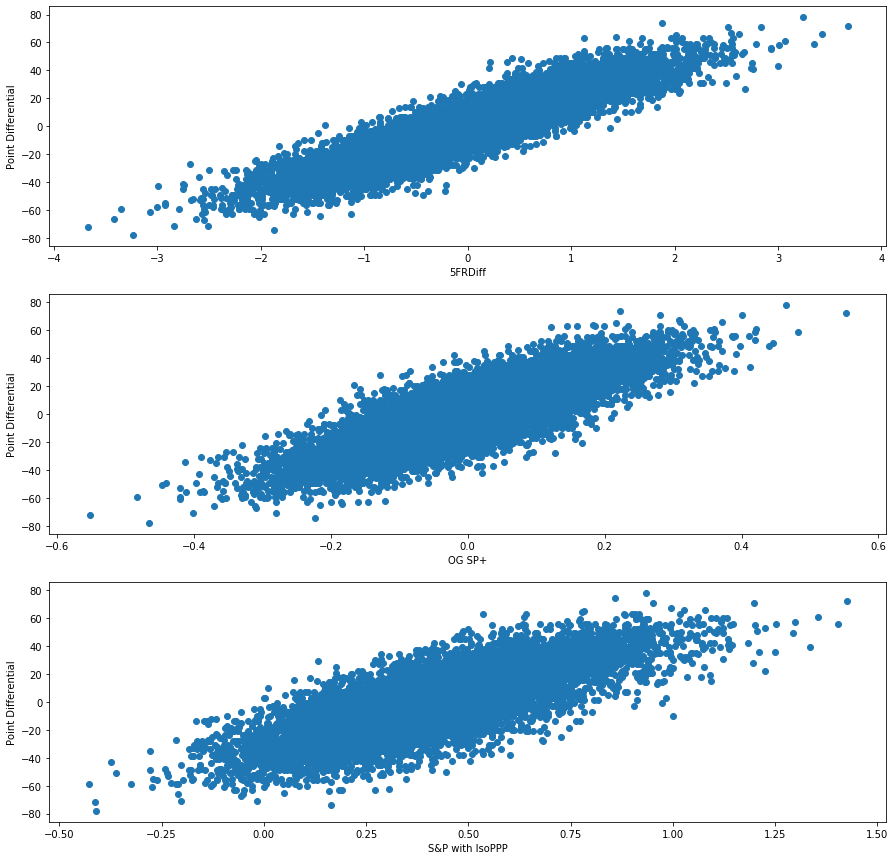

In [16]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [17]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.911990,0.759463
S&PIsoPPPDiff,0.911990,1.000000,0.816783
PtsDiff,0.759463,0.816783,1.000000


In [18]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037223,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037223,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474277,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474277,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583588,0.499553


In [19]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [20]:
# outliers

In [21]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037223,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037223,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474277,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474277,0.181656
1,Connecticut,2012,322430041,37.0,37.0,0.999995,0.385714,0.128571,5.614286,1.009238,...,0.042553,1.000000,0.857143,-0.045455,-0.045455,1.000000,6.011375,2.022751,2.311097,1.680314


In [22]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [23]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.75084x + -0.03440
Mean Pred Score: 0.404172966450213
Pred Std Dev: 20.34451514513839
Mean Abs Error: 7.5324973851511
Mdn Abs Error: 6.498227741288139
R-squared: 0.8160816577641574



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.780219,0.562229,0.515532,0.805511,0.616492,0.606498,0.983551,0.551671,0.780145,...,0.551328,0.487740,0.243625,0.164908,0.032886,0.090015,0.199198,0.903530,0.903530,0.903530
OffSRDiff,0.780219,1.000000,0.491121,0.323539,0.713885,0.423829,0.457182,0.777241,0.762984,0.736392,...,0.553356,0.449421,0.179261,0.103492,-0.038125,0.012468,0.102380,0.925599,0.925599,0.925599
OffERDiff,0.562229,0.491121,1.000000,0.172009,0.512011,0.294269,0.303923,0.554685,0.375486,0.794538,...,0.201104,0.205776,0.152587,0.056662,0.006391,0.033641,0.062310,0.523252,0.523252,0.523252
FPDiff,0.515532,0.323539,0.172009,1.000000,0.618701,0.130127,0.121211,0.495035,0.077277,0.253672,...,0.273740,0.276181,0.325378,0.259515,0.183396,0.222231,0.189488,0.580907,0.580907,0.580907
OppRateDiff,0.805511,0.713885,0.512011,0.618701,1.000000,0.233814,0.224285,0.808955,0.319120,0.680874,...,0.515352,0.436363,0.253362,0.171944,0.000534,0.070189,0.231784,0.830324,0.830324,0.830324
OppEffDiff,0.616492,0.423829,0.294269,0.130127,0.233814,1.000000,0.747786,0.610085,0.521217,0.447100,...,0.312736,0.285407,0.108752,0.066036,0.038532,0.047485,0.355218,0.514380,0.514380,0.514380
OppPPDDiff,0.606498,0.457182,0.303923,0.121211,0.224285,0.747786,1.000000,0.611059,0.567221,0.474684,...,0.344450,0.304281,0.108399,0.078956,0.016599,0.034387,0.045628,0.570221,0.570221,0.570221
PPDDiff,0.983551,0.777241,0.554685,0.495035,0.808955,0.610085,0.611059,1.000000,0.546549,0.771481,...,0.553575,0.481872,0.245791,0.158917,0.028735,0.092333,0.187942,0.898111,0.898111,0.898111
OppSRDiff,0.551671,0.762984,0.375486,0.077277,0.319120,0.521217,0.567221,0.546549,1.000000,0.568640,...,0.373398,0.302077,0.128440,0.032058,-0.033645,-0.021678,-0.032665,0.686452,0.686452,0.686452
YPPDiff,0.780145,0.736392,0.794538,0.253672,0.680874,0.447100,0.474684,0.771481,0.568640,1.000000,...,0.462547,0.429411,0.166169,0.080044,-0.033607,0.007846,0.093387,0.766058,0.766058,0.766058


In [24]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.768331,0.780219,0.723956,0.906091,0.515532,0.509082,0.903530,0.903530,0.903530
ActPts,0.768331,1.000000,0.596983,0.553716,0.693243,0.399681,0.392842,0.692781,0.692781,0.692781
Eff,0.780219,0.596983,1.000000,0.660197,0.815693,0.323539,0.299495,0.925599,0.925599,0.925599
Expl,0.723956,0.553716,0.660197,1.000000,0.696596,0.245601,0.239961,0.704141,0.704141,0.704141
FinDrv,0.906091,0.693243,0.815693,0.696596,1.000000,0.446801,0.448218,0.928769,0.928769,0.928769
FldPos,0.515532,0.399681,0.323539,0.245601,0.446801,1.000000,0.379276,0.580907,0.580907,0.580907
Trnovr,0.509082,0.392842,0.299495,0.239961,0.448218,0.379276,1.000000,0.499107,0.499107,0.499107
5FR,0.903530,0.692781,0.925599,0.704141,0.928769,0.580907,0.499107,1.000000,1.000000,1.000000
5FRDiff,0.903530,0.692781,0.925599,0.704141,0.928769,0.580907,0.499107,1.000000,1.000000,1.000000
PredPtsDiff,0.903530,0.692781,0.925599,0.704141,0.928769,0.580907,0.499107,1.000000,1.000000,1.000000


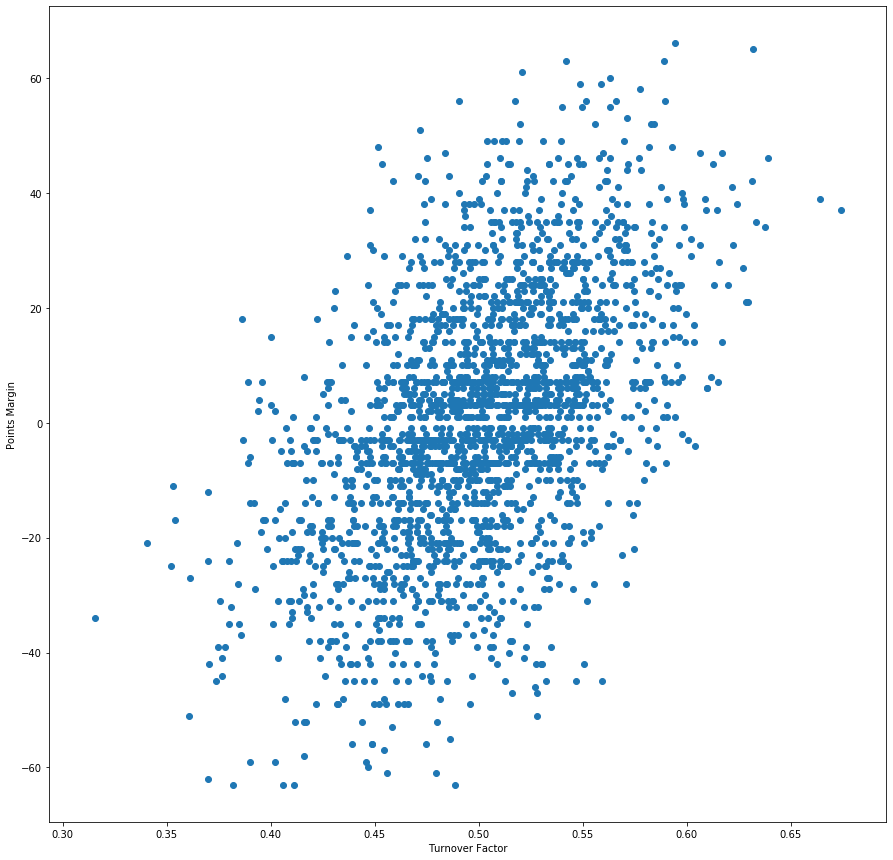

In [25]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

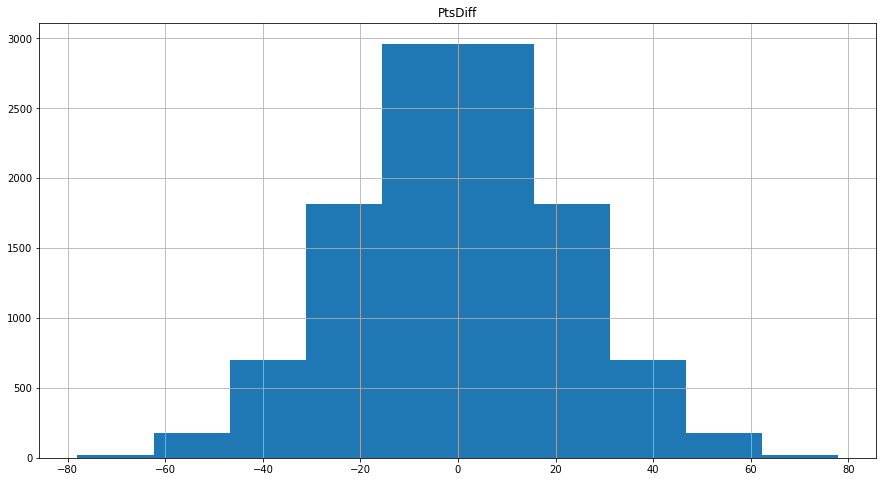

In [26]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

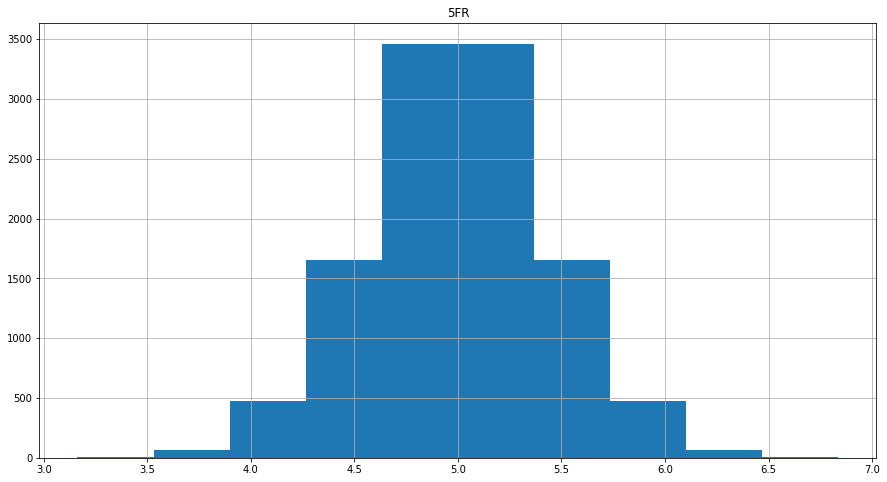

In [27]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

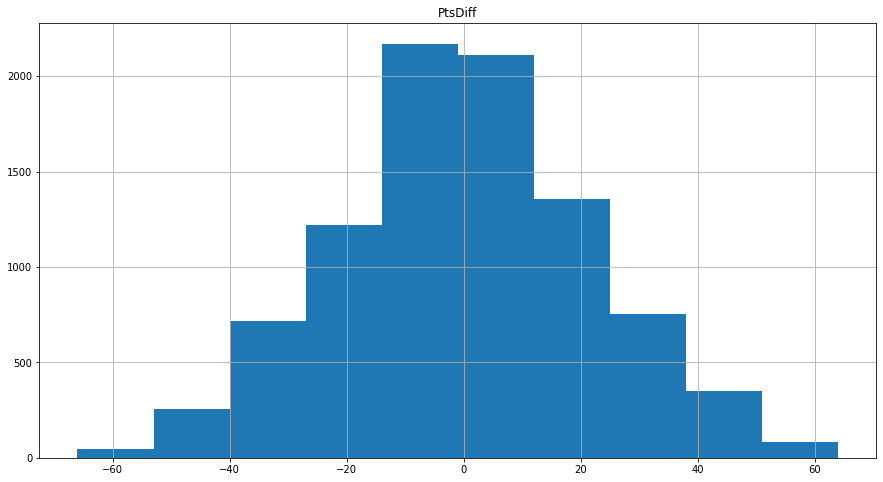

In [28]:
train_data.hist(column='PtsDiff', figsize=(15,8));

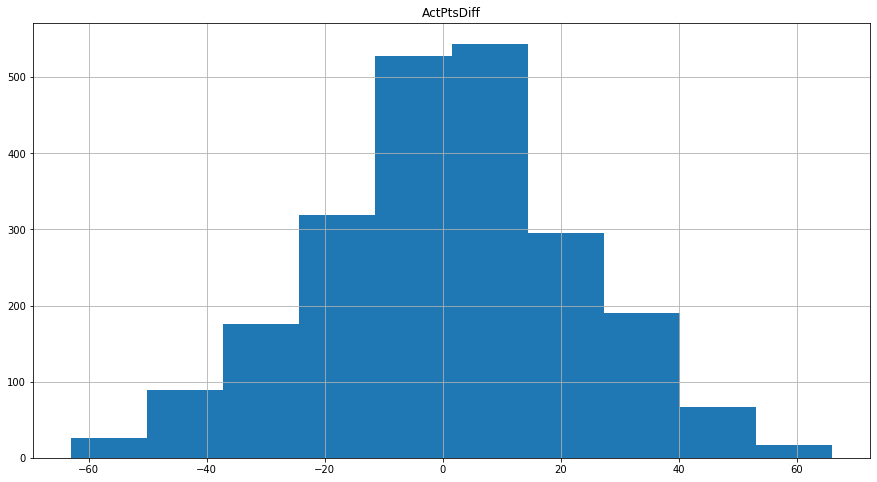

In [29]:
test.hist(column='ActPtsDiff', figsize=(15,8));

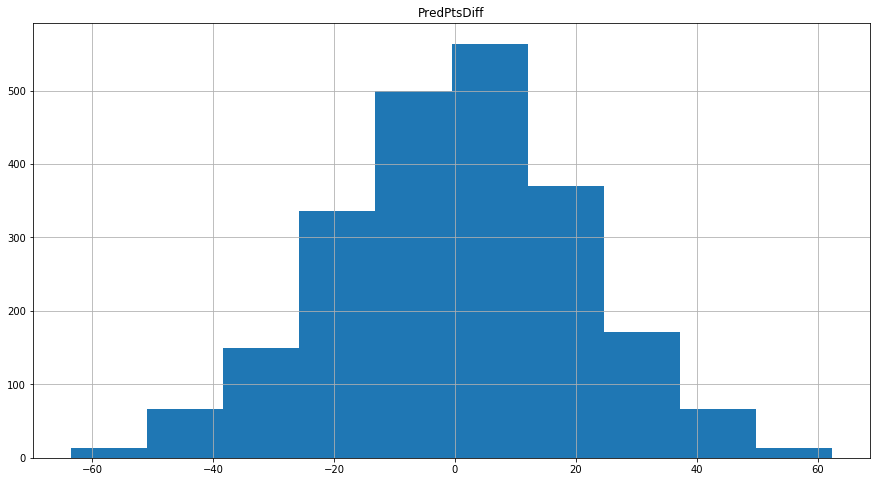

In [30]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [31]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [32]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.2453766733538436)
Z score: -0.17938739821362457
Win Prob for Virginia Tech: 42.88%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [33]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -11.0 (exact value: -11.386958637453024)
Z score: -0.5795729964457224
Win Prob for Georgia Tech: 28.11%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,-0.121075,0.018689,0.000768,0.0,0.0,0.166667,0.166667,0.0,4.750502,-0.498995
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,0.121075,-0.018689,-0.000768,0.0,0.0,-0.166667,-0.166667,0.0,5.249498,0.498995


In [34]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.608418975210099)
Z score: -0.04977223268465482
Win Prob for Georgia Tech: 48.02%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.300725,0.012719,0.0,-0.133333,0.066667,0.0,0.0,1.0,5.012615,0.025231
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.300725,-0.012719,0.0,0.133333,-0.066667,0.0,0.0,-1.0,4.987385,-0.025231


In [35]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 4.0 (exact value: 3.5030444779362884)
Z score: 0.152319752492435
Win Prob for Mississippi State: 56.05%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.070423,5.563380,0.880173,...,0.092249,0.000243,-0.004614,-0.666667,-0.333333,0.0,0.0,0,4.922257,-0.155486
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,-0.092249,-0.000243,0.004614,0.666667,0.333333,0.0,0.0,0,5.077743,0.155486


In [36]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -5.0379361446974125)
Z score: -0.26749760671726275
Win Prob for Texas A&M: 39.45%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,-0.349878,0.001282,-0.047436,0.2,0.2,-0.25,-0.25,-0.25,5.109964,0.219927
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,0.349878,-0.001282,0.047436,-0.2,-0.2,0.25,0.25,0.25,4.890036,-0.219927


In [37]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.933914,13,12.0,1.0
2,Clemson,0.926809,13,12.0,1.0
3,Alabama,0.901641,12,11.0,1.0
4,LSU,0.900016,13,12.0,1.0
5,Wisconsin,0.862433,13,11.0,2.0
...,...,...,...,...,...
126,Bowling Green,0.139601,12,2.0,10.0
127,Connecticut,0.130169,12,2.0,10.0
128,Rutgers,0.105523,12,1.0,11.0
129,Akron,0.087327,12,1.0,11.0


In [38]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.421893,1.578107
21,Clemson,10.524476,2.475524
53,LSU,10.282548,2.717452
128,Wisconsin,9.564926,3.435074
2,Alabama,9.240169,2.759831
...,...,...,...
119,Vanderbilt,2.304201,9.695799
25,Connecticut,2.022171,9.977829
103,Texas State,1.952267,10.047733
1,Akron,1.712105,10.287895


In [39]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.557889,1
1,Florida State,2012,5.454605,2
2,BYU,2012,5.335653,3
3,Arizona State,2012,5.333539,4
4,Oklahoma,2012,5.331083,5
...,...,...,...,...
1025,Bowling Green,2019,4.525809,126
1026,Connecticut,2019,4.506369,127
1027,Rutgers,2019,4.450434,128
1028,Akron,2019,4.402725,129


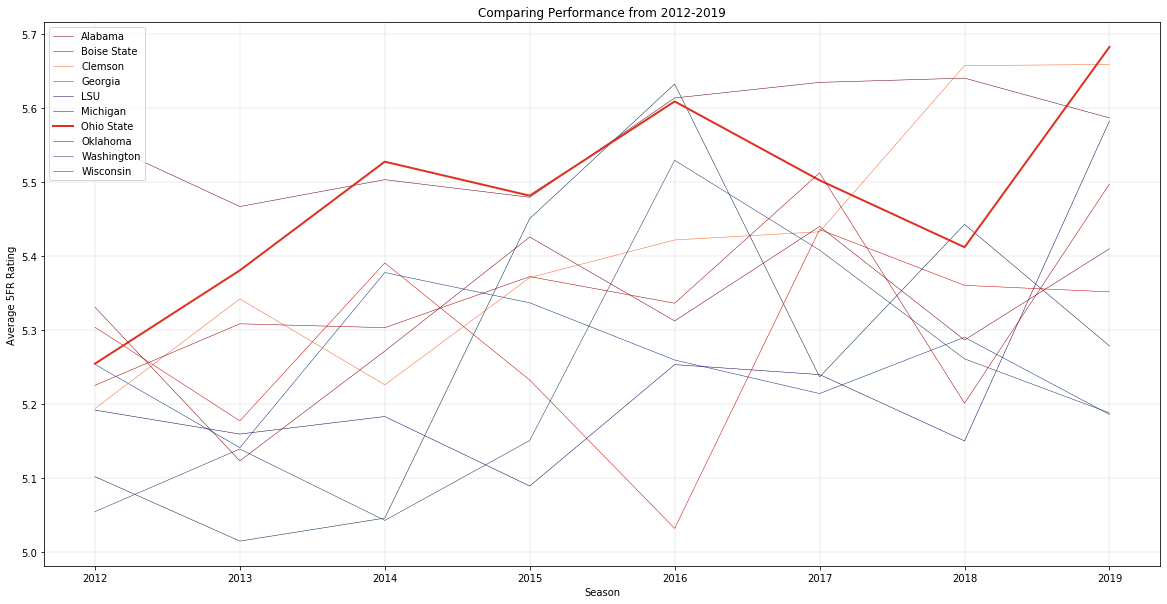

In [40]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [41]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.560512
1,Ohio State,5.481456
2,Clemson,5.413149
3,Wisconsin,5.344711
4,Oklahoma,5.325188
...,...,...
125,Georgia State,4.706279
126,UMass,4.678491
127,New Mexico State,4.678160
128,Coastal Carolina,4.621592


In [42]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
...,...,...,...,...,...
11335,401117533.0,Nevada,2019.0,Wyoming,7.0
11336,401117541.0,Boise State,2019.0,Wyoming,8.0
11337,401117546.0,Utah State,2019.0,Wyoming,9.0
11338,401117550.0,Colorado State,2019.0,Wyoming,10.0


In [43]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.14967570783074924, -20.709878702682232]

In [44]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
#     ['Virginia Tech', 'Kentucky', 3], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
#     ['Arizona State', 'Florida State', 4],
#    ----- 19-8 SU / 14-13 ATS ------  
#     ['Navy', 'Kansas State', 2],
#    ----- 20-8 SU / 15-13 ATS ------  
#     ['Wyoming', 'Georgia State', 7],
#    ----- 21-8 SU / 15-14 ATS ------  
#     ['Utah', 'Texas', 7],
#    ----- 21-9 SU / 16-14 ATS ------     
#     ['Auburn', 'Minnesota', 7.5], # Minnesota 31, Auburn 24
#     ['Alabama', 'Michigan', 7], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
#     ['Wisconsin','Oregon',2.5], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
#     ['Georgia','Baylor',7.5], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    
    ['Ohio', 'Nevada', 7.5],
    
    ['Tulane', 'Southern Mississippi', 7],
    
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Georgia,Baylor,7.5,-2.918526,0.435133,False,Baylor,Baylor
0,Cincinnati,Boston College,7.0,-5.903551,0.378263,False,Boston College,Boston College
0,Tennessee,Indiana,1.5,-1.484644,0.463015,False,Indiana,Indiana
0,Ohio,Nevada,7.5,6.283446,0.613704,False,Ohio,Nevada
0,Tulane,Southern Mississippi,7.0,-1.975107,0.453450,False,Southern Mississippi,Southern Mississippi
0,Louisiana,Miami (OH),14.0,-0.142474,0.489282,False,Miami (OH),Miami (OH)


In [45]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.24322371923239436)
Z score: -0.007911186188002113
Win Prob for Virginia: 49.68%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.403644,-0.089435,-0.044717,0.25,0.125,0.333333,0.333333,0.0,4.993899,-0.012203
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.403644,0.089435,0.044717,-0.25,-0.125,-0.333333,-0.333333,0.0,5.006101,0.012203


In [46]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.509354265459063)
Z score: 0.49670297998837415
Win Prob for North Carolina: 69.03%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.235394,0.079888,0.037736,0.238095,0.380952,-0.214286,-0.214286,0.5,5.231722,0.463445
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.235394,-0.079888,-0.037736,-0.238095,-0.380952,0.214286,0.214286,-0.5,4.768278,-0.463445


In [47]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19.0 (exact value: 19.04547089089961)
Z score: 0.9162812576982943
Win Prob for Pittsburgh: 82.02%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,-0.248736,0.038746,0.026324,0.0,0.0,0.0,0.0,0.166667,5.419322,0.838645
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,0.248736,-0.038746,-0.026324,0.0,0.0,0.0,0.0,-0.166667,4.580678,-0.838645


In [48]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -9.749577568329304)
Z score: -0.4990903180706127
Win Prob for Auburn: 30.89%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.083465,-0.033763,-0.013333,0.053571,0.160714,-0.666667,-0.666667,-0.5,5.213512,0.427025
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.083465,0.033763,0.013333,-0.053571,-0.160714,0.666667,0.666667,0.5,4.786488,-0.427025


In [49]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 34.0 (exact value: 34.199829818847576)
Z score: 1.6611679664665449
Win Prob for Georgia: 95.17%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,0.455922,0.020115,0.003352,0.888889,-0.111111,0.461538,0.461538,0.5,5.752373,1.504745
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-0.455922,-0.020115,-0.003352,-0.888889,0.111111,-0.461538,-0.461538,-0.5,4.247627,-1.504745


In [50]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 22.0 (exact value: 21.636591466625337)
Z score: 1.0436433775247238
Win Prob for Clemson: 85.17%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 9.0 (exact value: 9.490870796865366)
Z score: 0.4466411593292036
Win Prob for Georgia Tech: 67.24%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -11.0 (exact value: -10.57963486226912)
Z score: -0.5398903709604537
Win Prob for The Citadel: 29.46%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 21.0 (exact value: 20.866167467650225)
Z score: 1.0057744977072947
Win Prob for Temple: 84.27%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.509354265459063)
Z score: 0.4967029799883

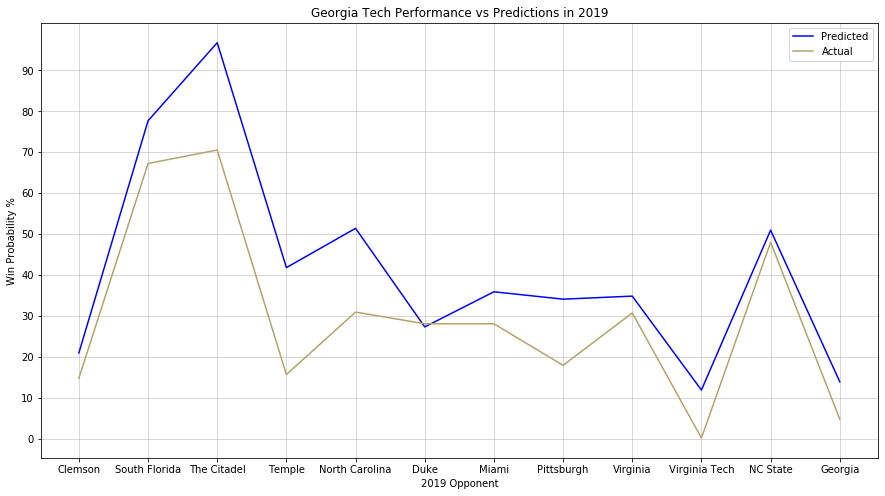

In [51]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

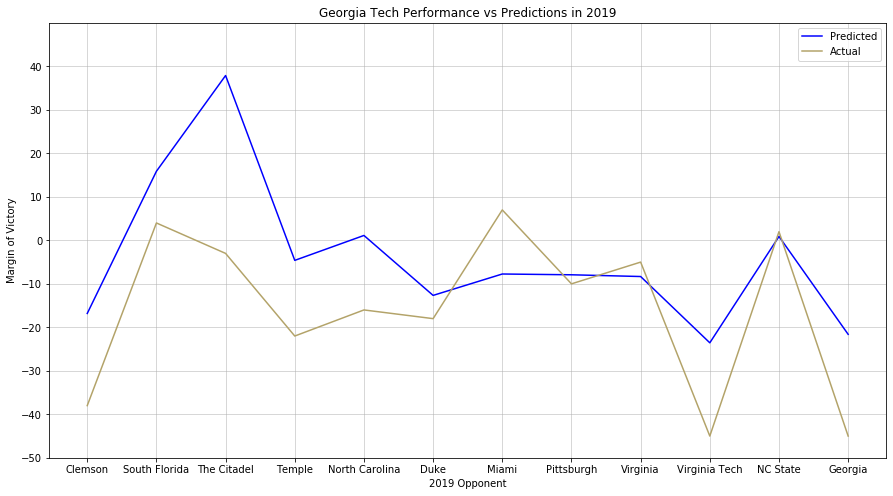

In [52]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 40.179488123260285)
Z score: 1.955087888457983
Win Prob for Georgia Tech: 97.47%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 8.0 (exact value: 8.255184967028265)
Z score: 0.3859031264480226
Win Prob for South Florida: 65.02%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 7.0 (exact value: 7.141398975821501)
Z score: 0.3311568725677516
Win Prob for Pittsburgh: 62.97%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 35.0 (exact value: 34.76095446224419)
Z score: 1.6887490928484485
Win Prob for Clemson: 95.44%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 38.0 (exact value: 38.47886287749115)
Z score:

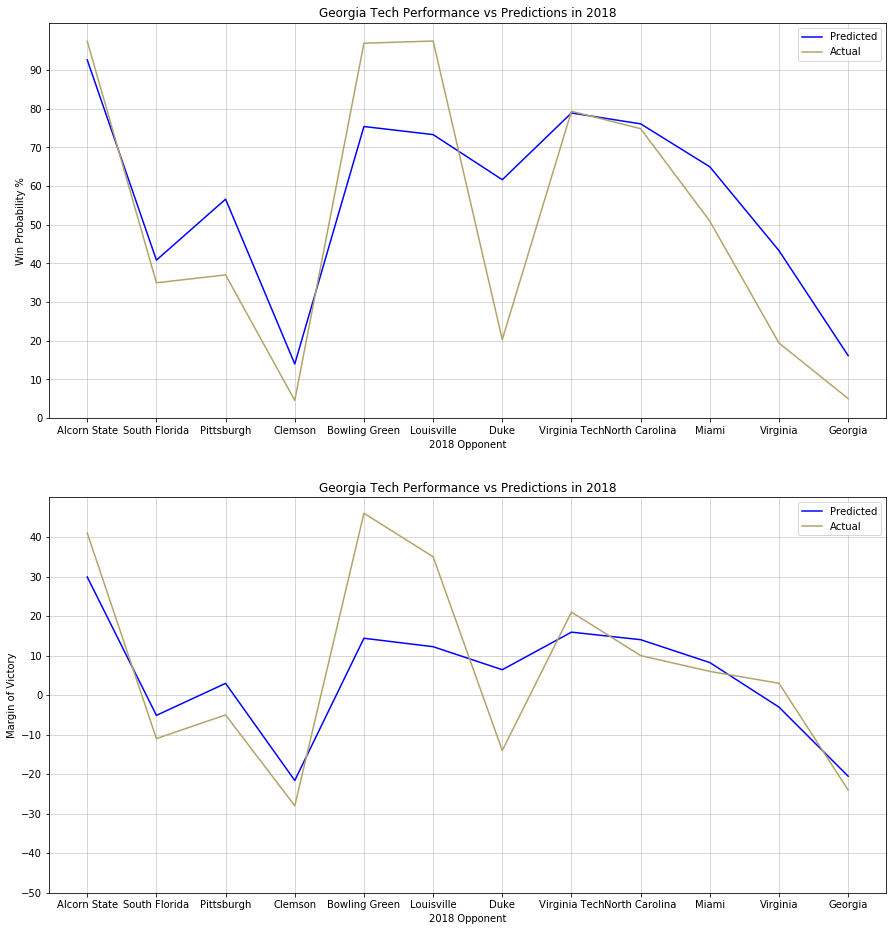

In [53]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

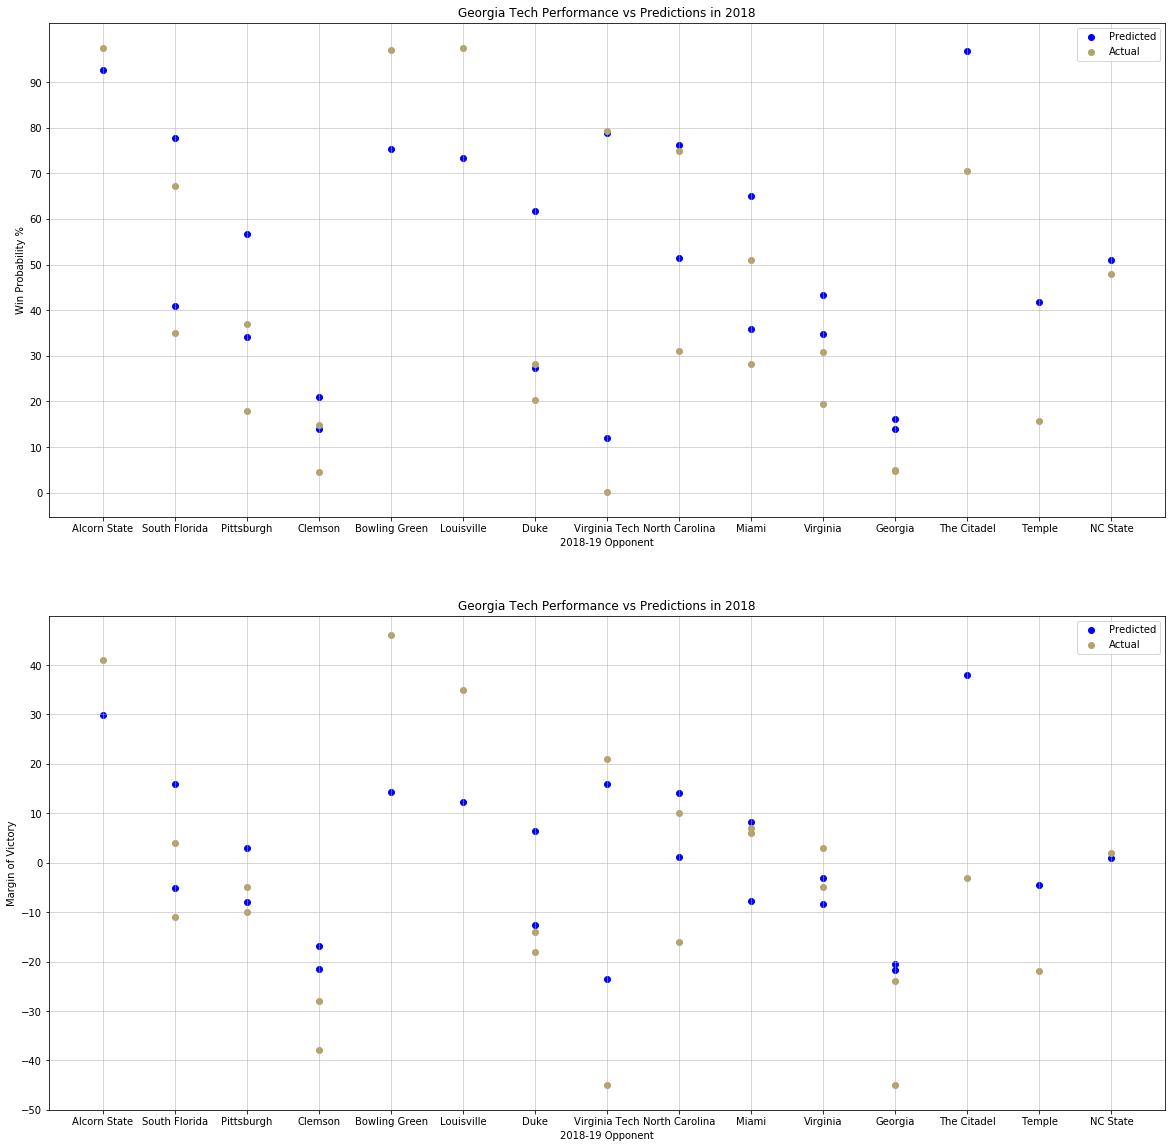

In [54]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [55]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.588419,0.525922,0.451708,0.382888,0.294932,0.300102,0.363724
2013,0.588419,1.000000,0.562660,0.366535,0.245886,0.260429,0.185906,0.279529
2014,0.525922,0.562660,1.000000,0.616191,0.486516,0.332863,0.332074,0.386088
2015,0.451708,0.366535,0.616191,1.000000,0.656791,0.472449,0.379352,0.403569
2016,0.382888,0.245886,0.486516,0.656791,1.000000,0.602822,0.417091,0.594267
2017,0.294932,0.260429,0.332863,0.472449,0.602822,1.000000,0.634953,0.569375
2018,0.300102,0.185906,0.332074,0.379352,0.417091,0.634953,1.000000,0.610008
2019,0.363724,0.279529,0.386088,0.403569,0.594267,0.569375,0.610008,1.000000


In [56]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,North Carolina,UCF,Away,36.575698,-6.576281
1,2020,North Carolina,Auburn,Home,29.537816,-10.535894
2,2020,North Carolina,James Madison,Home,97.240582,39.412550
3,2020,North Carolina,Connecticut,Home,73.743875,13.332484
4,2020,North Carolina,Boston College,Away,45.477586,-1.907045
5,2020,North Carolina,Duke,Away,47.896586,-0.668984
6,2020,North Carolina,Miami,Away,37.435388,-6.113065
7,2020,North Carolina,Georgia Tech,Home,58.897346,4.979759
8,2020,North Carolina,NC State,Home,55.189667,3.058211
9,2020,North Carolina,Pittsburgh,Home,47.579498,-0.830948


In [57]:
generate_win_prob(401135288, 2019)
box2 = calculate_box_score(401135288, 2019)
# testDiffs = ["Team",'5FRDiff']
# print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API
Game: Oregon @ Wisconsin
Actual Winner: Oregon
MOV: Oregon by 1
Proj MOV: Oregon by 4.0 (exact value: 3.829735610982151)
Z score: 0.16837769885858028
Win Prob for Oregon: 56.69%
---
Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Oregon,5.114379,4.947433,4.87236,5.115385,5.68268,5.084923,0.169846
1,Wisconsin,4.885621,5.052567,5.12764,4.884615,4.31732,4.915077,-0.169846


In [58]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.40751778729867494, -4.355117680766392]

In [59]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [60]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam, "AwayScore": lines.awayScore,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [61]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 700 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 692 games with betting lines for 2013 season.
[Simulation] Creating projections for 692 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 697 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 648 games with betting lines for 2014 season.
[Simulation] Creating projections for 648 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 709 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 675 games with betting lines for 2015 season.
[Simulation] Creating projections for 675 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,541,151,0,0.781792
1,ATS,2013,387,297,8,0.559249
0,ML,2014,502,146,0,0.774691
1,ATS,2014,400,232,16,0.617284
0,ML,2015,532,143,0,0.788148
1,ATS,2015,399,258,18,0.591111
0,ML,2016,524,152,0,0.775148
1,ATS,2016,404,254,18,0.597633
0,ML,2017,566,154,0,0.786111
1,ATS,2017,422,278,20,0.586111


In [62]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7753763134439006
Avg ATS Win %: 0.5840500844563354


In [63]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [73]:
break_down_box_score(calculate_box_score(401136253, 2019))

Could not find basic game data for game_id 401136253 locally, checking CFB Data API
Could not find drive data for game_id 401136253 locally, checking CFB Data API
Could not find play by play data for game_id 401136253 locally, checking CFB Data API


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,USC,4.574315,4.991125,3.767605,3.345385,4.281296,4.426156,-1.147687
1,Iowa,5.425685,5.008875,6.232395,6.654615,5.718704,5.573844,1.147687
